In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

freq_true.shape (1003,)
R_true.shape (201,)


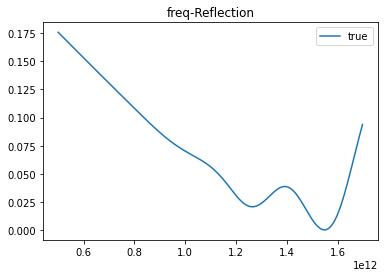

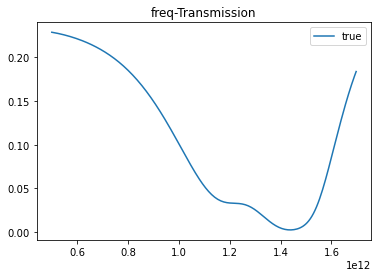

1098
(222,)
idx_freq_tg1 ORIG: 151
idx_freq_tg1: 166.77611940298507
R_tg1: 0.038314723405216806
T_tg1: 0.004280525157849011
T_tg2: 0.22840801357720697
--------
idx_freq_tg2 ORIG: 117
idx_freq_tg2: 129.22388059701493
R_tg2: 0.03066116289643781


In [4]:
path_true_R = './Simple_RCWA/data/R_absorber.txt'
R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
freq_true = R_file[:, 0] * 1e12
R_true = R_file[:, 1]
R_true = R_true**2
print('freq_true.shape', freq_true.shape)
# print(R_true)

path_true_T = './Simple_RCWA/data/T_absorber.txt'
T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
T_true = T_file[:, 1]
T_true = T_true**2

# truncate freq
freq_truncate = 1.7  # in THz
N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
freq_true = freq_true[:N_freq_stop]
R_true = R_true[:N_freq_stop]
T_true = T_true[:N_freq_stop]
freq_step = 4
freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
print('R_true.shape', R_true.shape)

plt.figure(1)
plt.plot(freq_true, R_true, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq_true, T_true, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
print(eps_absorber_file.shape[0])
# truncate freq over 1.7THz
# freq_truncate = 1.7  # in THz
# freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)


# ================== Get Target Spectra Value
# print(freq_true)
idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
print('idx_freq_tg1 ORIG:', idx_freq_tg1)
R_tg1 = R_true[idx_freq_tg1]
T_tg1 = T_true[idx_freq_tg1]
T_tg2 = T_true[0]

idx_freq_tg1 = idx_freq_tg1/201*222
print('idx_freq_tg1:', idx_freq_tg1)
print('R_tg1:', R_tg1)
print('T_tg1:', T_tg1)
print('T_tg2:', T_tg2)


print('--------')
idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
print('idx_freq_tg2 ORIG:', idx_freq_tg2)
R_tg2 = R_true[idx_freq_tg2]

idx_freq_tg2 = idx_freq_tg2/201*222
print('idx_freq_tg2:', idx_freq_tg2)
print('R_tg2:', R_tg2)

# Looping to generate data and training

In [5]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [57. 78.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [112.  63.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [89. 98.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [105. 100.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [146.  96.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [148. 114.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [56. 60.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [128. 149.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [110.  51.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 97. 129.]
Calculation Progress: 100%
-----

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [64. 78.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [110.  93.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 83. 104.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [94. 56.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [146.  80.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [63. 87.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [105.  93.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 53. 121.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [98. 78.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [130. 127.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 51. 125.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [142. 117.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.0012840351376144099
### TEST LOSS  0.001306301448494196
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0008666532775896485
### TEST LOSS  0.00034692074405029416
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.0005067412004245852
### TEST LOSS  0.00027409154184473056
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.00040149716998712394
### TEST LOSS  0.0004519479407463223
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.00025329052630695514
### TEST LOSS  0.00022469463389522085
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.0002967499291844433
### TEST LOSS  0.00027412863467664766
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.0128935478851417e-05
### TEST LOSS  1.0055749498860678e-05
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 8.063312274373402e-06
### TEST LOSS  1.17353927938287e-05
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 7.395393334945766e-06
### TEST LOSS  4.954055536169714e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 6.4230873192627765e-06
### TEST LOSS  3.284421533559604e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.422662577596384e-06
### TEST LOSS  9.826706900639692e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.3413983606369583e-05
### TEST LOSS  9.788622264750302e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.3804357587664526e-06
### TEST LOSS  2.2380517445223327e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.8468124420678578e-06
### TEST LOSS  1.5833749102966976e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 2.1915354309243184e-06
### TEST LOSS  2.2854314162638425e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 2.0372611329833036e-06
### TEST LOSS  1.3679569216643965e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.7302507430372317e-06
### TEST LOSS  1.2018132906632673e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.663527429656142e-06
### TEST LOSS  2.1946630492190402e-06
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.092367923263282e-06
### TEST LOSS  9.566990684106713e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.576085888023499e-07
### TEST LOSS  6.995872657474441e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.1052180988713189e-06
### TEST LOSS  8.154488189878369e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.194162328578614e-07
### TEST LOSS  8.787778256191814e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.596924308790222e-07
### TEST LOSS  7.604012353112921e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 8.372790176736089e-07
### TEST LOSS  6.930912566834498e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.568347502877714e-07
### TEST LOSS  7.155989199721565e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.333133388063516e-07
### TEST LOSS  4.092834444691107e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 2.8863721461647174e-06
### TEST LOSS  1.6012345819641875e-06
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.172203887231717e-06
### TEST LOSS  9.806827279135177e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 2.821078182151382e-06
### TEST LOSS  1.3023844000296474e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 1.3310987539938423e-06
### TEST LOSS  6.711975023184399e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.221841395552929e-07
### TEST LOSS  3.498348822480087e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.703712259868098e-07
### TEST LOSS  4.3700549667846644e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.656262641589137e-07
### TEST LOSS  3.669221181705022e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.027592184385753e-07
### TEST LOSS  3.610871980678591e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.374830237452443e-07
### TEST LOSS  3.052812379185828e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.521997010366931e-07
### TEST LOSS  3.967339713047598e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.838190156990606e-07
### TEST LOSS  3.3487335334333085e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.371291135678689e-07
### TEST LOSS  3.8241220560545724e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.163418712543887e-07
### TEST LOSS  2.859199904984659e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.876130534408162e-07
### TEST LOSS  3.855798430170883e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.2916480769150667e-07
### TEST LOSS  5.42983646785918e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.6074539876196356e-07
### TEST LOSS  4.590048566418166e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.551814883451243e-07
### TEST LOSS  3.3963907715891156e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.0723373917851404e-07
### TEST LOSS  3.623682971465314e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.5997624575401233e-07
### TEST LOSS  3.8067204854996817e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.703345354073463e-07
### TEST LOSS  4.871912153703306e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.5383949142774327e-07
### TEST LOSS  6.360752422551741e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.973005677693209e-07
### TEST LOSS  3.000888284532266e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.8519569553964177e-07
### TEST LOSS  3.0420214140273555e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.142054436722219e-07
### TEST LOSS  2.0852645832292183e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.6831551803118145e-07
### TEST LOSS  2.9914230026406585e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.5265303509390834e-07
### TEST LOSS  2.4810933041408134e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.1443032973754723e-07
### TEST LOSS  2.681862270037527e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.5685702432175503e-07
### TEST LOSS  2.961432509588728e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.4071798719660366e-07
### TEST LOSS  1.9620780259780682e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.548234955985663e-07
### TEST LOSS  2.3042244852907365e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.7821132990268895e-07
### TEST LOSS  2.2634393322581067e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.5711767893076285e-07
### TEST LOSS  2.4766533594326273e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.6802158950900437e-07
### TEST LOSS  2.0137699626351e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.449411232241516e-07
### TEST LOSS  2.7774457578289e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.101152151963049e-07
### TEST LOSS  2.6709370596715115e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.523190454617463e-07
### TEST LOSS  2.557026400988131e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.3196879217479704e-07
### TEST LOSS  2.2123338775751714e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.450203732795586e-07
### TEST LOSS  2.914266398571878e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.358069076535685e-07
### TEST LOSS  2.997878614981649e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.5092254070102625e-07
### TEST LOSS  2.2457568604750122e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 2.534426041300719e-07
### TEST LOSS  2.7099085286863556e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.167054637387423e-07
### TEST LOSS  3.850954991927817e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.6860581316512365e-07
### TEST LOSS  2.3558028298490777e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.355311538160265e-07
### TEST LOSS  1.562352972920659e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 1.9766123791065126e-07
### TEST LOSS  2.1672055083854502e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.395461803317289e-07
### TEST LOSS  2.738182539966753e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.617676359051302e-07
### TEST LOSS  1.8904691027425238e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.484574129368866e-07
### TEST LOSS  2.2352227328307586e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 2.8935716937184e-07
### TEST LOSS  2.6757683713185543e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.690705070980016e-07
### TEST LOSS  2.1195830868236953e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.514403097997331e-07
### TEST LOSS  2.0870472875837245e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.704161359901036e-07
### TEST LOSS  3.099739179409274e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.4736627079136043e-07
### TEST LOSS  1.7079763381389057e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 1.8356006620479093e-07
### TEST LOSS  1.453861907900015e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.1726580085257296e-07
### TEST LOSS  2.790024211662967e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.3031202887935366e-07
### TEST LOSS  2.3125859153575826e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.1540440166667453e-07
### TEST LOSS  2.3598486601864957e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.091402852994918e-07
### TEST LOSS  2.0581635832665293e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.183313005055254e-07
### TEST LOSS  1.7356565725397863e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.7986010023562926e-07
### TEST LOSS  2.083215235870739e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 1.9494010901510707e-07
### TEST LOSS  1.5336989160156614e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 1.9564803638516537e-07
### TEST LOSS  2.2969826337278695e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 7.687335780204307e-07
### TEST LOSS  2.659504474422647e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.3613504069430746e-07
### TEST LOSS  2.4959187309529324e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.8172484732635895e-07
### TEST LOSS  1.6697830555282658e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.0056721680816736e-07
### TEST LOSS  1.6634784098338665e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.790735595719184e-07
### TEST LOSS  1.5127677007361248e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.8029810611608354e-07
### TEST LOSS  1.4921586455329816e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.8507170953085962e-07
### TEST LOSS  2.7304921938290744e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.20701975766724e-07
### TEST LOSS  1.958571876533218e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.5798477930827347e-07
### TEST LOSS  2.400164002362241e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.8668733096305345e-07
### TEST LOSS  2.731166925210952e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.1160421545651786e-07
### TEST LOSS  1.9116595713815818e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.1335933977351119e-07
### TEST LOSS  1.6850296920741434e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.405802913507671e-07
### TEST LOSS  4.1439763739011443e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.258431829815777e-07
### TEST LOSS  1.3880089729430742e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 1.658150852890117e-07
### TEST LOSS  1.9757047671949599e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.6752455573865176e-07
### TEST LOSS  1.213126878951698e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 1.8308757136153985e-07
### TEST LOSS  1.32763756729067e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.7321425627159215e-07
### TEST LOSS  2.543144527559586e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.427304717045331e-07
### TEST LOSS  1.1415776886754732e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.4077992856419427e-07
### TEST LOSS  1.424317919903236e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.9668732141653324e-07
### TEST LOSS  1.6331472352248966e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.6412714689550967e-07
### TEST LOSS  2.1124633538723478e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.4548151156645871e-07
### TEST LOSS  1.373407485516509e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 1.7736579177807243e-07
### TEST LOSS  4.0419017940015084e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.382846463078181e-07
### TEST LOSS  1.1633141146679311e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.1498842738054692e-07
### TEST LOSS  2.3447052418153666e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1007 || AVG LOSS 2.0860313593829005e-07
### TEST LOSS  1.2909503510627474e-07
----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.8008333916519347e-07
### TEST LOSS  1.1548382635358696e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.5608027618796426e-07
### TEST LOSS  2.634979333985636e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.652369412852295e-07
### TEST LOSS  1.2387225230744056e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.680469044413769e-07
### TEST LOSS  2.880207148336922e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.83549597529975e-07
### TEST LOSS  1.5111572793102823e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1059 || AVG LOSS 1.7586221224163978e-07
### TEST LOSS  1.3114705410544047e-07
----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 1.373510307622894e-07
### TEST LOSS  1.3465207378734098e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.2802985930981946e-07
### TEST LOSS  2.0245766544727908e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.597907833073009e-07
### TEST LOSS  9.692271637125789e-08
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.751834635133065e-07
### TEST LOSS  4.025632070655168e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.993912123143815e-07
### TEST LOSS  1.337777272662303e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1111 || AVG LOSS 1.6296723295283755e-07
### TEST LOSS  1.1040565321233468e-07
----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 1.3392642907561482e-07
### TEST LOSS  1.0957393925536962e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 1.3425721864024354e-07
### TEST LOSS  1.4783957169584028e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.160289228925194e-07
### TEST LOSS  1.34209443558575e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.124043062248006e-07
### TEST LOSS  6.053356097860766e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.0011212400028456e-07
### TEST LOSS  1.1726869075801005e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1163 || AVG LOSS 1.850255627999786e-07
### TEST LOSS  1.3447839582643914e-07
----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.4243086348564305e-07
### TEST LOSS  1.289211913520679e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 1.4096508492933425e-07
### TEST LOSS  1.0365929388929847e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.234301087915668e-07
### TEST LOSS  8.91949293683562e-08
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 1.4108715126859295e-07
### TEST LOSS  1.2027759529094814e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.4228508954161612e-07
### TEST LOSS  1.0144213291596316e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1215 || AVG LOSS 1.6601348808542583e-07
### TEST LOSS  1.3694432254851563e-07
----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.7192758233086636e-07
### TEST LOSS  1.0371356040650426e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 1.226817944388614e-07
### TEST LOSS  1.4692682270833757e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.2927405007800985e-07
### TEST LOSS  1.121771878350349e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 1.2355945629316524e-07
### TEST LOSS  1.09091265206492e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 1.3776024566425348e-07
### TEST LOSS  1.0398618854878805e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1267 || AVG LOSS 1.507430289038325e-07
### TEST LOSS  1.2814845007369513e-07
----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 1.1354199070723326e-07
### TEST LOSS  1.0205775187917727e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.307381363879756e-07
### TEST LOSS  1.1428319623973948e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.3318866515454886e-07
### TEST LOSS  1.169512439484303e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.5903828142427302e-07
### TEST LOSS  1.0291245663059574e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.2626133469927367e-07
### TEST LOSS  7.185718686741893e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1319 || AVG LOSS 1.4014518603389093e-07
### TEST LOSS  9.203097780149012e-08
----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.2924950260728706e-07
### TEST LOSS  1.244634025473109e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.1248499059313134e-07
### TEST LOSS  2.256592116130681e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.5217616373242037e-07
### TEST LOSS  8.161586132852487e-08
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 1.2524481869391478e-07
### TEST LOSS  1.7596543481583163e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 1.2124576343364168e-07
### TEST LOSS  1.614749862710596e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1371 || AVG LOSS 1.4535345931321332e-07
### TEST LOSS  1.5065531518606198e-07
----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.2016584806318063e-07
### TEST LOSS  8.517257299445191e-08
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.6499758803689701e-07
### TEST LOSS  1.2375382378119562e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.462061660895131e-07
### TEST LOSS  1.1018895899420993e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.2325197323193038e-07
### TEST LOSS  1.3236559463318068e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 1.7072475701596091e-07
### TEST LOSS  1.0764093142749213e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1423 || AVG LOSS 1.5382161762111933e-07
### TEST LOSS  2.348157721598909e-07
----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 1.766382749757156e-07
### TEST LOSS  4.88559152245216e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.8267174724861946e-07
### TEST LOSS  9.69440160740002e-08
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.6759269542809817e-07
### TEST LOSS  1.336838479915059e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.4902672462291378e-07
### TEST LOSS  1.0863247013048749e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.3819547978854984e-07
### TEST LOSS  1.0165684235137935e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1475 || AVG LOSS 1.1454159769996864e-07
### TEST LOSS  1.0187774061402403e-07
----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.1996858249485597e-07
### TEST LOSS  7.60611390167772e-08
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.2243635854503055e-07
### TEST LOSS  1.5273968282751108e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 1.3290384706543534e-07
### TEST LOSS  1.4560689483763176e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 1.9059713316060822e-07
### TEST LOSS  2.180201240283471e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.3576750311994346e-07
### TEST LOSS  9.200050262355337e-08
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1527 || AVG LOSS 1.2279471909515393e-07
### TEST LOSS  9.991861086670421e-08
----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 1.3359074715335595e-07
### TEST LOSS  8.361087585247635e-08
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 1.2928076191798256e-07
### TEST LOSS  1.0091257015195272e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.0056307484518356e-07
### TEST LOSS  1.4368082664380685e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.1515112948501382e-07
### TEST LOSS  1.0766877286035499e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.623013635043691e-07
### TEST LOSS  9.148922449260984e-08
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1579 || AVG LOSS 1.089390357034148e-07
### TEST LOSS  9.573259281599651e-08
----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 8.878583834359688e-08
### TEST LOSS  7.649008892940401e-08
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.4696592669949383e-07
### TEST LOSS  1.1210792886610459e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.2267019139144964e-07
### TEST LOSS  9.848180108444164e-08
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.0091443656712329e-07
### TEST LOSS  8.977201086205848e-08
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 1.441041015715072e-07
### TEST LOSS  1.7026641311683002e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1631 || AVG LOSS 1.245802946492347e-07
### TEST LOSS  1.4785700367762425e-07
----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.305111871996445e-07
### TEST LOSS  8.971560087426648e-08
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.1059501367149949e-07
### TEST LOSS  9.386499518389731e-08
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.251740080476793e-07
### TEST LOSS  2.1784730582415554e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.0091697968839242e-07
### TEST LOSS  8.816524162587787e-08
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.590581170951566e-07
### TEST LOSS  1.5605813530328305e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1683 || AVG LOSS 1.3288143778211746e-07
### TEST LOSS  8.831039366441473e-08
----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 9.811968042061636e-08
### TEST LOSS  6.467332269721737e-08
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.1998376908906039e-07
### TEST LOSS  1.3192168779596614e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 9.698713943073756e-08
### TEST LOSS  8.530131149579272e-08
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.0056978080985601e-07
### TEST LOSS  1.068838552479671e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.1920045059010676e-07
### TEST LOSS  1.0551280382742334e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1735 || AVG LOSS 1.2625437552316042e-07
### TEST LOSS  1.1272875610757183e-07
----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 1.1255735744342133e-07
### TEST LOSS  1.2034940984525141e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.0057143873254404e-07
### TEST LOSS  9.59452108872938e-08
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 9.876673040309925e-08
### TEST LOSS  6.852559882493854e-08
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 9.7242936552e-08
### TEST LOSS  1.1702923548758311e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 1.3496179690264398e-07
### TEST LOSS  1.9139457663186477e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1787 || AVG LOSS 1.0253362818346545e-07
### TEST LOSS  8.764097477372464e-08
----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 9.793538070290709e-08
### TEST LOSS  7.467033450817932e-08
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 8.44780335462758e-08
### TEST LOSS  7.44928148795528e-08
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 9.185003111422673e-08
### TEST LOSS  7.110064596342151e-08
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 8.621377434181454e-08
### TEST LOSS  6.089510762308237e-08
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.1299932565211889e-07
### TEST LOSS  1.7832996945799096e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1839 || AVG LOSS 9.023364619942242e-08
### TEST LOSS  1.409930755850534e-07
----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 9.176921647480185e-08
### TEST LOSS  8.931541136310746e-08
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 9.878794925199941e-08
### TEST LOSS  1.215093495450977e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.0817859471323742e-07
### TEST LOSS  6.742932375421636e-08
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 9.477622230136262e-08
### TEST LOSS  6.789289604588096e-08
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 9.200575449064274e-08
### TEST LOSS  1.0532608977579609e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1891 || AVG LOSS 1.0973702232242032e-07
### TEST LOSS  1.757759330682044e-07
----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 8.824160865117391e-08
### TEST LOSS  7.975704363616387e-08
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 1.114787353007074e-07
### TEST LOSS  9.195853796957938e-08
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.0167526937943095e-07
### TEST LOSS  1.1878130834475087e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.0111855853089935e-07
### TEST LOSS  8.535950494585147e-08
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.1045471596027312e-07
### TEST LOSS  7.649405612634534e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 9.035999536166628e-08
### TEST LOSS  7.197716911377938e-08
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.0136914432301581e-07
### TEST LOSS  6.354614375444119e-08
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 9.662145163069624e-08
### TEST LOSS  8.230722414737102e-08
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 8.558491698229532e-08
### TEST LOSS  6.346505898591204e-08
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.6480708256771947e-07
### TEST LOSS  1.0504954654303826e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.0312039539606132e-07
### TEST LOSS  1.002456381608378e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 9.17577001402492e-08
### TEST LOSS  6.799115226385766e-08
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 9.320742379692603e-08
### TEST LOSS  9.209406689099826e-08
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 8.26553348787229e-08
### TEST LOSS  1.2559952959160606e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 9.519670473689957e-08
### TEST LOSS  7.583719963122348e-08
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 7.859077693517236e-08
### TEST LOSS  5.773108332126261e-08
** loss_train 7.859077693517236e-08
** loss_test 5.773108332126261e-08
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


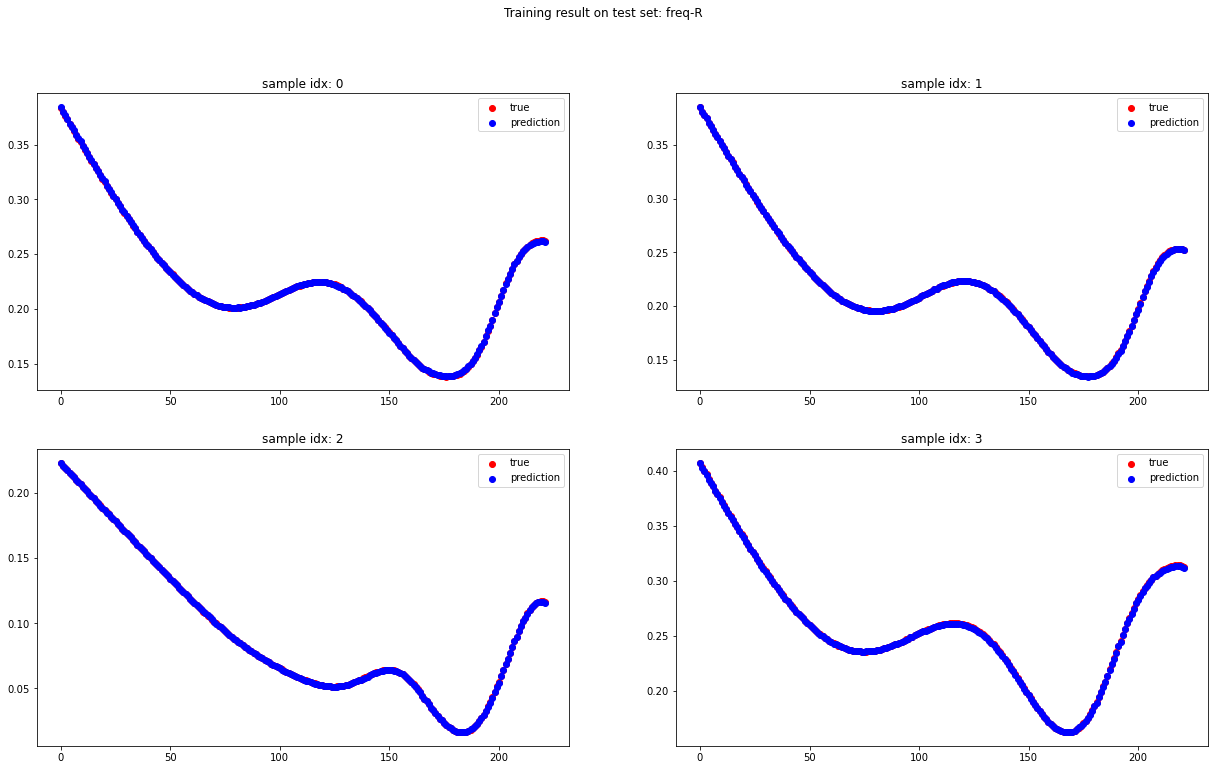

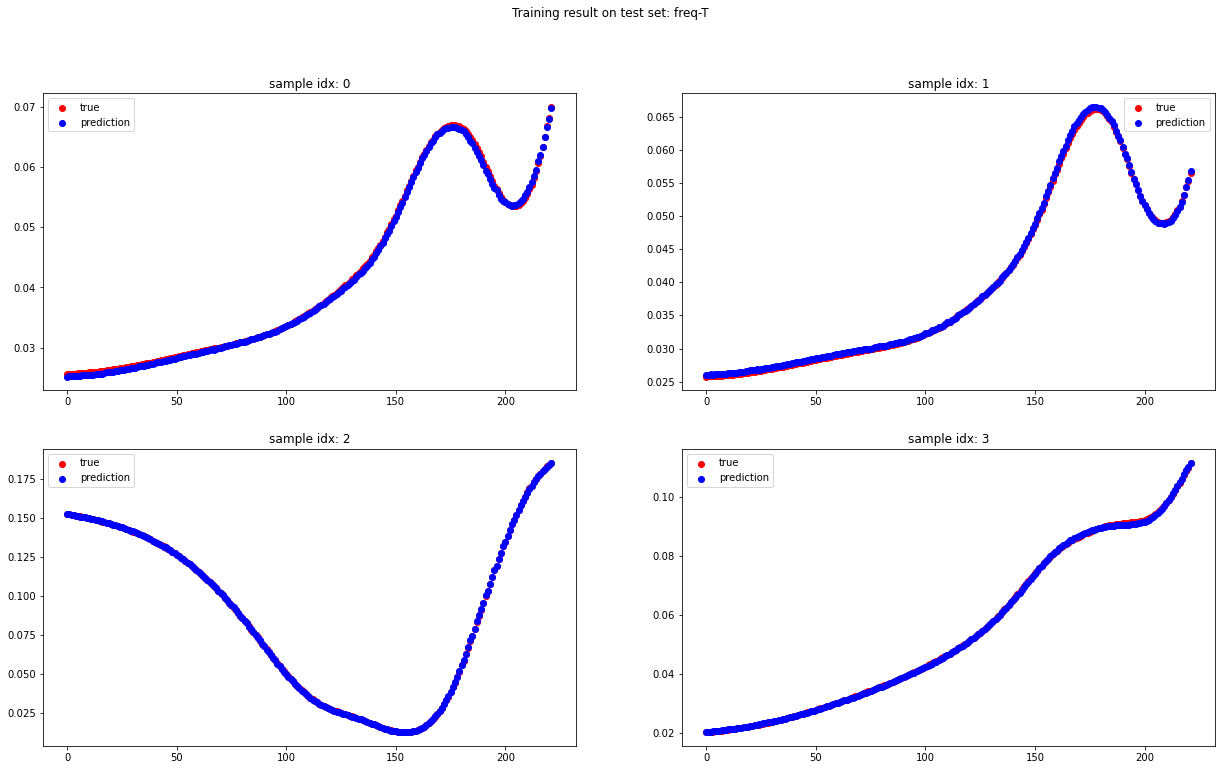

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [145. 123. 160.  75.]
 [147. 121. 160.  75.]
 [145. 122. 160.  75.]
 [147. 120. 160.  75.]
 [146. 120. 160.  75.]
 [145. 121. 160.  75.]
 [144. 121. 160.  75.]
 [144. 122. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


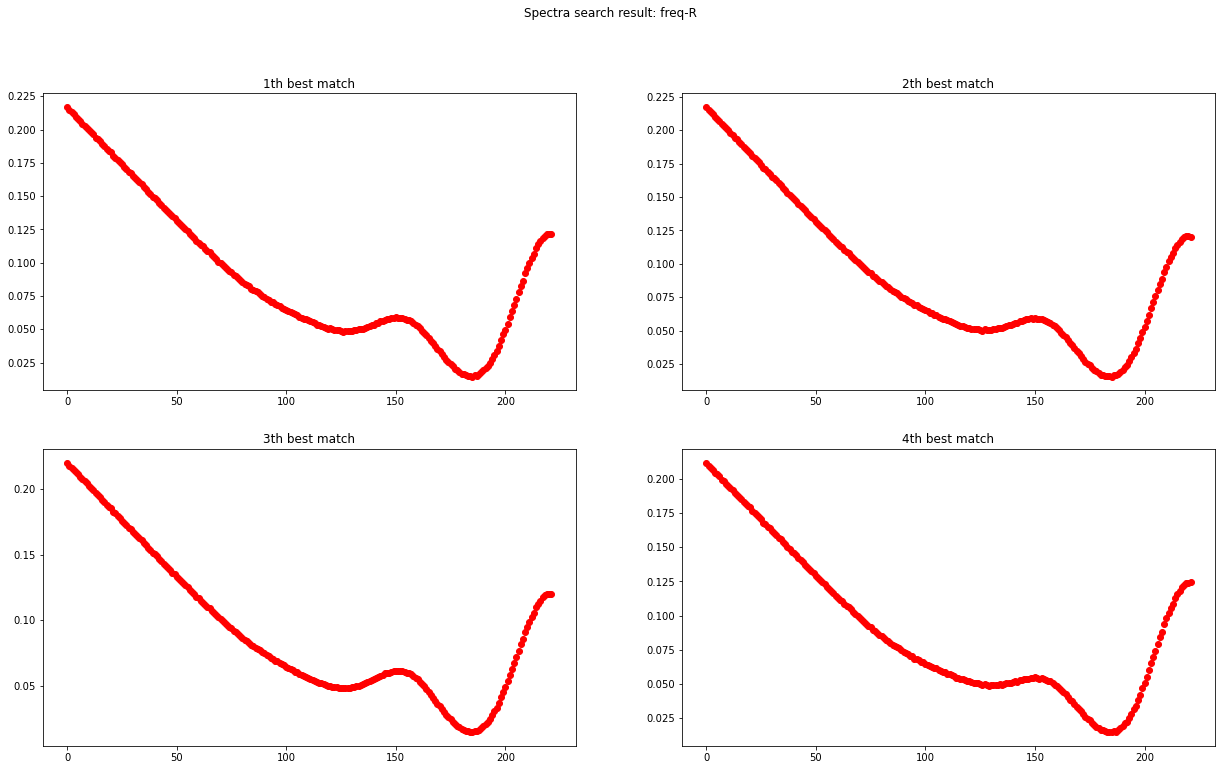

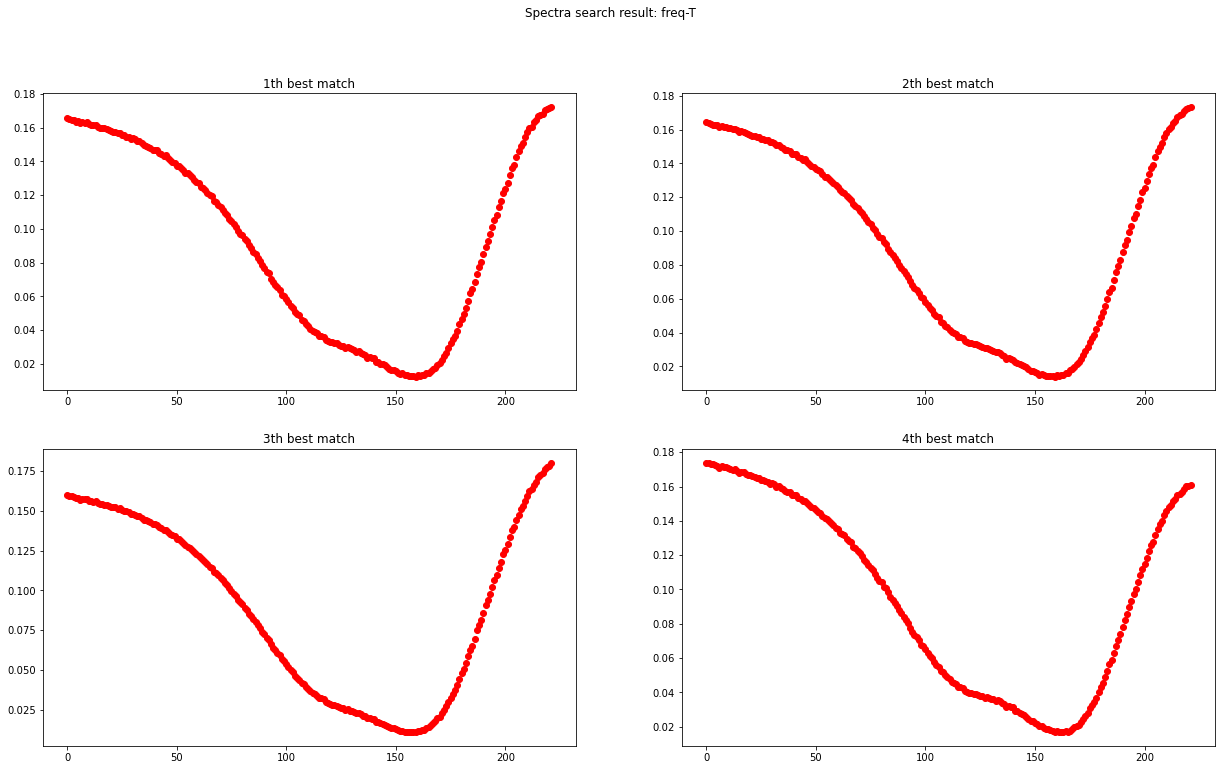

*** Reruning RCWA on picked params
params_dict.shape: (200, 4)
R_dict.shape: (200, 222)
T_dict.shape: (200, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [146. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [146. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [145. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [147. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [145. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6

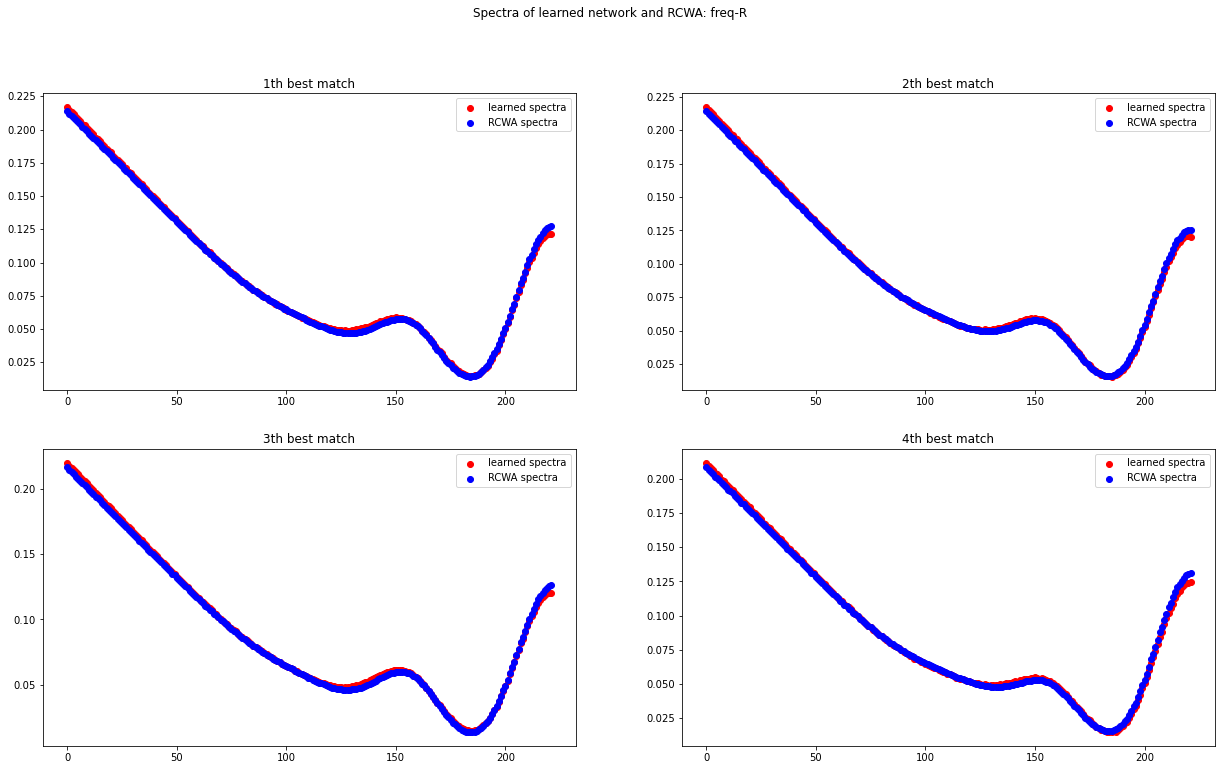

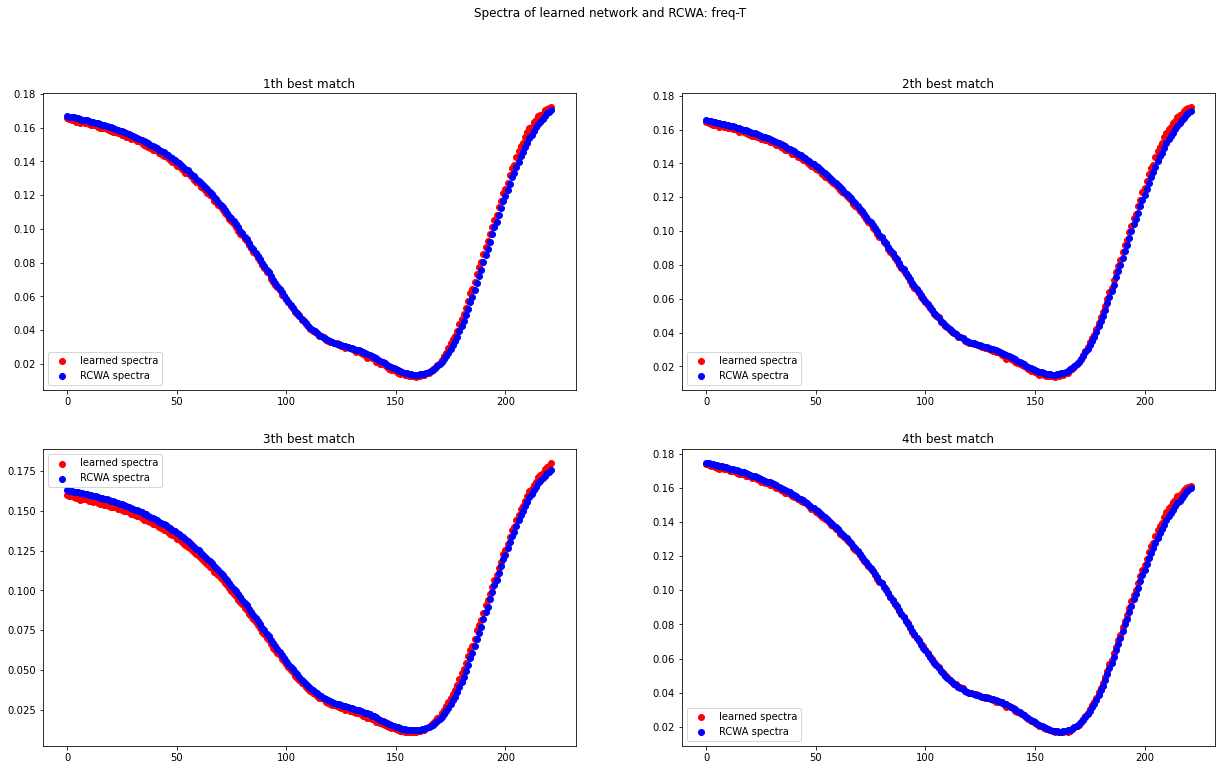

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 409
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [130.  70.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 66. 143.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [52. 82.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [72. 60.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 70. 141.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [131.  62.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [71. 96.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [115.  83.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [132.  73.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [80. 71.]
Calculation Progre

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [136. 142.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [97. 70.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 92. 117.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [123. 115.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [143.  98.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 52. 113.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [63. 56.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [103.  83.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [104. 114.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 81. 129.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [72. 65.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [53. 65.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00032523117016288865
### TEST LOSS  0.0004250280450963016
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.00012312360140840655
### TEST LOSS  9.026429013049762e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 7.758385499916268e-05
### TEST LOSS  0.00010750570280444143
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0001156729929251299
### TEST LOSS  0.0001579456459564556
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 8.700306254878433e-05
### TEST LOSS  0.0001688331041285502
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 8.883381252185901e-05
### TEST LOSS  3.12746300811081e-05
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 3.865433440210716e-06
### TEST LOSS  2.8093922017952925e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 2.859750940616525e-06
### TEST LOSS  1.8470132252852117e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.447088733684447e-06
### TEST LOSS  1.898484616244137e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 4.120112118609167e-06
### TEST LOSS  4.486540702990689e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.55745738659462e-05
### TEST LOSS  3.239516023053771e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 3.2904300186254277e-06
### TEST LOSS  1.923614279673659e-06
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.2104439344279752e-06
### TEST LOSS  3.352168862745332e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.4848035176141475e-06
### TEST LOSS  8.926598330357852e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.7960115376810084e-06
### TEST LOSS  1.2711547989446054e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 3.615693047133273e-06
### TEST LOSS  1.0296041474638123e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 3.2268485016330066e-06
### TEST LOSS  9.561947990732733e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 3.028140189966538e-06
### TEST LOSS  1.647186698911745e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.5056831826417969e-06
### TEST LOSS  1.8563477267109972e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.8380061000665257e-06
### TEST LOSS  6.809681118673845e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.9993318106379328e-06
### TEST LOSS  5.381328337859616e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.318218506626759e-06
### TEST LOSS  7.217852352628792e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.0830904486760527e-06
### TEST LOSS  1.325961940373028e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.1452957639828566e-06
### TEST LOSS  6.82184983296403e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.1983917445285574e-06
### TEST LOSS  1.1280387021932775e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 9.367230437685782e-07
### TEST LOSS  9.933584042950576e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.2250489921261382e-06
### TEST LOSS  5.739292946925291e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.365496161862369e-07
### TEST LOSS  4.989721844594897e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 7.885071115879884e-07
### TEST LOSS  1.1898993729378811e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.805571875331734e-07
### TEST LOSS  7.282402764628517e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 7.386362758683065e-07
### TEST LOSS  1.1363036216088013e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.314525911532807e-07
### TEST LOSS  3.562477672858222e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.929229345568353e-07
### TEST LOSS  7.25635840938464e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.042999566348645e-07
### TEST LOSS  4.645279838249345e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 8.697819796124681e-07
### TEST LOSS  5.766539987104937e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.030567260123669e-07
### TEST LOSS  4.2576591649127036e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 1.174186828271961e-06
### TEST LOSS  8.083294338640761e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 6.11286393656815e-07
### TEST LOSS  1.824034711717104e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 1.085381988521733e-06
### TEST LOSS  3.659163456047411e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 9.336985269555397e-07
### TEST LOSS  6.083855461318828e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 8.562799028637664e-07
### TEST LOSS  6.279187313599063e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.89346895036912e-07
### TEST LOSS  3.407220390272414e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 8.639073098903095e-07
### TEST LOSS  6.543163197290726e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 6.432626877344908e-07
### TEST LOSS  4.889242778257799e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 8.735729428048393e-07
### TEST LOSS  2.903452066708009e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.954593842593509e-07
### TEST LOSS  5.52186585472165e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.802643612916861e-07
### TEST LOSS  5.703617530018943e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.86599652442375e-07
### TEST LOSS  3.8750768080067897e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.788421662402275e-07
### TEST LOSS  4.537676708033749e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.0510824426072356e-07
### TEST LOSS  1.4998900123178567e-06
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 6.176925499794252e-07
### TEST LOSS  6.44045119965345e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.050897427314536e-07
### TEST LOSS  3.398548358291009e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.4172842913489237e-07
### TEST LOSS  3.354613430214418e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.4648856647295685e-07
### TEST LOSS  6.653425137821094e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.555884656869051e-07
### TEST LOSS  3.0349286004950825e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.5451101366633756e-07
### TEST LOSS  4.363479807320151e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.779562782651628e-07
### TEST LOSS  4.6182475240844466e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.313896506129451e-07
### TEST LOSS  3.0536114893818323e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.3349635677234616e-07
### TEST LOSS  4.316667343573499e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 6.138906072774406e-07
### TEST LOSS  4.0956437682585343e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.36416002581109e-07
### TEST LOSS  2.5933490275877246e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.666657546844163e-07
### TEST LOSS  5.220274691250129e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.567378757080196e-07
### TEST LOSS  5.873588406757335e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.114243056320027e-07
### TEST LOSS  4.7244606906003484e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 6.100601859444298e-07
### TEST LOSS  5.798594356422524e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.830237722166287e-07
### TEST LOSS  2.3427230035265113e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.3975208192482947e-07
### TEST LOSS  3.190791042178327e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.3807789952385835e-07
### TEST LOSS  2.1191549137711263e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.4932266718395506e-07
### TEST LOSS  6.254988582960712e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.964364244131048e-07
### TEST LOSS  7.104684170501839e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.5540645410671374e-07
### TEST LOSS  2.2641389258686623e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 5.536845216402527e-07
### TEST LOSS  1.5933861935276842e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.367840322122784e-07
### TEST LOSS  4.305004698120943e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.838229969920956e-07
### TEST LOSS  4.6120085325388314e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 6.111846982701203e-07
### TEST LOSS  3.596065149784928e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.293685963492838e-07
### TEST LOSS  3.217545798049416e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.989758176996006e-07
### TEST LOSS  2.542419313808101e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.851046362239731e-07
### TEST LOSS  3.6703889959101487e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.8567553530905967e-07
### TEST LOSS  2.9424224732922865e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.9576030232998443e-07
### TEST LOSS  2.3162421111270044e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.9701368761579154e-07
### TEST LOSS  4.137906565964451e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.4779936104934257e-07
### TEST LOSS  6.730080924301416e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.2438955301542053e-07
### TEST LOSS  2.751033605363773e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.024055136245546e-07
### TEST LOSS  1.1824746804580042e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.6119502915032664e-07
### TEST LOSS  2.2856628082276336e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.3933410071311175e-07
### TEST LOSS  2.592956726792701e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.7334998282277835e-07
### TEST LOSS  1.9676114350529262e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.259555701732615e-07
### TEST LOSS  1.8845126500569416e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.847016664169835e-07
### TEST LOSS  2.480828352905259e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.1445808464726797e-07
### TEST LOSS  2.1897361485961093e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.9366537409800956e-07
### TEST LOSS  5.532030676087223e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.618793505526167e-07
### TEST LOSS  4.899897224471975e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.353180162397107e-07
### TEST LOSS  2.0972422021259263e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.4220037694208387e-06
### TEST LOSS  7.946393582512559e-06
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.172224650342705e-06
### TEST LOSS  1.5527379641103574e-06
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 1.0087818582905315e-06
### TEST LOSS  5.971727391949701e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.5114033576846953e-07
### TEST LOSS  3.9019119770143463e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.2543331595512317e-07
### TEST LOSS  2.7759820194920136e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.0710159964826986e-07
### TEST LOSS  2.84089430075645e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.487891122827723e-07
### TEST LOSS  3.3673833854663826e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.5189036777671726e-07
### TEST LOSS  2.0923607329288124e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.520614805040226e-07
### TEST LOSS  4.804173678556773e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.980347280155348e-07
### TEST LOSS  1.81697905483296e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.25596086593956e-07
### TEST LOSS  1.7029862168068837e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.3989557146100377e-07
### TEST LOSS  2.0065818010347618e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.583313659486207e-07
### TEST LOSS  1.6469680425806083e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.911353552369296e-07
### TEST LOSS  4.94312705054004e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.028538771311593e-07
### TEST LOSS  3.2938719536040093e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.390096207447912e-07
### TEST LOSS  1.6472871777750697e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.855657517744467e-07
### TEST LOSS  2.909996875847095e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.645749948146214e-07
### TEST LOSS  3.4131725052637716e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.955438863831532e-07
### TEST LOSS  6.209574061293617e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.0342837942422153e-07
### TEST LOSS  3.7224107123685304e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.5113091480104216e-07
### TEST LOSS  1.74525179578008e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.8956558806848865e-07
### TEST LOSS  2.746394228227343e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.501806100812872e-07
### TEST LOSS  2.2587016092399737e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.457990441230923e-07
### TEST LOSS  2.1056425225651765e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.4356282405985343e-07
### TEST LOSS  2.895553247331658e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.393926984428772e-07
### TEST LOSS  3.8670625355864884e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.07007404978276e-07
### TEST LOSS  2.191970135559781e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.1515579506778682e-07
### TEST LOSS  1.4975075706453416e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.3393369991687976e-07
### TEST LOSS  1.5740526951698745e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 5.237116008385963e-07
### TEST LOSS  1.0405317506670793e-06
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.187097697561111e-07
### TEST LOSS  2.65948585820297e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.4893573446549303e-07
### TEST LOSS  1.7223615194390212e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.812748550259633e-07
### TEST LOSS  9.179505338709402e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.220640586383252e-07
### TEST LOSS  1.3193462982436748e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.0723013440972592e-07
### TEST LOSS  1.4696605684808413e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.194855552335087e-07
### TEST LOSS  2.359970656990689e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.0378693489774494e-07
### TEST LOSS  1.5807169972958945e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.1363438031050168e-07
### TEST LOSS  1.9992484112663078e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.1963764485612156e-07
### TEST LOSS  2.3085413910653836e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.1675264690518077e-07
### TEST LOSS  1.4034334684863226e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 1.717991741022468e-07
### TEST LOSS  1.5732530097726079e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.0761225193235373e-07
### TEST LOSS  2.9074328722344944e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.581838110346411e-07
### TEST LOSS  2.620967945534046e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.457719042614221e-07
### TEST LOSS  1.378052404886278e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 1.943953764969107e-07
### TEST LOSS  1.4065470363025918e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.888636595856997e-07
### TEST LOSS  1.8993725145069869e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.0824987333492034e-07
### TEST LOSS  1.6297248553850556e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.8058272912330022e-07
### TEST LOSS  2.8108404543607843e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.0137376366033635e-07
### TEST LOSS  7.572607825880238e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.3759091930050365e-07
### TEST LOSS  3.1913518837102727e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.0822214060872605e-07
### TEST LOSS  1.5620095236304872e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.1617381879232927e-07
### TEST LOSS  2.0540976614873735e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.9999578837144985e-07
### TEST LOSS  1.3392891215094744e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.8624665358124163e-07
### TEST LOSS  1.2357075210697337e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.841661475817595e-07
### TEST LOSS  1.8376454948208577e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.2501346589844798e-07
### TEST LOSS  2.509210515557113e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.3654718165542748e-07
### TEST LOSS  4.504507882886953e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.16071840122322e-07
### TEST LOSS  4.2286963061347447e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.341548316307435e-07
### TEST LOSS  1.7686774762231445e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.1926971200757562e-07
### TEST LOSS  2.993354298398897e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.596157401744229e-07
### TEST LOSS  2.2597719708171227e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.4419701210776e-07
### TEST LOSS  1.7460402749033426e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.7992575168999e-07
### TEST LOSS  1.6568895741134577e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.2336162140623402e-07
### TEST LOSS  1.8725694417298655e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.6898375077639285e-07
### TEST LOSS  4.0964196809259844e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.2232679627763112e-07
### TEST LOSS  3.0531468350350875e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.3625553156314103e-07
### TEST LOSS  1.9035699543629952e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.3258151448018133e-07
### TEST LOSS  1.2542686127809638e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.260300857495046e-07
### TEST LOSS  4.1067532460406906e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 1.8191971932563148e-07
### TEST LOSS  1.7184816109810136e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.97971955338749e-07
### TEST LOSS  2.609074475198473e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.943450054752402e-07
### TEST LOSS  3.0686872167150015e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.8098639921386266e-07
### TEST LOSS  2.4835583596021546e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.408043551683512e-07
### TEST LOSS  3.057844862399049e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.0410473875679393e-07
### TEST LOSS  1.813723368318928e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.7613345480947568e-07
### TEST LOSS  1.8535496337790391e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.7148972986564423e-07
### TEST LOSS  2.0038200635294094e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.1663521882542416e-07
### TEST LOSS  1.9759097824589844e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.2382031656469983e-07
### TEST LOSS  1.444353269367379e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.5303398703434226e-07
### TEST LOSS  1.302887245710086e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 1.649445440216424e-07
### TEST LOSS  1.3002888822809056e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.4881099870560305e-07
### TEST LOSS  2.450855102357049e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.1176509475286286e-07
### TEST LOSS  1.2131829610747706e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.2151203951570927e-07
### TEST LOSS  1.506162448094983e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.8697916882611682e-07
### TEST LOSS  1.980812527335729e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.0990397656257693e-07
### TEST LOSS  1.784417276797155e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.6849424123371423e-07
### TEST LOSS  1.1548681198649189e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.8875390684416736e-07
### TEST LOSS  1.382199172894616e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.9959218543499363e-07
### TEST LOSS  1.927897942875591e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.0715567076882192e-07
### TEST LOSS  1.64765576674394e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.1126138908780104e-07
### TEST LOSS  8.743895461650806e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.22796627286828e-07
### TEST LOSS  1.819028158576787e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.990858170501181e-07
### TEST LOSS  1.3432640498324743e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.2068211971968827e-07
### TEST LOSS  1.659134615091976e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.022992502949873e-07
### TEST LOSS  1.5386537808938427e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.9597052395517938e-07
### TEST LOSS  2.2234610038854692e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.5912270346459587e-07
### TEST LOSS  1.6324253644078063e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.723063016559979e-07
### TEST LOSS  1.397028991537549e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.7574240557355986e-07
### TEST LOSS  1.3069661365859376e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.553961837317584e-07
### TEST LOSS  1.4215897843022113e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.9641552519179976e-07
### TEST LOSS  2.810130155239676e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.053471165757007e-07
### TEST LOSS  1.0106803419570756e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.4986007728209994e-07
### TEST LOSS  2.7442287578846193e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.7181939804212898e-07
### TEST LOSS  1.1283549637499033e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.7835373096257233e-07
### TEST LOSS  1.4073757118434775e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 1.7909225888001327e-07
### TEST LOSS  1.4841108963992156e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.7205014084542315e-07
### TEST LOSS  1.018838494206063e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.904943782004468e-07
### TEST LOSS  1.3613207780086407e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.578779436464204e-07
### TEST LOSS  1.0200002265037256e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.1102282689633813e-07
### TEST LOSS  1.4212518603276943e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.086050112284767e-07
### TEST LOSS  3.1795854787170743e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.1460143903699782e-07
### TEST LOSS  1.7719269911659857e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.7396565279334077e-07
### TEST LOSS  9.422983993090384e-08
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.793710325481131e-07
### TEST LOSS  1.9718869940074262e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.7043400872622993e-07
### TEST LOSS  3.166794207183037e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.6931347275143693e-07
### TEST LOSS  1.7021812327909303e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 1.5170816745416712e-07
### TEST LOSS  1.419088379504631e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.0374047064069017e-07
### TEST LOSS  2.5658877283214157e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 1.7841735424036766e-07
### TEST LOSS  9.442633950941723e-08
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.811781219330628e-07
### TEST LOSS  1.1838097943187417e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.600116092177299e-07
### TEST LOSS  1.0783346482412526e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.6336847726613552e-07
### TEST LOSS  1.144321737050242e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.673752852914129e-07
### TEST LOSS  1.2803304270749193e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 3.11112985132307e-07
### TEST LOSS  2.6270708782963735e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.6065609342540294e-07
### TEST LOSS  1.9113038060173233e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.047990264199894e-07
### TEST LOSS  1.6023433297667517e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.6474601256576536e-07
### TEST LOSS  2.045064186566898e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.498913313776065e-07
### TEST LOSS  1.8065283110705162e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.7065093829209166e-07
### TEST LOSS  1.651069802781941e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.4863095495468342e-07
### TEST LOSS  1.4187147253811157e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.7779626340607632e-07
### TEST LOSS  9.955403409581517e-08
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.850320107510243e-07
### TEST LOSS  1.0752387424872722e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.5588112995674442e-07
### TEST LOSS  1.1219443710582969e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.3557368759389185e-07
### TEST LOSS  9.387076614432641e-08
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.852034516011307e-07
### TEST LOSS  1.5513987250415084e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.8762371670871952e-07
### TEST LOSS  1.793736288391301e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 1.4137024416956415e-07
### TEST LOSS  1.0905792789474487e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.6193240102804105e-07
### TEST LOSS  1.4332480954440792e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.2759286180935702e-07
### TEST LOSS  1.4777357953172604e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.6600635825177217e-07
### TEST LOSS  1.5967850280113843e-07
** loss_train 1.6600635825177217e-07
** loss_test 1.5967850280113843e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


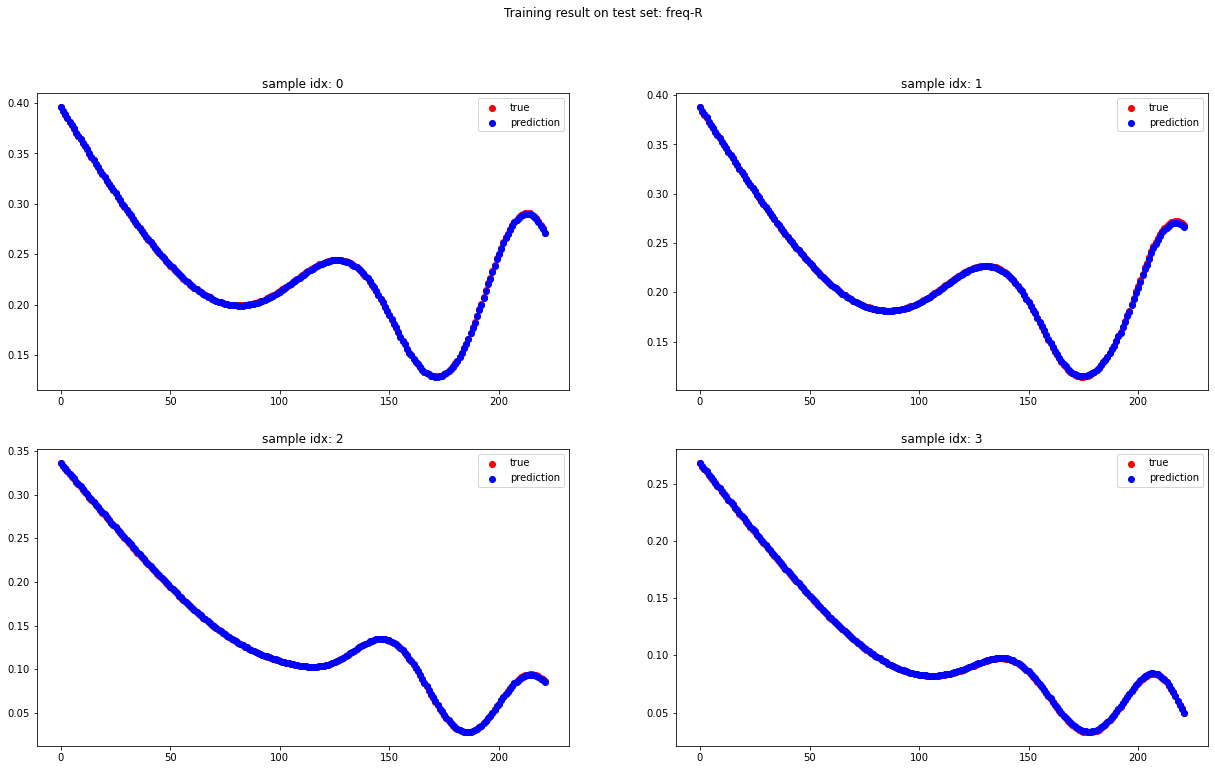

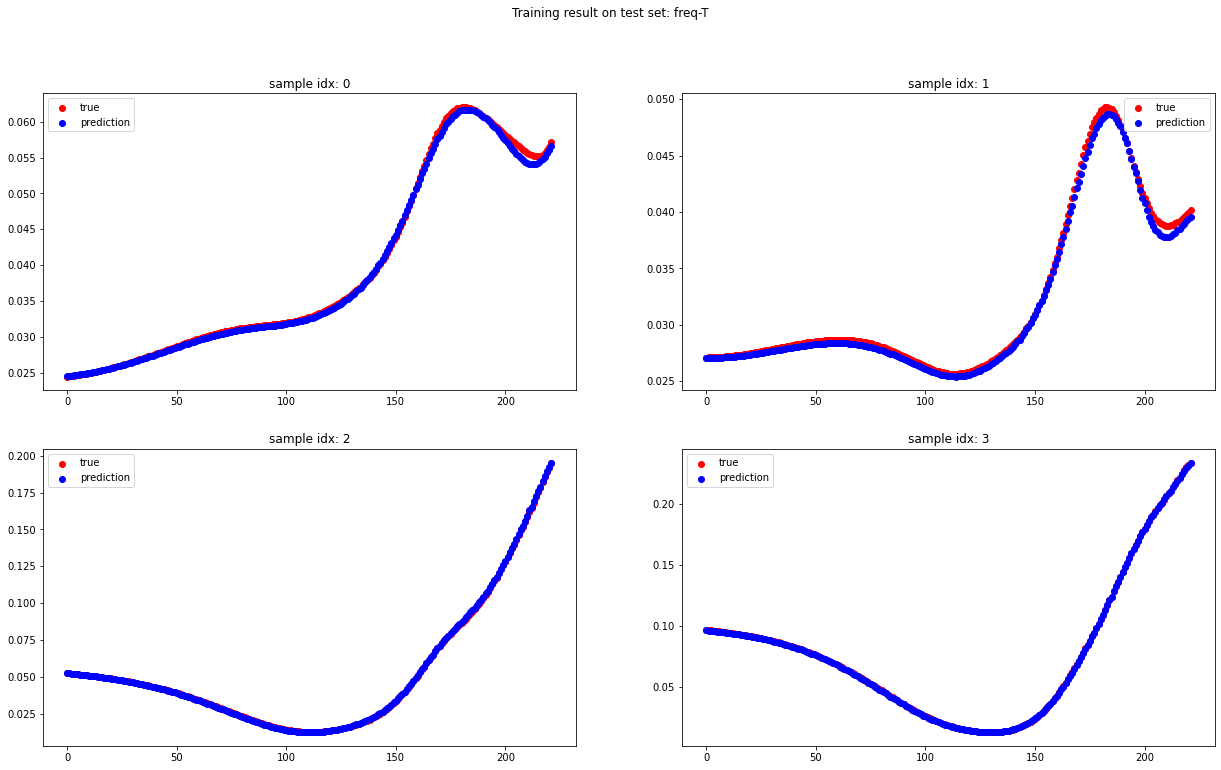

params_pick.shape: (10, 4)
params_pick: [[146. 120. 160.  75.]
 [145. 121. 160.  75.]
 [146. 121. 160.  75.]
 [145. 120. 160.  75.]
 [145. 122. 160.  75.]
 [146. 119. 160.  75.]
 [146. 122. 160.  75.]
 [147. 120. 160.  75.]
 [147. 121. 160.  75.]
 [145. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


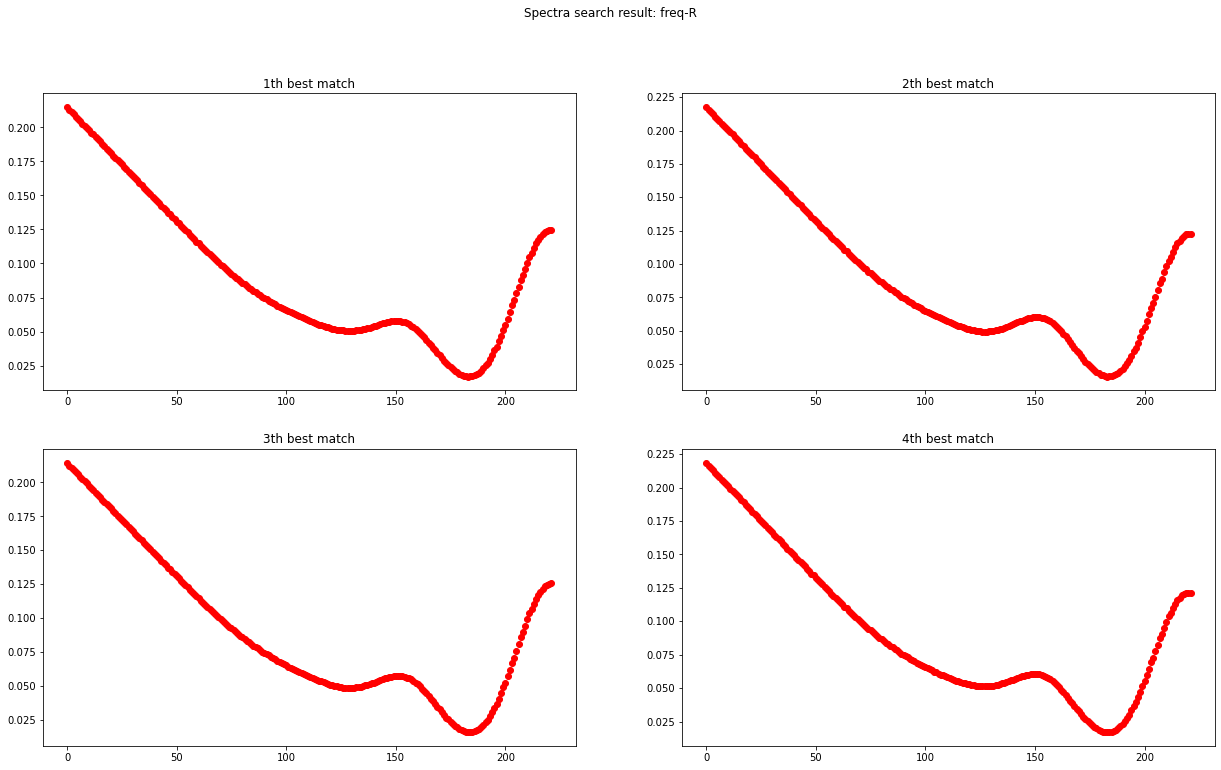

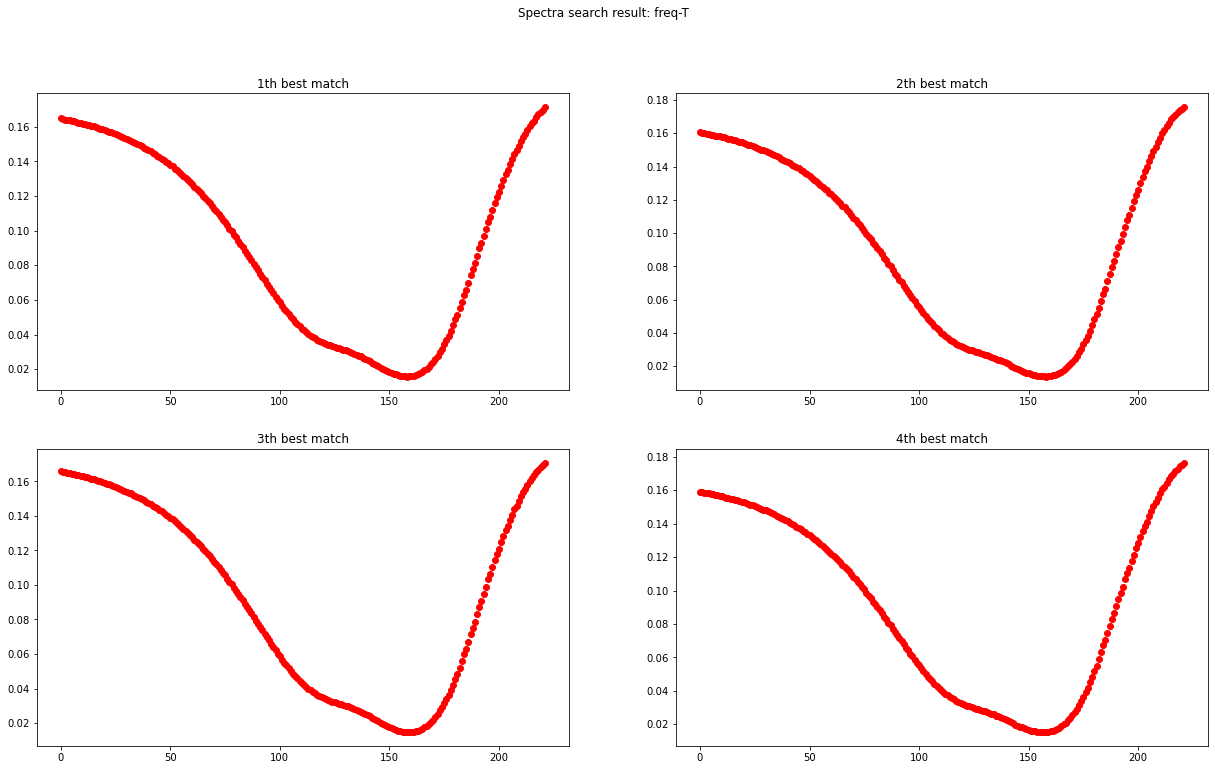

*** Reruning RCWA on picked params
params_dict.shape: (409, 4)
R_dict.shape: (409, 222)
T_dict.shape: (409, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [145. 120. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
6 th match
Not in the dict, calling RCWA...
# params_pick: [146. 119. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
7 th match
Already i

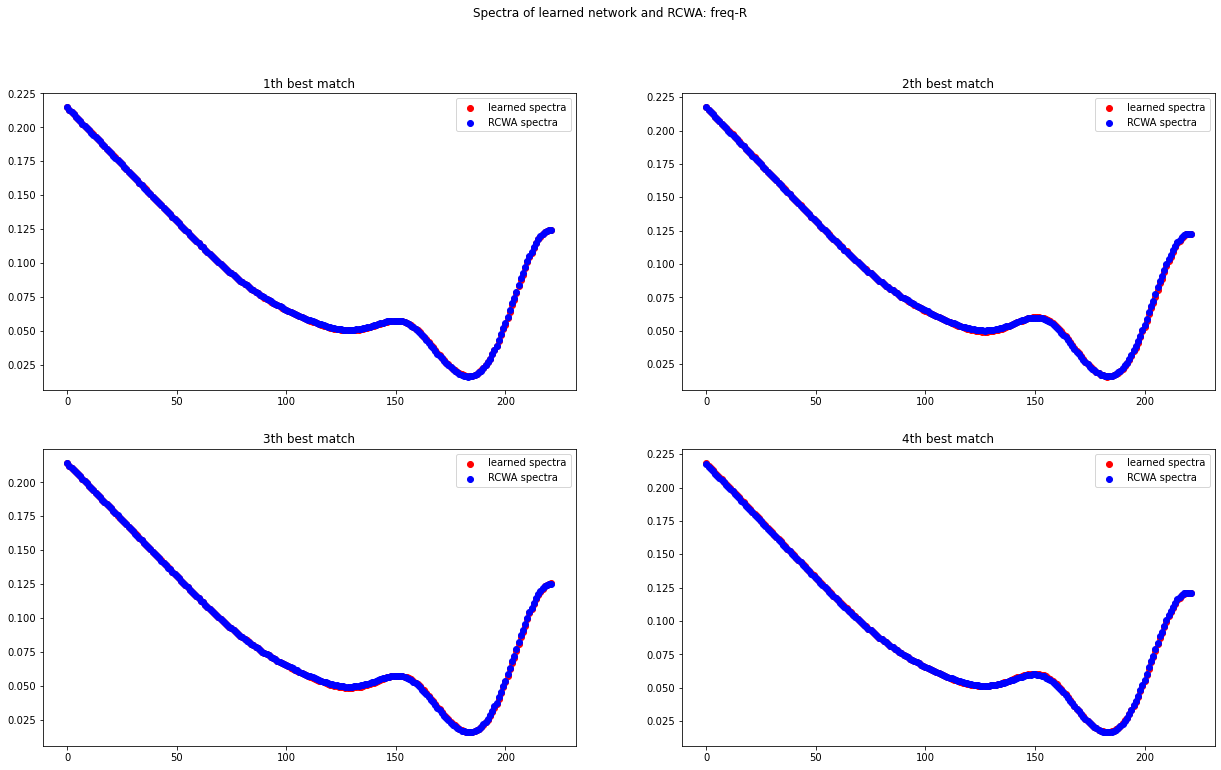

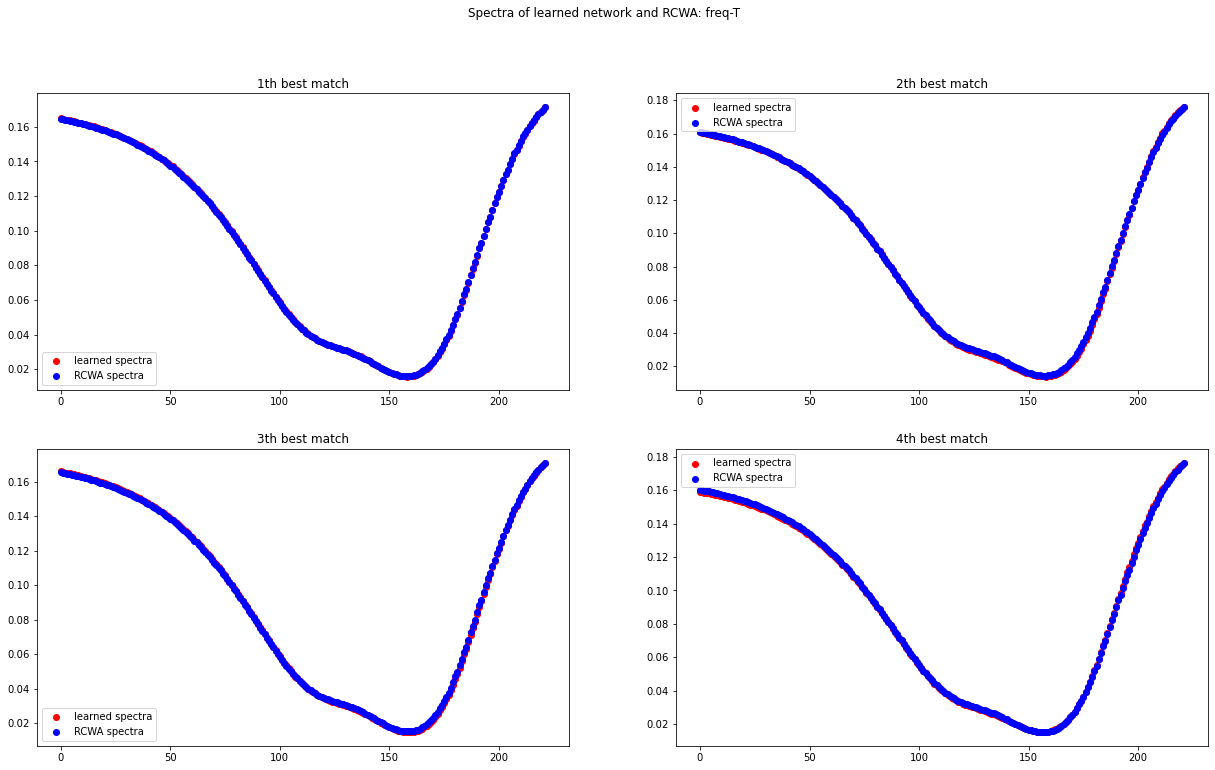

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 612
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [54. 89.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [89. 74.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [67. 79.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [101. 138.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [125. 109.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 50. 138.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [119.  97.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [89. 82.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [111. 101.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [80. 61.]
Calculation Progress

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [123.  84.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [69. 65.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [128.  55.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [143. 106.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [137.  66.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [105. 103.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [96. 72.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [129. 106.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [140. 143.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [126.  91.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [103.  62.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [128. 106.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00012306123928247675
### TEST LOSS  0.00029480860248440874
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 5.5253554896035284e-05
### TEST LOSS  4.0632818854646755e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 5.047960793054919e-05
### TEST LOSS  5.888054729439318e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 3.0586073652634666e-05
### TEST LOSS  1.7080921497836244e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 8.424615206202516e-05
### TEST LOSS  3.1919839693728135e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 5.637870582686862e-05
### TEST LOSS  8.028741212910973e-05
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 4.230017506765955e-06
### TEST LOSS  3.3689715792206696e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.9674470406903775e-06
### TEST LOSS  1.7179260680677544e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.7539565048688996e-06
### TEST LOSS  2.684587320800347e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.374896154661348e-06
### TEST LOSS  2.0852764805567857e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.4103495082272645e-06
### TEST LOSS  1.614901054836082e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.727103436679092e-06
### TEST LOSS  6.733051623086794e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 6.950437713127303e-06
### TEST LOSS  1.833328660723055e-05
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 2.9347970728305846e-06
### TEST LOSS  7.208501119748689e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 4.562492759590832e-06
### TEST LOSS  1.5227478172619157e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.8503266925739099e-06
### TEST LOSS  1.1257287326316146e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.4791279308992983e-06
### TEST LOSS  1.1233176223868214e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.7804233355944939e-06
### TEST LOSS  1.4756186601516674e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.542051595098547e-06
### TEST LOSS  6.61249691802368e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.1131829815641138e-06
### TEST LOSS  7.840101261535892e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.170186078905962e-06
### TEST LOSS  9.724591109261383e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 9.043970328483295e-07
### TEST LOSS  7.178030330123875e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.457375737542954e-07
### TEST LOSS  7.695408271501947e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.826646752278994e-07
### TEST LOSS  1.4713261407450772e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.597958451488453e-07
### TEST LOSS  5.401163633678153e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 7.93780368099501e-07
### TEST LOSS  4.87374074964464e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.863626150802248e-07
### TEST LOSS  5.126549098122269e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 1.1333727575850774e-06
### TEST LOSS  6.322481453935325e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 8.817655010856844e-07
### TEST LOSS  7.554774981599621e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.840393004421826e-07
### TEST LOSS  6.913180015999387e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 7.019577681590919e-07
### TEST LOSS  5.488582758061966e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 7.165945688049628e-07
### TEST LOSS  5.476555685390849e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 9.237765967017838e-07
### TEST LOSS  1.0793385456508986e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 1.199685756703078e-06
### TEST LOSS  4.594692910586673e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 7.82520490235704e-07
### TEST LOSS  5.892523290640383e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 7.252722958212253e-07
### TEST LOSS  3.746470866872187e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 6.577618608621104e-07
### TEST LOSS  6.034658952103201e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.7041079640636e-07
### TEST LOSS  6.65104562358465e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 6.099898591525233e-07
### TEST LOSS  7.321664611481537e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.530291482332965e-07
### TEST LOSS  4.467476372838064e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.944109796229493e-07
### TEST LOSS  4.79284810239733e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.956947052407946e-07
### TEST LOSS  4.133409163387114e-07
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.972675847308189e-07
### TEST LOSS  7.473441826277849e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.945645788576148e-07
### TEST LOSS  5.335604015499484e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 7.543467938837838e-07
### TEST LOSS  4.283791497528e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.473502646349683e-07
### TEST LOSS  6.066091771117499e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 6.943591830312422e-07
### TEST LOSS  4.4737916482517903e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.566100652051022e-07
### TEST LOSS  5.738186615644736e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 1.7908158509104928e-06
### TEST LOSS  9.60829834184551e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 1.382614951016787e-06
### TEST LOSS  8.898643727661692e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.0606240795148156e-06
### TEST LOSS  1.7471593082518667e-06
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.2843138833798913e-06
### TEST LOSS  2.8546156272568625e-06
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 1.9455502675046933e-06
### TEST LOSS  1.4769790936952631e-06
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 1.8966392513582347e-06
### TEST LOSS  1.0835681962362287e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 9.408262618295811e-07
### TEST LOSS  2.399629067895148e-06
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 1.6266135347713141e-06
### TEST LOSS  1.2232693052283139e-06
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.6074039199869316e-06
### TEST LOSS  1.7918556750373681e-06
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 1.820432507807944e-06
### TEST LOSS  7.13317672307312e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 9.779158123279785e-07
### TEST LOSS  6.21472841544346e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 1.0787407247499097e-06
### TEST LOSS  1.0874888005218964e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 9.741278140416947e-06
### TEST LOSS  2.155252457214374e-06
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.8643966307184905e-06
### TEST LOSS  3.5860580965163537e-06
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 1.9661634439718055e-06
### TEST LOSS  7.132265466225362e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 1.2003573579468316e-06
### TEST LOSS  9.373792437372686e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 8.874443419313287e-07
### TEST LOSS  5.075337440985095e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 9.357845205596467e-07
### TEST LOSS  5.679116384271765e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 7.594302017686842e-07
### TEST LOSS  7.059963593292196e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 7.933175807717966e-07
### TEST LOSS  1.0729896246175486e-06
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 1.0107579951690823e-06
### TEST LOSS  5.240363606162646e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 7.988656990416123e-07
### TEST LOSS  7.829415494597925e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 7.990521876584634e-07
### TEST LOSS  5.49450646758487e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 6.911079254906345e-07
### TEST LOSS  5.529489271793864e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 6.601391113689416e-07
### TEST LOSS  1.1954150181736622e-06
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 6.079479975243077e-07
### TEST LOSS  4.354763234459824e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 7.281616578954428e-07
### TEST LOSS  5.084728826432184e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 7.002851004031548e-07
### TEST LOSS  7.597632020406308e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 6.701621255551747e-07
### TEST LOSS  5.42110350920666e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 6.900774309106256e-07
### TEST LOSS  1.783037760105799e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 8.074082545673164e-07
### TEST LOSS  1.0463698458806903e-06
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 7.677809786055982e-07
### TEST LOSS  5.57819770392598e-06
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 9.469310623291217e-07
### TEST LOSS  6.450963979887092e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 7.21934748055108e-07
### TEST LOSS  8.24558861722835e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 5.93166986459957e-07
### TEST LOSS  6.886207728484806e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 6.735765657599682e-07
### TEST LOSS  4.7155801041753875e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 5.920513171020419e-07
### TEST LOSS  3.658713524146151e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 5.513359390351738e-07
### TEST LOSS  3.6031883041687254e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 5.478938397179072e-07
### TEST LOSS  4.382508080880143e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 5.481997476095176e-07
### TEST LOSS  4.778090413992687e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 5.40784104195733e-07
### TEST LOSS  3.944545511558317e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 6.191766978177754e-07
### TEST LOSS  6.005862474012247e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 6.265917025616152e-07
### TEST LOSS  5.509294595640313e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 6.096640967115356e-07
### TEST LOSS  5.004979016121069e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 5.397663295729829e-07
### TEST LOSS  3.3025095831362704e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 5.449005772840593e-07
### TEST LOSS  4.027398915695812e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.6486559999794444e-07
### TEST LOSS  5.458286807424883e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 5.106059892809486e-07
### TEST LOSS  1.4075321473683288e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 8.448498129061644e-07
### TEST LOSS  4.3244410079523733e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 5.346259016262078e-07
### TEST LOSS  1.0367379161380086e-06
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.955412868774776e-07
### TEST LOSS  6.062447965859974e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 6.138501232550866e-07
### TEST LOSS  1.3380271184360026e-06
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 7.052925500563389e-07
### TEST LOSS  5.056160773619922e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 5.242692278505473e-07
### TEST LOSS  3.9813833723201243e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 5.366218374059688e-07
### TEST LOSS  4.4234744791538103e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.929457167337677e-07
### TEST LOSS  1.0707678143262457e-06
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 5.405613488042586e-07
### TEST LOSS  3.2337092932266386e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 7.660007426324371e-07
### TEST LOSS  5.967790173144749e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.0479258484120354e-06
### TEST LOSS  1.1852657451072446e-06
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 6.804355221548306e-07
### TEST LOSS  3.940790236356406e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.821858348593896e-07
### TEST LOSS  3.5895633345717213e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 5.315529181434257e-07
### TEST LOSS  6.09510593108098e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 6.098725238926417e-07
### TEST LOSS  2.2205312461665015e-06
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 6.538591169504793e-07
### TEST LOSS  3.5237709994362376e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 5.307452393510236e-07
### TEST LOSS  2.3712953179710893e-06
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 6.924452342583525e-07
### TEST LOSS  8.200755132747872e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 4.245051224060975e-07
### TEST LOSS  2.963899120800306e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 6.715118683563615e-07
### TEST LOSS  3.4568532214507286e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 4.124125883209134e-07
### TEST LOSS  4.1321961532503335e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.387790698622078e-07
### TEST LOSS  1.2054609555889328e-06
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.102043889343158e-07
### TEST LOSS  9.613119175355679e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 5.349212273944055e-07
### TEST LOSS  3.551415261426882e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 5.4911268785840615e-06
### TEST LOSS  4.67358752302971e-06
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 8.293870359010891e-06
### TEST LOSS  9.924963751473116e-06
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.849526207725755e-06
### TEST LOSS  3.1070769523466877e-06
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.7018608219815198e-06
### TEST LOSS  1.3293444908413222e-06
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.311986577650575e-06
### TEST LOSS  1.5405086969622062e-06
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 7.717840866438248e-07
### TEST LOSS  7.228305690887282e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 4.621257371312212e-07
### TEST LOSS  3.7565716866083675e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.28609566783789e-07
### TEST LOSS  3.5161108229431194e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 5.198205223942428e-07
### TEST LOSS  3.3086956818806357e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.6186687855830016e-07
### TEST LOSS  3.1775848015058726e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 4.836013382978895e-07
### TEST LOSS  4.054075418480352e-07
----------------------------------------------------------------------
*** EPOCH 1119 || AVG LOSS 4.822033094621276e-07
### TEST LOSS  3.0653607154818017e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 4.4101906286084763e-07
### TEST LOSS  3.3190020189977074e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 4.412310476377113e-07
### TEST LOSS  4.965373761933734e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 4.5672299592545993e-07
### TEST LOSS  2.6055976007910433e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 4.5971301616847825e-07
### TEST LOSS  4.142510874771688e-07
----------------------------------------------------------------------
*** EPOCH 1171 || AVG LOSS 5.141045841065594e-07
### TEST LOSS  2.687290276526255e-07
----------------------------------------------------------------------
*** EPOCH 1172 || AVG LOSS 4.2509323198166065e-07
### TEST LOSS  6.467765388151747e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 4.939295152346746e-07
### TEST LOSS  2.372215405443967e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.89555412673038e-07
### TEST LOSS  4.998889636453896e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 4.535040092941087e-07
### TEST LOSS  2.87145637400954e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 4.626334561454742e-07
### TEST LOSS  2.65696252199632e-07
----------------------------------------------------------------------
*** EPOCH 1223 || AVG LOSS 4.335252589566375e-07
### TEST LOSS  5.042519092057774e-07
----------------------------------------------------------------------
*** EPOCH 1224 || AVG LOSS 3.8497249929928686e-07
### TEST LOSS  2.534290260314265e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 5.236513040004781e-07
### TEST LOSS  3.1621201515008577e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 4.379461211224511e-07
### TEST LOSS  3.7484863639747347e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 4.975443047249233e-07
### TEST LOSS  4.446837692739791e-07
----------------------------------------------------------------------
*** EPOCH 1275 || AVG LOSS 4.37744800982517e-07
### TEST LOSS  4.093781001301977e-07
----------------------------------------------------------------------
*** EPOCH 1276 || AVG LOSS 3.790201821067731e-07
### TEST LOSS  2.685142433733745e-07
----------------------------------------------------------------------
*** EPOCH 1277 || AVG LOSS 5.423356809451671e-07
### TEST LOSS  5.190852391478984e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 4.926915043150415e-07
### TEST LOSS  3.10217205878871e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.84169735918463e-07
### TEST LOSS  5.069693770565209e-07
----------------------------------------------------------------------
*** EPOCH 1327 || AVG LOSS 4.4220895497306706e-07
### TEST LOSS  2.4787217824950856e-07
----------------------------------------------------------------------
*** EPOCH 1328 || AVG LOSS 4.894360107380756e-07
### TEST LOSS  2.9307513642606865e-07
----------------------------------------------------------------------
*** EPOCH 1329 || AVG LOSS 3.891308292294981e-07
### TEST LOSS  3.466474424840271e-07
----------------------------------------------------------------------
*** EPOCH 1330 || AVG LOSS 4.443440416774526e-07
### TEST LOSS  5.995002567260599e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.960662572638387e-07
### TEST LOSS  6.298567114981779e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 4.314707068610086e-07
### TEST LOSS  2.6599820728279157e-07
----------------------------------------------------------------------
*** EPOCH 1379 || AVG LOSS 3.4429266528523236e-07
### TEST LOSS  2.5047507961062366e-07
----------------------------------------------------------------------
*** EPOCH 1380 || AVG LOSS 4.296653817167293e-07
### TEST LOSS  3.5081295806094205e-07
----------------------------------------------------------------------
*** EPOCH 1381 || AVG LOSS 4.109869131496763e-07
### TEST LOSS  2.644280044705738e-07
----------------------------------------------------------------------
*** EPOCH 1382 || AVG LOSS 3.947898953225009e-07
### TEST LOSS  4.204175553468303e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.782886995198528e-07
### TEST LOSS  5.413481261484776e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 4.0694544046520416e-07
### TEST LOSS  2.675882356584225e-07
----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 3.8639510552382947e-07
### TEST LOSS  2.9453256331635205e-07
----------------------------------------------------------------------
*** EPOCH 1432 || AVG LOSS 3.815460230113973e-07
### TEST LOSS  3.3393630758382644e-07
----------------------------------------------------------------------
*** EPOCH 1433 || AVG LOSS 4.4419287774495565e-07
### TEST LOSS  2.924690704730892e-07
----------------------------------------------------------------------
*** EPOCH 1434 || AVG LOSS 3.499325471597512e-07
### TEST LOSS  3.3668343064618965e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.421303491029151e-07
### TEST LOSS  3.168388914787101e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.700844231504693e-07
### TEST LOSS  2.880361137158616e-07
----------------------------------------------------------------------
*** EPOCH 1483 || AVG LOSS 5.703357767818606e-07
### TEST LOSS  2.790245162032079e-07
----------------------------------------------------------------------
*** EPOCH 1484 || AVG LOSS 4.3620076714346047e-07
### TEST LOSS  4.774405908847256e-07
----------------------------------------------------------------------
*** EPOCH 1485 || AVG LOSS 4.0174912703192194e-07
### TEST LOSS  4.812518710650692e-07
----------------------------------------------------------------------
*** EPOCH 1486 || AVG LOSS 4.550824690564247e-07
### TEST LOSS  3.470589433618443e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.287807581684135e-07
### TEST LOSS  2.45063397130707e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.984942109683018e-07
### TEST LOSS  2.372396281202782e-07
----------------------------------------------------------------------
*** EPOCH 1535 || AVG LOSS 3.515558626490431e-07
### TEST LOSS  2.409787413171216e-07
----------------------------------------------------------------------
*** EPOCH 1536 || AVG LOSS 4.359479137886487e-07
### TEST LOSS  3.7269300037223727e-07
----------------------------------------------------------------------
*** EPOCH 1537 || AVG LOSS 3.6066997393897495e-07
### TEST LOSS  7.496961529795953e-07
----------------------------------------------------------------------
*** EPOCH 1538 || AVG LOSS 4.1087480061691127e-07
### TEST LOSS  3.2663253364262345e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.59667628565969e-07
### TEST LOSS  2.7314652157883755e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 4.3802084141340786e-07
### TEST LOSS  2.899892820096284e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 3.632192168182202e-07
### TEST LOSS  3.8426793480539345e-07
----------------------------------------------------------------------
*** EPOCH 1588 || AVG LOSS 3.7311172334458183e-07
### TEST LOSS  2.0095358053140444e-07
----------------------------------------------------------------------
*** EPOCH 1589 || AVG LOSS 4.0648860884111337e-07
### TEST LOSS  3.500586814197959e-07
----------------------------------------------------------------------
*** EPOCH 1590 || AVG LOSS 3.506540601412834e-07
### TEST LOSS  2.537470649599527e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 4.0362368227062525e-07
### TEST LOSS  2.514970830702623e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.409159213375931e-07
### TEST LOSS  4.84202953998647e-07
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 3.809579051984146e-07
### TEST LOSS  2.1478586376133535e-07
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 4.1540746920740985e-07
### TEST LOSS  3.060885049421813e-07
----------------------------------------------------------------------
*** EPOCH 1641 || AVG LOSS 3.270114110769152e-07
### TEST LOSS  5.834082742239844e-07
----------------------------------------------------------------------
*** EPOCH 1642 || AVG LOSS 3.438365898637947e-07
### TEST LOSS  2.660856225134012e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.950413808303006e-07
### TEST LOSS  3.295419418236634e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.395207855630756e-07
### TEST LOSS  2.5165416275285677e-07
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 3.4992290158855395e-07
### TEST LOSS  3.212777215821916e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 3.7460699174169956e-07
### TEST LOSS  2.4647566618796193e-07
----------------------------------------------------------------------
*** EPOCH 1693 || AVG LOSS 3.9350481569518553e-07
### TEST LOSS  2.8250668719920214e-07
----------------------------------------------------------------------
*** EPOCH 1694 || AVG LOSS 3.231560919947798e-07
### TEST LOSS  2.279515911141061e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.4524741746088127e-07
### TEST LOSS  3.0894564702066417e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.4451159606432985e-07
### TEST LOSS  3.3393359046840485e-07
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 4.0934474697321486e-07
### TEST LOSS  2.94531466238368e-07
----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 3.1049516422018205e-07
### TEST LOSS  2.169468700685684e-07
----------------------------------------------------------------------
*** EPOCH 1745 || AVG LOSS 2.8353787637304896e-07
### TEST LOSS  2.242970907673225e-07
----------------------------------------------------------------------
*** EPOCH 1746 || AVG LOSS 3.815696988700565e-07
### TEST LOSS  2.696145998015709e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.132405504827346e-07
### TEST LOSS  2.0935213314032807e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.8829081186083484e-07
### TEST LOSS  2.006133527743259e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 4.0167399514283126e-07
### TEST LOSS  3.2986698954573513e-07
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 3.966764644050093e-07
### TEST LOSS  2.613463209399924e-07
----------------------------------------------------------------------
*** EPOCH 1797 || AVG LOSS 2.9231727797382206e-07
### TEST LOSS  2.6041504810336844e-07
----------------------------------------------------------------------
*** EPOCH 1798 || AVG LOSS 3.1672329521876763e-07
### TEST LOSS  3.9636701956169416e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.411264212571942e-07
### TEST LOSS  2.983907108955464e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.467987507507419e-07
### TEST LOSS  2.443531883500327e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.126829705455385e-07
### TEST LOSS  3.171019471892578e-07
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 3.265837425677394e-07
### TEST LOSS  2.135918762746769e-07
----------------------------------------------------------------------
*** EPOCH 1849 || AVG LOSS 2.7408287825237144e-07
### TEST LOSS  2.6838321787181485e-07
----------------------------------------------------------------------
*** EPOCH 1850 || AVG LOSS 3.2275565160804775e-07
### TEST LOSS  1.8645170598574624e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.787258366785676e-07
### TEST LOSS  5.525767846847884e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.186882873906492e-07
### TEST LOSS  2.0449836171110292e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 2.8625234261959855e-07
### TEST LOSS  2.3093124355000327e-07
----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 3.128603222358801e-07
### TEST LOSS  6.89303408307751e-07
----------------------------------------------------------------------
*** EPOCH 1901 || AVG LOSS 4.0180483973289593e-07
### TEST LOSS  5.375735526058633e-07
----------------------------------------------------------------------
*** EPOCH 1902 || AVG LOSS 3.4716825853313835e-07
### TEST LOSS  2.3798388042450825e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.268605634810628e-07
### TEST LOSS  3.605302310916159e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 4.913357541826935e-07
### TEST LOSS  2.0263034627987508e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 3.581722439509953e-07
### TEST LOSS  3.672826039746724e-07
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 3.3138840911761524e-07
### TEST LOSS  2.0896763999189716e-07
----------------------------------------------------------------------
*** EPOCH 1953 || AVG LOSS 3.311820649529119e-07
### TEST LOSS  3.083267756665009e-07
----------------------------------------------------------------------
*** EPOCH 1954 || AVG LOSS 3.128110361298195e-07
### TEST LOSS  3.5850445101459627e-07
------------------------------------------------------

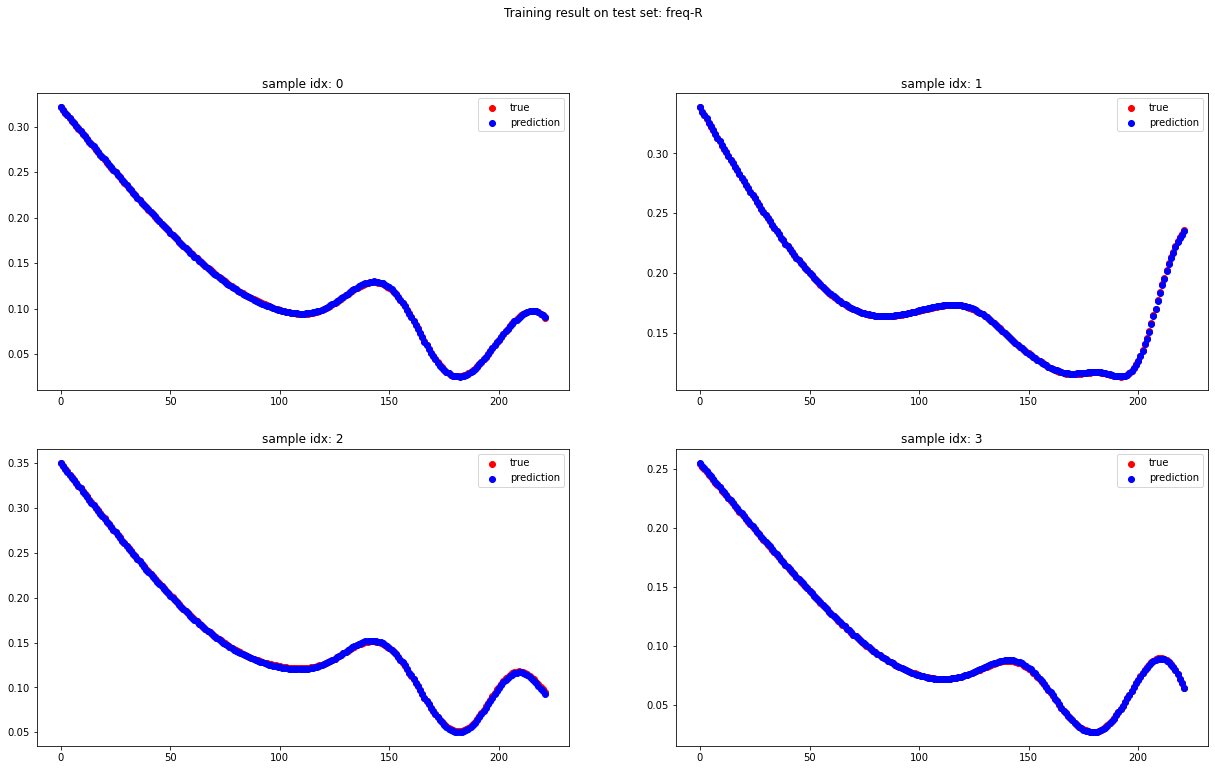

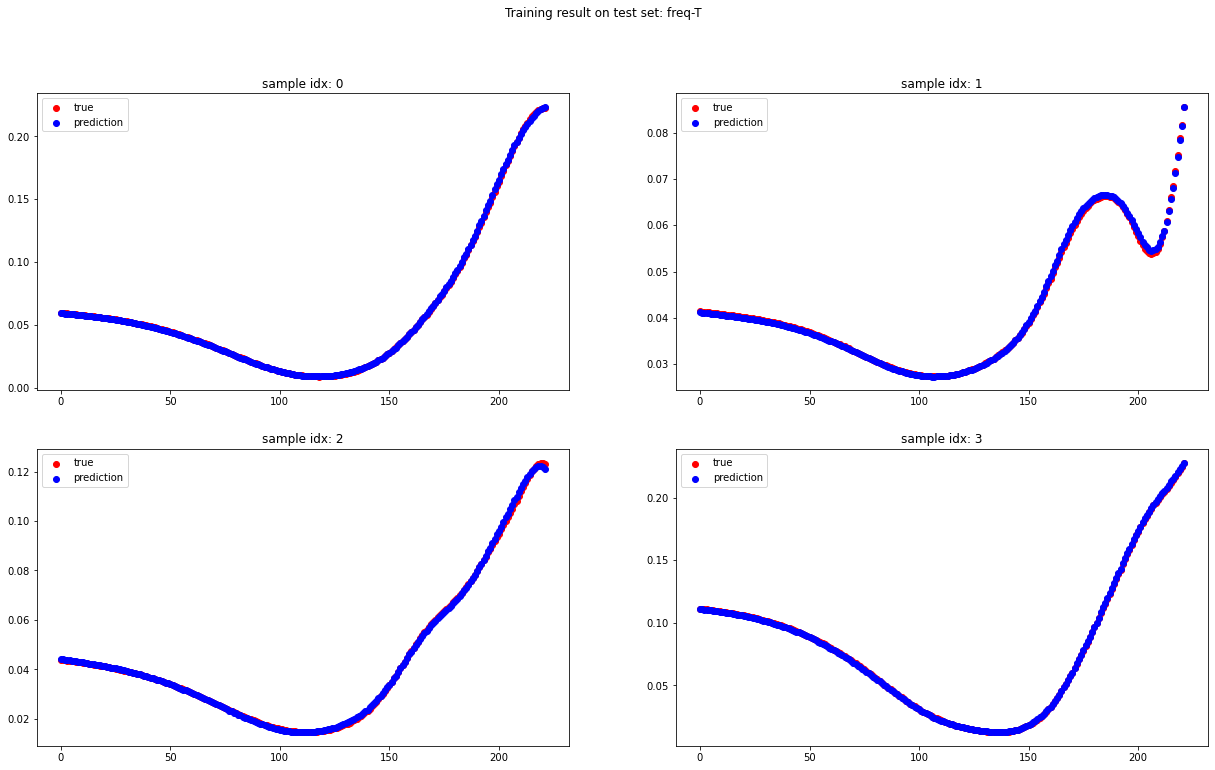

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [147. 122. 160.  75.]
 [145. 122. 160.  75.]
 [145. 121. 160.  75.]
 [146. 120. 160.  75.]
 [147. 121. 160.  75.]
 [147. 120. 160.  75.]
 [145. 120. 160.  75.]
 [146. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


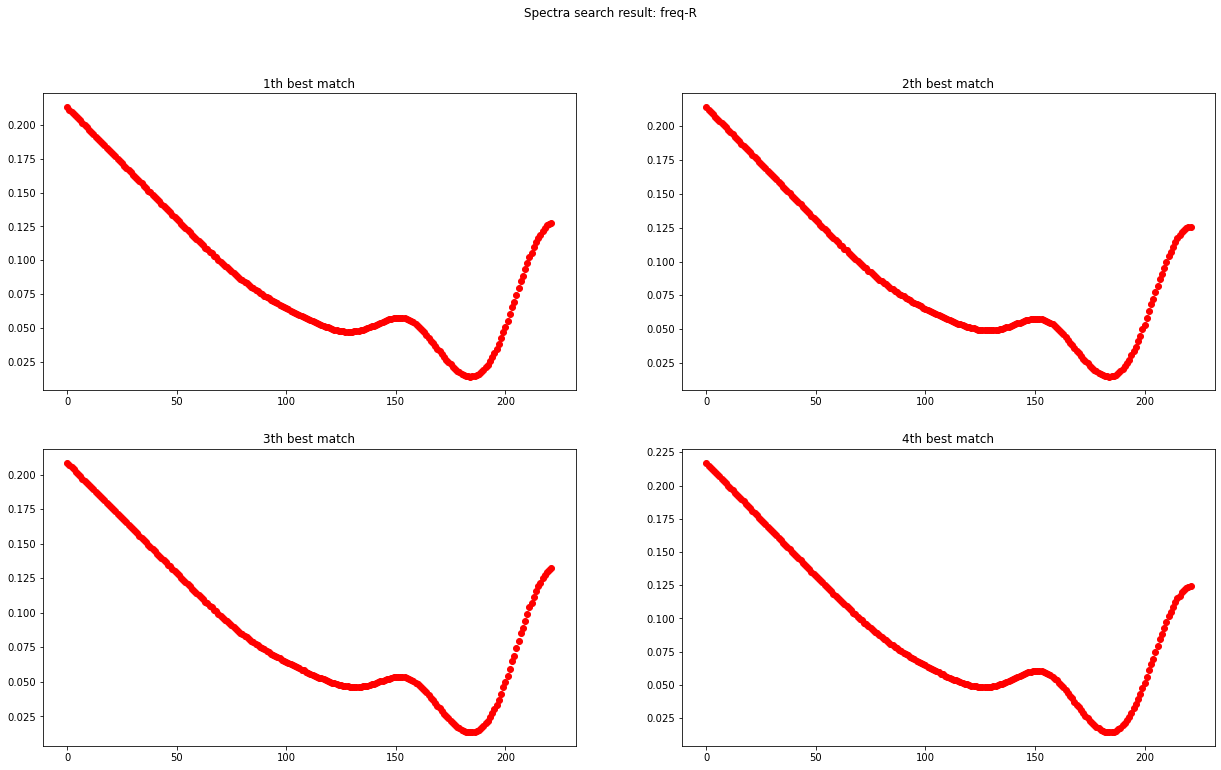

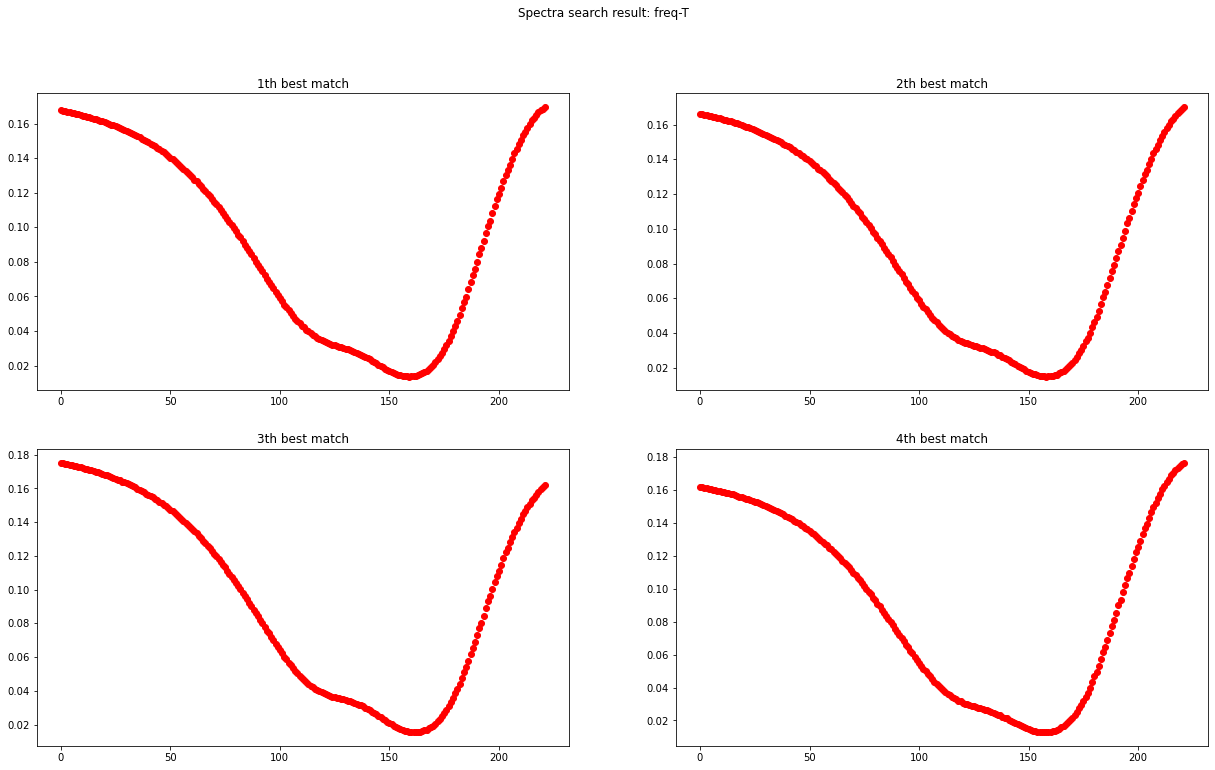

*** Reruning RCWA on picked params
params_dict.shape: (612, 4)
R_dict.shape: (612, 222)
T_dict.shape: (612, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [147. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.]

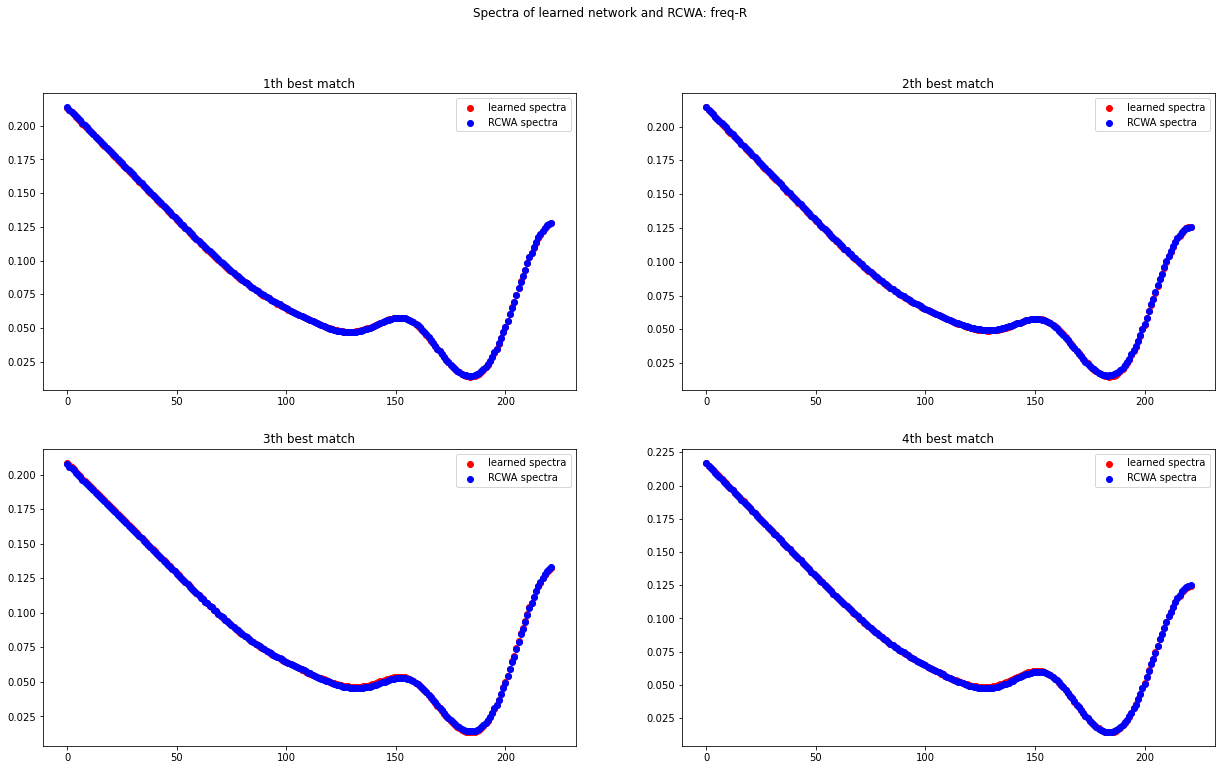

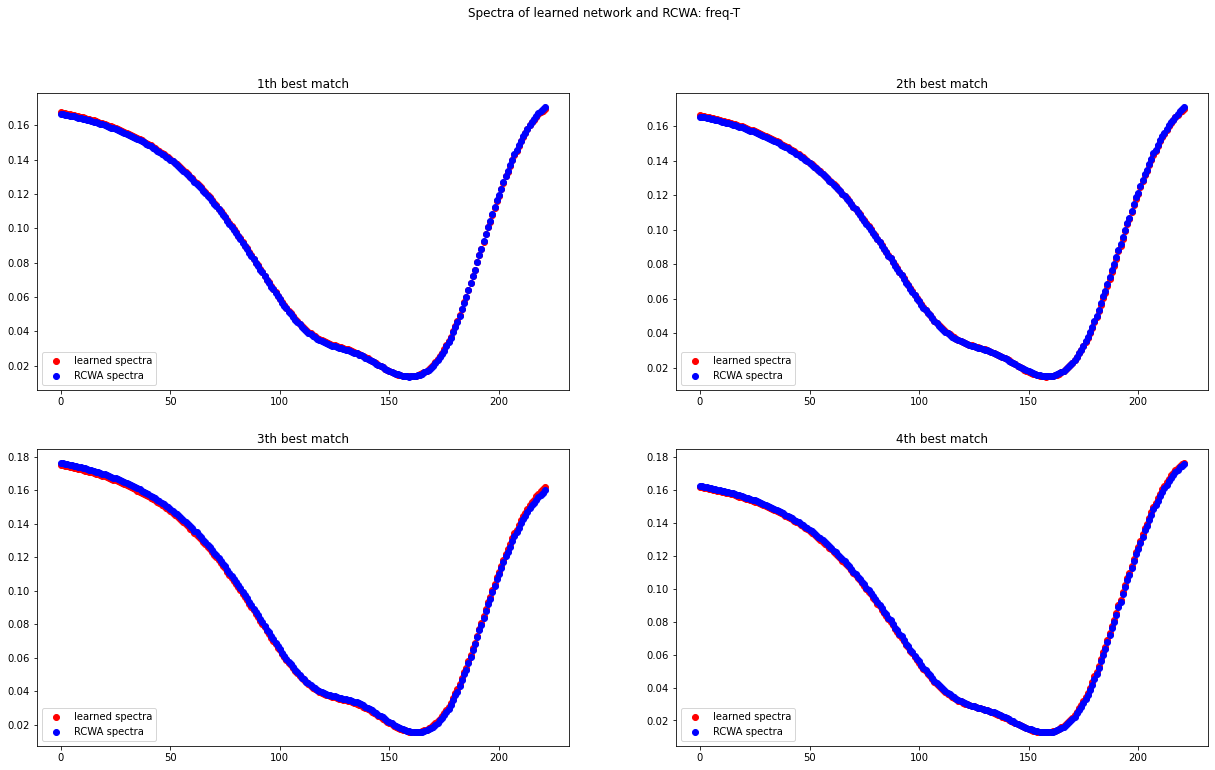

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 813
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [139.  59.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [107.  77.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [140. 137.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 82. 113.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [128.  51.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [53. 89.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [98. 91.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [129.  59.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [138. 140.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [69. 50.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [106. 145.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 74. 117.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [138.  61.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 77. 135.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 72. 131.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [135. 116.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [125.  64.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 51. 120.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [135. 112.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [149.  71.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [65. 52.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 60. 103.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 8.713401171494348e-05
### TEST LOSS  0.0003158732847973275
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.9839231044418257e-05
### TEST LOSS  1.358903297771646e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.228370193513641e-05
### TEST LOSS  8.346883602756021e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 8.805391547786203e-06
### TEST LOSS  6.0193389729717565e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 7.68977915366151e-06
### TEST LOSS  7.301791181537108e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 7.592835514481052e-06
### TEST LOSS  9.318314753797425e-06
----------------------------------------------------------------------
*** 

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.5877498087590583e-06
### TEST LOSS  1.1337535458831273e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.7198470671990116e-06
### TEST LOSS  4.2751003617852875e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.4036786403533555e-06
### TEST LOSS  2.3302381158338485e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.7455263400954353e-06
### TEST LOSS  1.1009485835809476e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.9495775782872985e-06
### TEST LOSS  1.3147530790565024e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.3683777983257852e-06
### TEST LOSS  1.7151149817296896e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.436693852800152e-07
### TEST LOSS  9.68089942979042e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 4.177042690191113e-06
### TEST LOSS  4.808984802086623e-05
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.733750190642212e-06
### TEST LOSS  3.1429508453584276e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.7222578205660686e-06
### TEST LOSS  1.080509063145795e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.2847874352740056e-06
### TEST LOSS  1.3771143498021188e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.110145813066157e-06
### TEST LOSS  1.2742166290991008e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.131273414350735e-07
### TEST LOSS  5.799934596185407e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.0669092955395994e-06
### TEST LOSS  8.693374936158832e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 9.345642072746499e-07
### TEST LOSS  4.5575277541642066e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 9.187482981521748e-07
### TEST LOSS  8.570400583406669e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.1314253939286234e-06
### TEST LOSS  7.221458592819265e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.371074128307192e-07
### TEST LOSS  6.558143752499745e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 2.42010233239475e-06
### TEST LOSS  1.0816445366729638e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.0154768205718206e-06
### TEST LOSS  5.666825477244577e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 8.566490574701469e-07
### TEST LOSS  5.075757266800233e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 8.024224773981863e-07
### TEST LOSS  4.834055311256144e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 7.203938246504655e-07
### TEST LOSS  6.910217481303195e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.989876398164668e-07
### TEST LOSS  6.203774555265577e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 1.3782487469555332e-06
### TEST LOSS  1.1834945850680995e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.10980854973946e-06
### TEST LOSS  6.749074985306764e-06
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.5325467691538243e-06
### TEST LOSS  9.666056213903246e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 1.0862923539910355e-06
### TEST LOSS  1.215261888249258e-06
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 8.965393887532106e-07
### TEST LOSS  9.374595125476704e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 8.032711532906293e-07
### TEST LOSS  8.934117309203989e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 6.503033104231248e-07
### TEST LOSS  1.072866539813661e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 6.433125142346428e-07
### TEST LOSS  5.866366056859708e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.074753627891988e-07
### TEST LOSS  6.428741742708482e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 6.327766758866498e-07
### TEST LOSS  3.5605073706462394e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.991002514448394e-07
### TEST LOSS  1.0001490146840717e-06
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.665559727494424e-07
### TEST LOSS  8.298480863161856e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 7.199766227360669e-07
### TEST LOSS  4.784268434412717e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 6.454552117713313e-07
### TEST LOSS  4.7636267525446715e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 7.548493218195517e-07
### TEST LOSS  7.42504561493171e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.120477748586262e-07
### TEST LOSS  1.4269894651219006e-06
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 7.069981301167946e-07
### TEST LOSS  5.096165715748122e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 1.9109738598857967e-06
### TEST LOSS  1.6673382018640182e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 9.398825898754415e-07
### TEST LOSS  2.8486804327398063e-06
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.7930631217339345e-06
### TEST LOSS  6.77360617373779e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 1.2073710326068466e-06
### TEST LOSS  7.409538599089361e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 6.783664127103684e-07
### TEST LOSS  8.548986268299184e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 6.688729748112368e-07
### TEST LOSS  3.8616936247028485e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 6.87891906107021e-07
### TEST LOSS  5.447351222406164e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.516773511597809e-07
### TEST LOSS  3.8820433609579106e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 6.437784752390145e-07
### TEST LOSS  4.579624518240822e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.815847127042937e-07
### TEST LOSS  5.487285429458448e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 7.971111968512038e-07
### TEST LOSS  6.036156430757098e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 6.351985687852617e-07
### TEST LOSS  4.073115156608345e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 6.332862458920841e-07
### TEST LOSS  4.5546800956449613e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.028458136549463e-07
### TEST LOSS  3.774835503323769e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 6.472919829744168e-07
### TEST LOSS  4.573971768177916e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.784333255099067e-07
### TEST LOSS  3.347478929946682e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 5.283136772417406e-07
### TEST LOSS  4.592996648310733e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 6.915926568114006e-07
### TEST LOSS  1.1530266218729735e-06
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 6.433263743058584e-07
### TEST LOSS  9.247051414499415e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 5.175330883101374e-07
### TEST LOSS  4.192474803560869e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 5.021925347468689e-07
### TEST LOSS  3.6629086471643507e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.7436889105990204e-07
### TEST LOSS  5.240285612619398e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 5.481711541531399e-07
### TEST LOSS  7.489953409626301e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.588455795293389e-07
### TEST LOSS  4.438948403381241e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 5.010269797929634e-07
### TEST LOSS  6.522964912829383e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.795346829388945e-07
### TEST LOSS  3.7696703058232884e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 5.685373310353019e-07
### TEST LOSS  5.121590968078985e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.339604297415837e-07
### TEST LOSS  4.0003092312172856e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.163457124427592e-07
### TEST LOSS  4.392781555942257e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.848323923118988e-07
### TEST LOSS  6.11972397406974e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.6451253057607027e-07
### TEST LOSS  4.5487296609700513e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.265235388385648e-07
### TEST LOSS  2.976839604903384e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.46042555866911e-07
### TEST LOSS  4.900823000753007e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 7.931328102645202e-07
### TEST LOSS  4.5062436216679856e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 5.076020339133676e-07
### TEST LOSS  3.194929088469787e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.7510771055175247e-07
### TEST LOSS  5.524366031295358e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 5.771611650850694e-07
### TEST LOSS  8.023689806927555e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 5.237297427786257e-07
### TEST LOSS  5.999305541920946e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.6277958460730414e-07
### TEST LOSS  2.972523484109283e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.5447641193936286e-07
### TEST LOSS  6.191127725357476e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.4435482056129305e-07
### TEST LOSS  4.0384336749901615e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 6.244045868572294e-07
### TEST LOSS  7.785744479896003e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.68876096231386e-07
### TEST LOSS  1.263028563104084e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.3046345345152074e-07
### TEST LOSS  3.0468867661371547e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.386697213703743e-07
### TEST LOSS  3.2912555744028043e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 5.661226106504688e-07
### TEST LOSS  5.456592847307408e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 6.877613261681953e-07
### TEST LOSS  3.148911728290981e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.851885401556558e-07
### TEST LOSS  4.0865704529726196e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 5.540191844553292e-07
### TEST LOSS  3.9091290642108316e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.9910168349315945e-07
### TEST LOSS  3.897909025978991e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.1152267985526436e-07
### TEST LOSS  5.529563880967404e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.345409776263252e-07
### TEST LOSS  5.836253627386703e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.1977052439572225e-07
### TEST LOSS  3.843386217830322e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.2073587590635497e-07
### TEST LOSS  2.9430479304874797e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.6673518289547413e-07
### TEST LOSS  3.7593007872461527e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.45049634367346e-07
### TEST LOSS  4.926216202140774e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.083264047615483e-07
### TEST LOSS  2.391807608039296e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.717968915710797e-07
### TEST LOSS  4.936218085906428e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.5231666639364e-07
### TEST LOSS  6.393449675320321e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.2140245592973244e-07
### TEST LOSS  3.991744917514622e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.482322564916415e-07
### TEST LOSS  3.370839356018853e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 5.745566748210488e-07
### TEST LOSS  8.5495804132034e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 6.202345302357753e-07
### TEST LOSS  9.88580132763253e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 5.740413911430836e-07
### TEST LOSS  4.572206036685272e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 5.351923723088891e-07
### TEST LOSS  6.860120589198442e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 4.736125540851657e-07
### TEST LOSS  4.6950056833758515e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.896038609004572e-07
### TEST LOSS  9.230838075452014e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.7250228696658457e-07
### TEST LOSS  6.54544569792611e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 4.924113918582071e-07
### TEST LOSS  4.5062753665311345e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.9554613554416173e-07
### TEST LOSS  6.34578144014925e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.5294540073034006e-07
### TEST LOSS  4.1263324463286085e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.310859129879432e-07
### TEST LOSS  4.3197049247003e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.1271299744200515e-07
### TEST LOSS  5.654446030033656e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 4.045427782096693e-07
### TEST LOSS  3.510348541077782e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.1725849953125893e-07
### TEST LOSS  4.726380474004635e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.738148813895149e-07
### TEST LOSS  3.9728044717216665e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.7999051209142964e-07
### TEST LOSS  3.4115048973804875e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 4.134832995967175e-07
### TEST LOSS  2.920193137557502e-07
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 3.451850276654555e-07
### TEST LOSS  3.962316904667554e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.6594286149584637e-07
### TEST LOSS  2.692260658512588e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 4.4881085594671876e-07
### TEST LOSS  6.468743178034996e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.876430528808073e-07
### TEST LOSS  2.659532141863635e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 4.632801220588891e-07
### TEST LOSS  2.6967766221839787e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.0625490236593657e-07
### TEST LOSS  4.942792617594722e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 5.94652004982459e-07
### TEST LOSS  3.1045462378642696e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 4.182140097933977e-07
### TEST LOSS  3.97194858473645e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.5513882287105136e-07
### TEST LOSS  3.0897225236423344e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.2263859906816914e-07
### TEST LOSS  4.0313834950631224e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.617679367214977e-07
### TEST LOSS  3.638043805354895e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 4.309185967311528e-07
### TEST LOSS  4.6217751376459023e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 4.0271474023665833e-07
### TEST LOSS  3.14011683800485e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.8198776737263975e-07
### TEST LOSS  4.499594165981062e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.6818097317570596e-07
### TEST LOSS  2.676925156755225e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.278886506334473e-07
### TEST LOSS  2.6675619962518863e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.062552834589344e-07
### TEST LOSS  2.3533614633099484e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.48459574187051e-07
### TEST LOSS  3.5770190064655395e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 3.7850945721067055e-07
### TEST LOSS  4.5833501452272265e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 4.1166642482690965e-07
### TEST LOSS  2.5872409336303605e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.9159395877708744e-07
### TEST LOSS  3.927863430747563e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.7406901110883307e-07
### TEST LOSS  3.290807768507875e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 4.670667752081909e-07
### TEST LOSS  5.924131956957214e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 4.6827493676914574e-07
### TEST LOSS  3.9206223443845653e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.589226260972403e-07
### TEST LOSS  5.255185507954034e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.6019581803261117e-07
### TEST LOSS  5.373135449050236e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.512299158580272e-07
### TEST LOSS  2.62051019516408e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.6426526365114153e-07
### TEST LOSS  3.1346318634789964e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.6456070794556363e-07
### TEST LOSS  4.6957816397690084e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.8692553246680603e-07
### TEST LOSS  3.652564653468569e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.591340892525497e-07
### TEST LOSS  3.356210811489291e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.356753032550289e-07
### TEST LOSS  3.864146483815253e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.307934624166588e-07
### TEST LOSS  4.545629377179676e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.4675823442643716e-07
### TEST LOSS  4.342253331602618e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 4.0556322992350493e-07
### TEST LOSS  4.1510852300829214e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.4083483072095216e-07
### TEST LOSS  3.24642756438082e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.650963172753095e-07
### TEST LOSS  2.636545723624714e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.6862822873179006e-07
### TEST LOSS  2.885010504682074e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.397726381435152e-07
### TEST LOSS  2.8735131798804594e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.115796288529813e-07
### TEST LOSS  2.2190746908388695e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.395547273460043e-07
### TEST LOSS  2.7638164768772043e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.5134584401672206e-07
### TEST LOSS  2.740786628079989e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.765709241614029e-07
### TEST LOSS  5.421058189697831e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.5865120786153355e-07
### TEST LOSS  2.884291828964846e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.334958236214969e-07
### TEST LOSS  3.341379226640129e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.6540446831996615e-07
### TEST LOSS  3.343813502327136e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.381071046240223e-07
### TEST LOSS  2.996020410906707e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.778687572600123e-07
### TEST LOSS  3.571216976839563e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.4777487788466223e-07
### TEST LOSS  2.2541509172067612e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.496117186868508e-07
### TEST LOSS  7.572232072141979e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 5.644842376183106e-07
### TEST LOSS  2.759499219214726e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 4.5235567088549997e-07
### TEST LOSS  4.88419905545575e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.510771519709328e-07
### TEST LOSS  3.128682117483969e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.5075123492822806e-07
### TEST LOSS  1.4559328397249024e-06
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 4.168429553663754e-07
### TEST LOSS  3.1694529612790433e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.2828510637799625e-07
### TEST LOSS  2.6416831880956476e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.779054910871445e-07
### TEST LOSS  3.4570869134908065e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.640359719341902e-07
### TEST LOSS  2.393532138984693e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 4.3378656929879936e-07
### TEST LOSS  2.7474557603349797e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.3440440456356365e-07
### TEST LOSS  2.5729851616828313e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.763249890077886e-07
### TEST LOSS  3.086642823728443e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.5084799637579096e-07
### TEST LOSS  3.884729310881924e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.685721728835666e-07
### TEST LOSS  2.2963757063420277e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.9830793824629507e-07
### TEST LOSS  3.2114019723814215e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.0893842612617913e-07
### TEST LOSS  4.0239284369538206e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.3040137653833905e-07
### TEST LOSS  3.189164028928924e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 4.089748562658763e-07
### TEST LOSS  2.7487779710519624e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.20442275608317e-07
### TEST LOSS  2.25212154156487e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.596303677214642e-07
### TEST LOSS  4.281744955173613e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.222689868547082e-07
### TEST LOSS  3.8016385964021117e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.354626786988275e-07
### TEST LOSS  2.3269596410430566e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.456163087591143e-07
### TEST LOSS  3.162960601125283e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.470267261459327e-07
### TEST LOSS  2.80974081061476e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.8814479038303497e-07
### TEST LOSS  3.128312044964332e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.0696561643416006e-07
### TEST LOSS  2.036306275735674e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.0361351779340317e-07
### TEST LOSS  1.9479069106427443e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.19067705902206e-07
### TEST LOSS  3.0703647159778205e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.378137506536873e-07
### TEST LOSS  5.745153500286576e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.1630291107260885e-07
### TEST LOSS  2.1151334277209781e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.918232346950656e-07
### TEST LOSS  2.6832161600290977e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.2208022220995664e-07
### TEST LOSS  2.1026979897424798e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.2148565959515264e-07
### TEST LOSS  2.210774239913987e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.086238913182492e-07
### TEST LOSS  3.669766849375614e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.957522938231355e-07
### TEST LOSS  2.2906573677188973e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 2.9607670542636076e-07
### TEST LOSS  2.8660222994858486e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.00604300376948e-07
### TEST LOSS  3.3041991050945046e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.4117814861003503e-07
### TEST LOSS  2.0698471613601353e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.1281402593281853e-07
### TEST LOSS  3.0752737682877733e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.180633947499924e-07
### TEST LOSS  2.18118835540246e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.8694974497340495e-07
### TEST LOSS  2.6976481247122416e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.131905702728756e-07
### TEST LOSS  5.980179874033918e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.1055896467332105e-07
### TEST LOSS  2.1931942866943316e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.201642206631147e-07
### TEST LOSS  2.933796106565121e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.080081792518804e-06
### TEST LOSS  4.3874666744159185e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.143847053914046e-06
### TEST LOSS  4.590557890738777e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.9329325239311634e-07
### TEST LOSS  3.432935347273787e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 4.1079368426347824e-07
### TEST LOSS  3.086866907044448e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.987143559485753e-07
### TEST LOSS  2.3548818826559278e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.864492690672314e-07
### TEST LOSS  2.614265869082234e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.772416599533677e-07
### TEST LOSS  3.4136551308760176e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.710897063357996e-07
### TEST LOSS  2.3034786959914737e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.364876691245595e-07
### TEST LOSS  2.232987707902094e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.2488672378093533e-07
### TEST LOSS  2.0664441645014728e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.9495631872808816e-07
### TEST LOSS  6.985435010602276e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 3.264078468176763e-07
### TEST LOSS  2.378370468774777e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.0668392794121057e-07
### TEST LOSS  3.6605445512367834e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.2950831290135694e-07
### TEST LOSS  3.619773980727377e-07
** loss_train 3.2950831290135694e-07
** loss_test 3.619773980727377e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


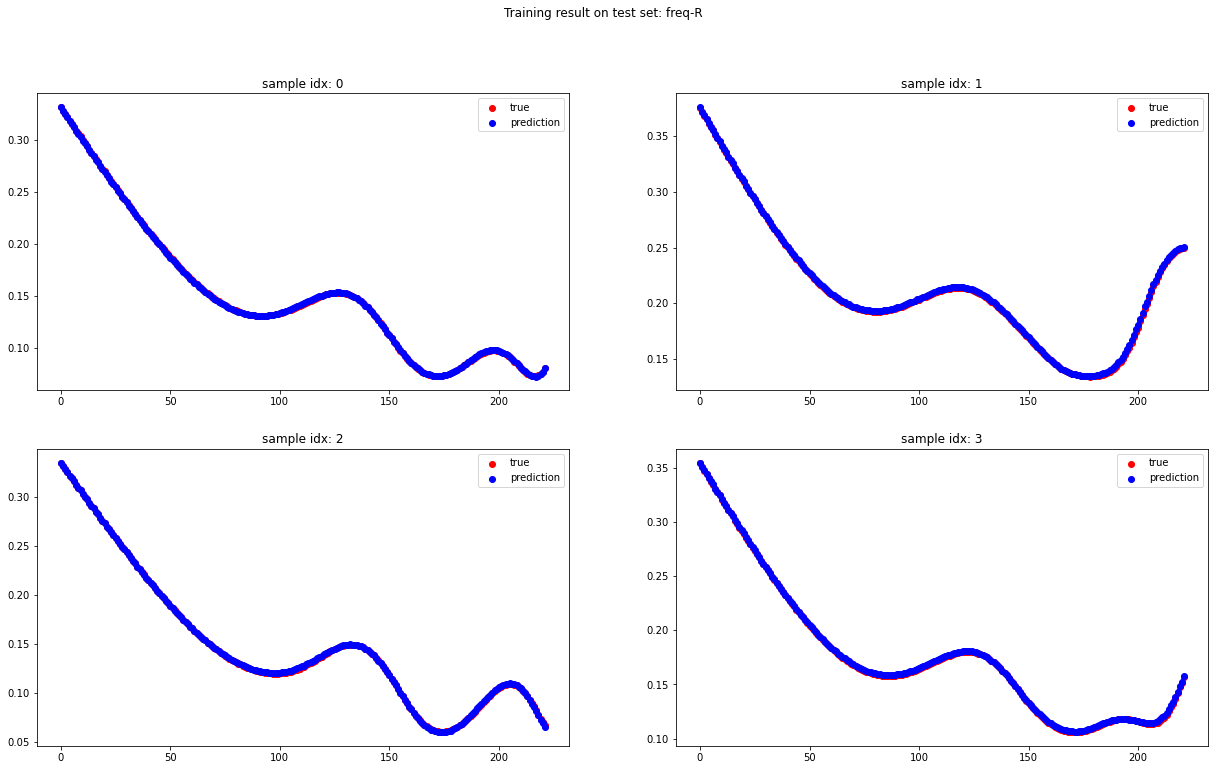

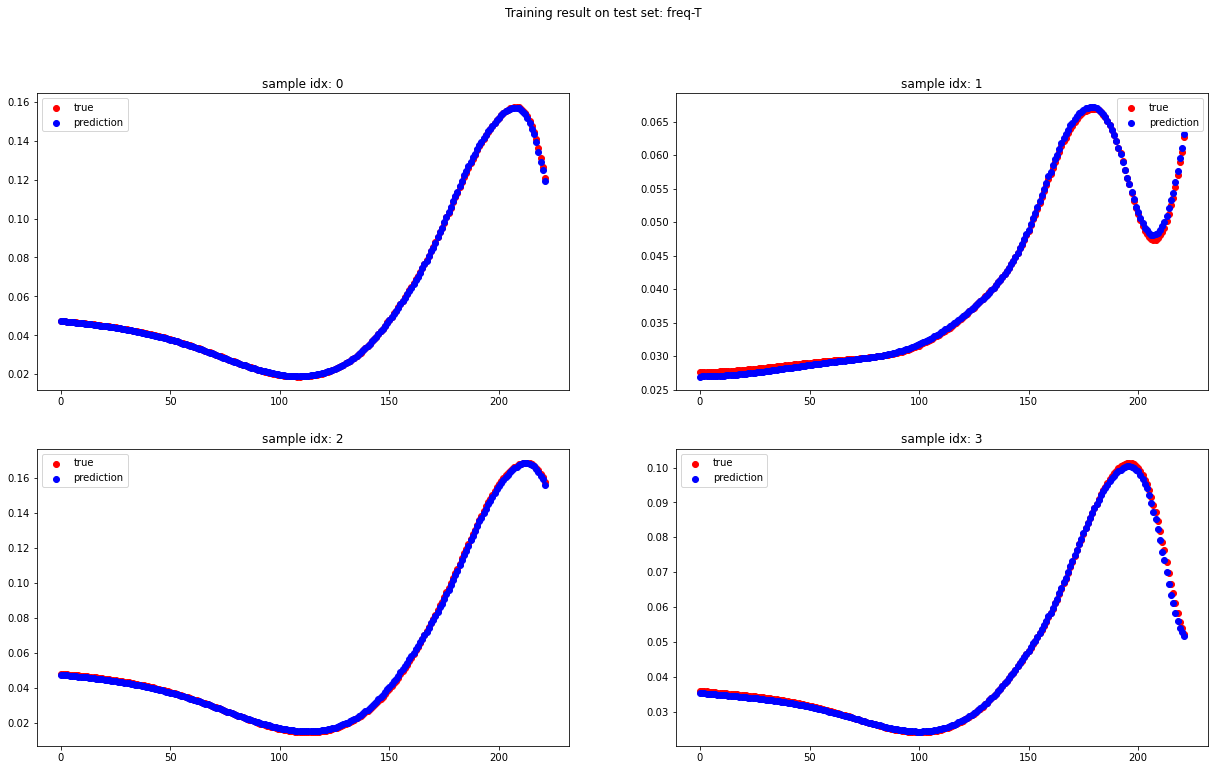

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [145. 122. 160.  75.]
 [145. 121. 160.  75.]
 [146. 120. 160.  75.]
 [146. 122. 160.  75.]
 [145. 123. 160.  75.]
 [146. 123. 160.  75.]
 [145. 120. 160.  75.]
 [147. 123. 160.  75.]
 [147. 121. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


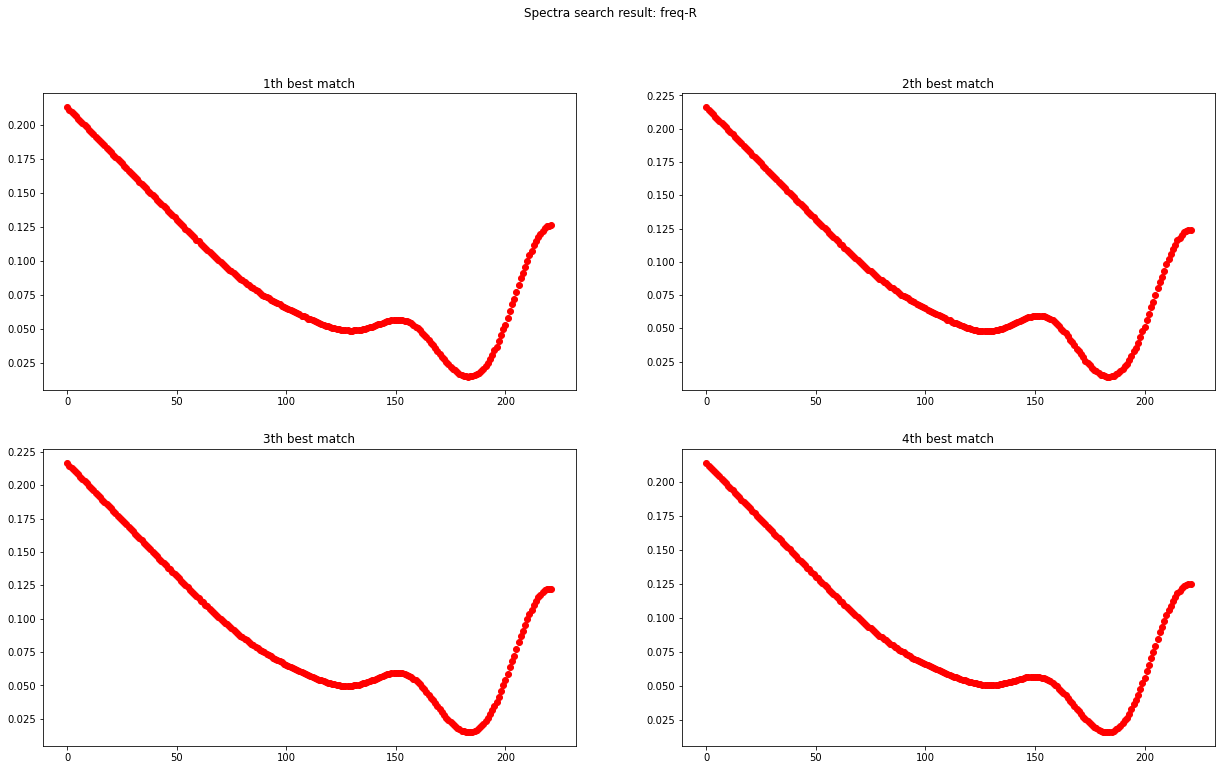

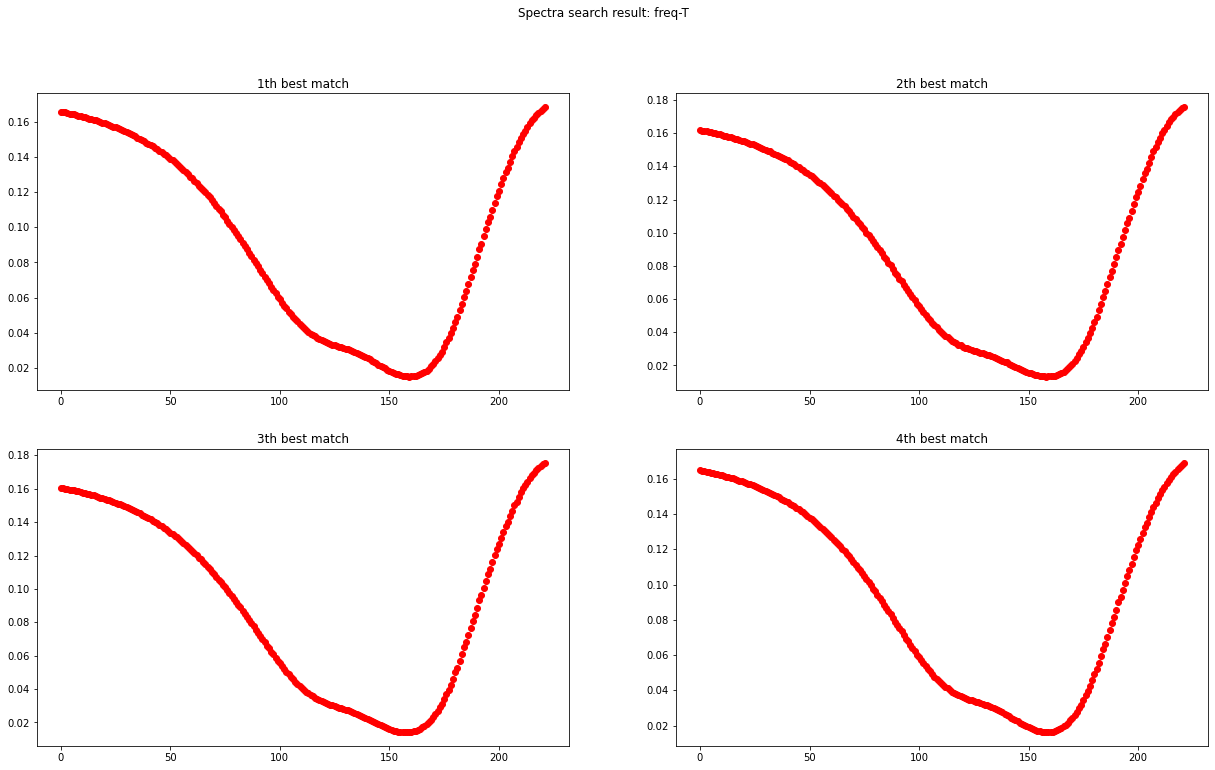

*** Reruning RCWA on picked params
params_dict.shape: (813, 4)
R_dict.shape: (813, 222)
T_dict.shape: (813, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
7 th match
Not in the dict, calling RCWA...
# params_pick: [146. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[

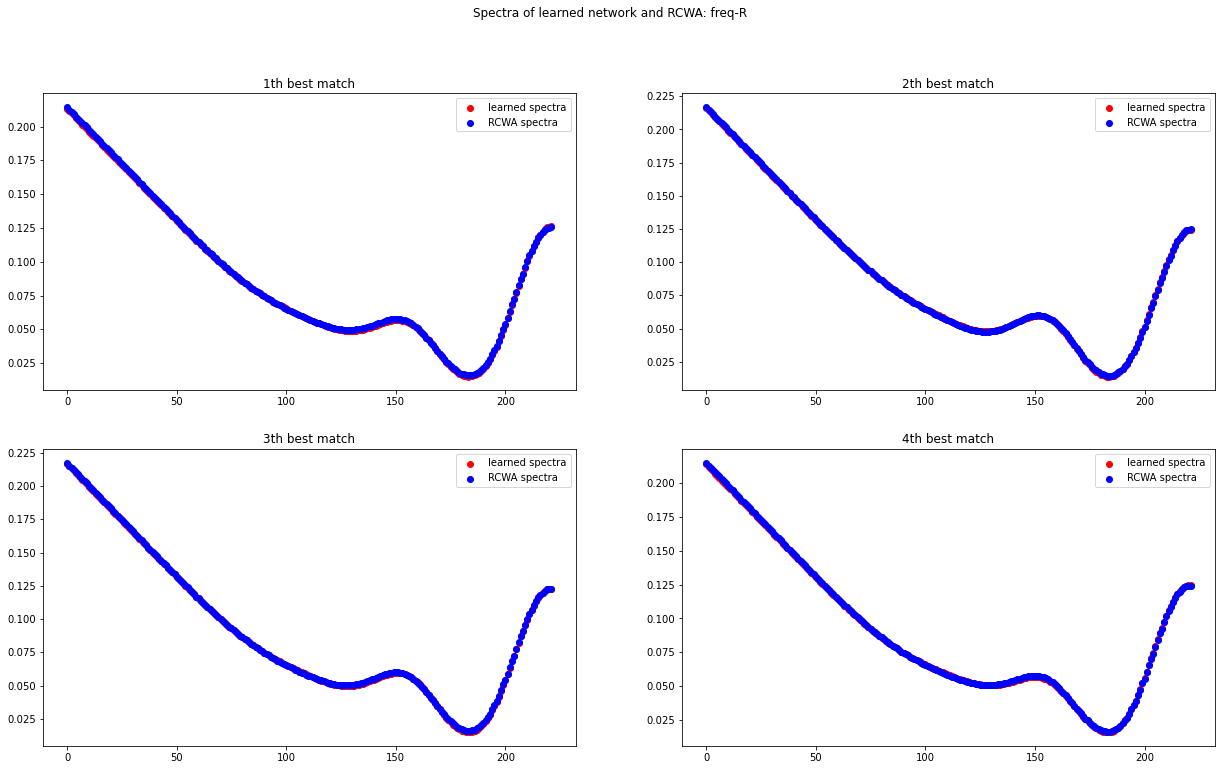

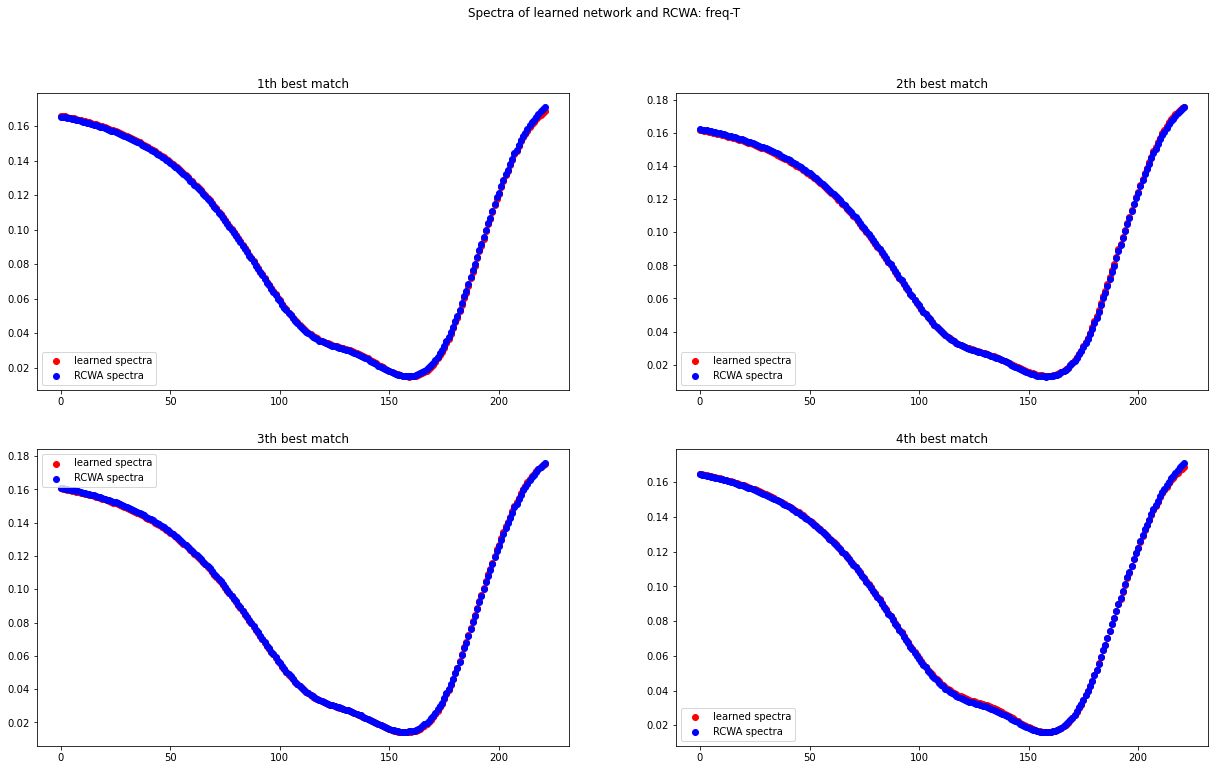

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1015
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [52. 99.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [80. 95.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 53. 104.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [70. 65.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [113.  54.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 55. 150.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [62. 69.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 69. 147.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [112.  65.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [122.  51.]
Calculation Progr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 78. 134.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [72. 53.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [110.  71.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [97. 74.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [71. 79.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [142.  82.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [52. 62.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [100. 136.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 92. 146.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [121. 132.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [145. 112.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 91. 149.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 4.3362354643187276e-05
### TEST LOSS  9.566236917635251e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 3.075729996475848e-05
### TEST LOSS  1.772506828956466e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 2.159414272980563e-05
### TEST LOSS  2.7035914399675676e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.4101712120350944e-05
### TEST LOSS  5.4999977578518155e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.6762855675092464e-05
### TEST LOSS  8.734470100080216e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 8.759755840193008e-06
### TEST LOSS  6.485873427664046e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 3.882544450603911e-06
### TEST LOSS  1.7989993779110591e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 2.7436105331313463e-06
### TEST LOSS  1.3777114773461108e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.455795490681868e-06
### TEST LOSS  4.502613634826957e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.9828044608344326e-06
### TEST LOSS  2.698240550103037e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.9993559842163084e-06
### TEST LOSS  9.72651953645709e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.8264751613845237e-06
### TEST LOSS  2.6052539041643286e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.236533403470625e-06
### TEST LOSS  1.2331206953319906e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.2066944485236557e-06
### TEST LOSS  9.863335819204622e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.0467320401959526e-06
### TEST LOSS  9.556871596316796e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.1549957677963337e-06
### TEST LOSS  1.169177540560895e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.5610413270100736e-06
### TEST LOSS  1.3932300149122057e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.5155199084446384e-06
### TEST LOSS  2.161066959160962e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 9.734880786426437e-07
### TEST LOSS  1.6304299492730934e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 9.911871860886274e-07
### TEST LOSS  8.778857250035799e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 8.52705871670374e-07
### TEST LOSS  6.820716684785566e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.0721623644685814e-06
### TEST LOSS  1.7850917402029154e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.4736668083010783e-06
### TEST LOSS  7.466291727098451e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.2679958966396828e-06
### TEST LOSS  8.443555294945781e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 8.580412721162897e-07
### TEST LOSS  5.780597103210994e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.932734445615159e-07
### TEST LOSS  5.371623235106426e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.766978434810872e-07
### TEST LOSS  5.433142806765545e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.071442323613132e-07
### TEST LOSS  5.411987462622392e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 9.244630081912413e-07
### TEST LOSS  7.688522565274525e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.356574532062323e-07
### TEST LOSS  6.526425089248278e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.860315286507788e-07
### TEST LOSS  4.903683858969998e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 7.387261567665909e-07
### TEST LOSS  7.011265026335423e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 6.527189665433892e-07
### TEST LOSS  5.284742154998412e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 7.254370904865712e-07
### TEST LOSS  9.712055160093769e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 8.046078189616717e-07
### TEST LOSS  4.962334259062118e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 7.485135764172496e-07
### TEST LOSS  9.211320595170491e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 6.749937881662791e-07
### TEST LOSS  6.216637800093849e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 6.071535795619634e-07
### TEST LOSS  8.088305669673446e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 6.198002734723456e-07
### TEST LOSS  6.364487745713632e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.532108408342448e-07
### TEST LOSS  4.518754224136501e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.668321521227581e-07
### TEST LOSS  6.214413872385194e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.83145209108371e-07
### TEST LOSS  3.578592817632398e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.078123302816411e-07
### TEST LOSS  4.091349747881168e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.652870252746612e-07
### TEST LOSS  4.023225379512496e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.759389630730069e-07
### TEST LOSS  4.559217359201284e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 1.1472746290746278e-06
### TEST LOSS  6.885796430822211e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.555436837466309e-07
### TEST LOSS  5.818761206199952e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.650100284141592e-07
### TEST LOSS  1.2248486314092588e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.503732646490572e-07
### TEST LOSS  3.8411877234523217e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.7504349690394395e-07
### TEST LOSS  4.1614298140757455e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.188239571865333e-07
### TEST LOSS  4.0580502336240443e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.082217469031001e-07
### TEST LOSS  1.0976852209410026e-06
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.69017636026123e-07
### TEST LOSS  3.550913536543021e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 6.308798642764426e-07
### TEST LOSS  4.4311468272439924e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.448308642052884e-07
### TEST LOSS  3.7836671573643343e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.953568511774579e-07
### TEST LOSS  9.643541716286563e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.338124654758926e-07
### TEST LOSS  4.5380129876093633e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.935760431873026e-07
### TEST LOSS  4.5923276559278747e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 5.048566271191786e-07
### TEST LOSS  6.149280054046358e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 5.396619459012698e-07
### TEST LOSS  7.190431787762464e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.869797224755407e-07
### TEST LOSS  5.632774779940064e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.864992060318056e-07
### TEST LOSS  3.7689048326683405e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.134960901916793e-07
### TEST LOSS  2.651092039229752e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 5.196236078197089e-07
### TEST LOSS  4.334645478110133e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.787433576199376e-07
### TEST LOSS  4.2755129747718e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 5.484305424885755e-07
### TEST LOSS  4.23213064593142e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.963208999823607e-07
### TEST LOSS  3.17098573177077e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.4750870546743146e-07
### TEST LOSS  3.0177857190949453e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.4192469546733557e-07
### TEST LOSS  5.791904023055849e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.977499291956591e-07
### TEST LOSS  4.296450093477233e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.030607031723706e-07
### TEST LOSS  6.263179219700987e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.232264671144898e-07
### TEST LOSS  4.279550989139125e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.0424751391138184e-07
### TEST LOSS  5.335959354368924e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.4679481401726215e-07
### TEST LOSS  3.702452797682554e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.9240696764793967e-07
### TEST LOSS  3.039394851356292e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.962686551720448e-07
### TEST LOSS  4.1820569229855664e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.050338447489352e-07
### TEST LOSS  3.5127643727150826e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.0726199945182427e-07
### TEST LOSS  5.63998412417277e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.201519795232099e-07
### TEST LOSS  5.66290790260382e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.4604270621856156e-07
### TEST LOSS  3.0796583239123265e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.075194361449148e-07
### TEST LOSS  4.1657169269626593e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.783519458223829e-07
### TEST LOSS  3.3090421602821607e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 5.363304106057951e-07
### TEST LOSS  2.990623801935044e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.6836744346513834e-07
### TEST LOSS  5.384607373315475e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.8885666792082686e-07
### TEST LOSS  2.3154301498351515e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.9833182857909505e-07
### TEST LOSS  3.1078491069536085e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.7779780081666165e-07
### TEST LOSS  2.706869821622604e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.9545118215993804e-07
### TEST LOSS  4.3405270133689555e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.452091433337256e-07
### TEST LOSS  5.424005387055786e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.4518747777264533e-07
### TEST LOSS  2.92079764818709e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.570643137147388e-07
### TEST LOSS  3.794182390493006e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.9183127681587903e-07
### TEST LOSS  7.627054721126569e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.855200705823945e-07
### TEST LOSS  2.7103252531190947e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.0546223981285713e-07
### TEST LOSS  4.780890137112692e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.1941411988796844e-07
### TEST LOSS  3.624814741698401e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.582878593596402e-07
### TEST LOSS  2.740823594749031e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.4060639403128534e-07
### TEST LOSS  5.554586284262086e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.9951148124058206e-07
### TEST LOSS  3.075364629623323e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.7530219483185226e-07
### TEST LOSS  3.591379860168331e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.54531101286081e-07
### TEST LOSS  5.402755238748114e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.7185164006842375e-07
### TEST LOSS  2.5371641143578927e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.5242396368779414e-07
### TEST LOSS  4.007459271093694e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.891983162908485e-07
### TEST LOSS  3.01561581927956e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.7671327164039904e-07
### TEST LOSS  4.5826479144750465e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.583220181171267e-07
### TEST LOSS  3.4522108727230716e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.8701021365340026e-07
### TEST LOSS  5.472225232949768e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.6741688089528937e-07
### TEST LOSS  2.7858572249073177e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.482849242252519e-07
### TEST LOSS  2.8809097774029624e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.859364186357462e-07
### TEST LOSS  3.428015977746668e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.683430196616235e-07
### TEST LOSS  4.012901513306133e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.497683078262078e-07
### TEST LOSS  9.418500788171968e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.434152832755507e-07
### TEST LOSS  2.9625050324000313e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.701674951096288e-07
### TEST LOSS  3.220187210217773e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.84813803157774e-07
### TEST LOSS  2.8327690682061757e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.7394789053840173e-07
### TEST LOSS  3.16877114769909e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.5909494031321414e-07
### TEST LOSS  2.9750980612419653e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.6055822386074753e-07
### TEST LOSS  2.3805356441641834e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.574715321974509e-07
### TEST LOSS  2.7904735144801407e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.7946883293328165e-07
### TEST LOSS  4.915245241932098e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.36160517153474e-07
### TEST LOSS  3.533408730049814e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.756633699558151e-07
### TEST LOSS  3.7122247142917786e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 4.334744148992216e-07
### TEST LOSS  3.570005500108664e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.4569734916594085e-07
### TEST LOSS  3.10577536133394e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.8645804917833797e-07
### TEST LOSS  2.4630104178413603e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.6406382529047073e-07
### TEST LOSS  2.9889064556698486e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.8189364835737616e-07
### TEST LOSS  4.866214471377361e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.444727176511901e-07
### TEST LOSS  2.268241825476025e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.590637778724418e-07
### TEST LOSS  3.5983579849130365e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.3847824542574707e-07
### TEST LOSS  3.1743895689828605e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.4915777503406927e-07
### TEST LOSS  2.358452002582112e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.794124525257688e-07
### TEST LOSS  5.644070348864716e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.84378032646254e-07
### TEST LOSS  2.669297005652993e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.795322256275502e-07
### TEST LOSS  2.3724960307447418e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.467348147775543e-07
### TEST LOSS  2.4536520548679164e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.386860713144841e-07
### TEST LOSS  2.8031413723539345e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.0884488881953847e-07
### TEST LOSS  2.4863110237305364e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.3441282845278626e-07
### TEST LOSS  5.469217914111368e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.633991786101397e-07
### TEST LOSS  2.99313071217e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.147914908883197e-07
### TEST LOSS  3.478714862836796e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.6570433090906735e-07
### TEST LOSS  2.555482723209934e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.580689433968881e-07
### TEST LOSS  2.5823977001238063e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.6285794568455796e-07
### TEST LOSS  4.035760685638934e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.1961683838898095e-07
### TEST LOSS  3.7054797452640287e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 3.3329295358364864e-07
### TEST LOSS  2.4365728990005664e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.2497049085766894e-07
### TEST LOSS  3.552258043271195e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.903920131799894e-07
### TEST LOSS  2.973843198361692e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.3131626568828985e-07
### TEST LOSS  7.613528403282999e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.111092914085652e-07
### TEST LOSS  7.995159059248635e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.935145589307781e-07
### TEST LOSS  2.997214441080587e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.23982088109953e-07
### TEST LOSS  4.34635831325636e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.361017215661601e-07
### TEST LOSS  2.5007682680211474e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.5276863034231175e-07
### TEST LOSS  2.354465049592136e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.245954697794379e-07
### TEST LOSS  2.679424575546818e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.0219354396883673e-07
### TEST LOSS  2.840755204402967e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.1262030557686803e-07
### TEST LOSS  4.1938858075241114e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.6822037785030285e-07
### TEST LOSS  6.273319250738041e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.491531362295673e-07
### TEST LOSS  3.322221164836492e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.3435696313975385e-07
### TEST LOSS  2.3732453158231692e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.300606775661467e-07
### TEST LOSS  2.714563427375083e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.407204138129925e-07
### TEST LOSS  2.703022463634852e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.1725740828350187e-07
### TEST LOSS  3.1572571579374653e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.136042704636678e-07
### TEST LOSS  2.459670644938683e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.357859880442931e-07
### TEST LOSS  1.821586854688917e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.013357601627278e-07
### TEST LOSS  7.766648835172418e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.0161695369467897e-07
### TEST LOSS  3.120117728627747e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.475446778699606e-07
### TEST LOSS  2.3767394985441115e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.304840655369159e-07
### TEST LOSS  2.2156365542258527e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.5066192060275857e-07
### TEST LOSS  3.591562087734701e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.834817321175477e-07
### TEST LOSS  3.0197882150417854e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.088661425283478e-07
### TEST LOSS  2.1039732889249763e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.526570596618669e-07
### TEST LOSS  8.836882550156133e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.250057798856358e-07
### TEST LOSS  2.396919267511066e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.1937369226089984e-07
### TEST LOSS  2.88997227926302e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.0992491948498705e-07
### TEST LOSS  4.0095494835412637e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.9793466464803743e-07
### TEST LOSS  2.9442073845586947e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.2383797885996824e-07
### TEST LOSS  2.547157462728933e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.881578669702792e-07
### TEST LOSS  5.089732990626317e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.370559836979807e-07
### TEST LOSS  4.797000414669128e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.448241820360983e-07
### TEST LOSS  3.367210901217277e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.6339351533252054e-07
### TEST LOSS  5.760333046112009e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 4.2577422392592295e-07
### TEST LOSS  2.6781305706435887e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.0864143142104535e-07
### TEST LOSS  1.786843162321361e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.2550907957721426e-07
### TEST LOSS  2.7270204938645293e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.354913955734596e-07
### TEST LOSS  2.519702420045178e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.0895864558446585e-07
### TEST LOSS  2.3084481526325362e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.217601402078734e-07
### TEST LOSS  2.70775140975843e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.080516515223445e-07
### TEST LOSS  3.3361549078847474e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.289891131031498e-07
### TEST LOSS  2.357486552639898e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.041051293660904e-07
### TEST LOSS  2.4658964381529813e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.2415111964289434e-07
### TEST LOSS  2.3524339987091025e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.028521732937525e-07
### TEST LOSS  2.5029433015077984e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.469687698008342e-07
### TEST LOSS  4.5298248529945795e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.295971890485207e-07
### TEST LOSS  3.278448765797748e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.2954289173879625e-07
### TEST LOSS  3.913015120815544e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.926822306629485e-07
### TEST LOSS  2.3459912235068714e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.435609418482198e-07
### TEST LOSS  4.1696770125554394e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.2973485132375065e-07
### TEST LOSS  3.185488228751865e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.168379132503744e-07
### TEST LOSS  5.489684173909382e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.633441878772091e-07
### TEST LOSS  4.7134494884915057e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.1537801714007915e-07
### TEST LOSS  1.938812319579597e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.316077481240696e-07
### TEST LOSS  2.3230433665588635e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.0150168575411154e-07
### TEST LOSS  2.139959152103188e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.8249665737045573e-07
### TEST LOSS  2.704246115925457e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.8213128283345764e-07
### TEST LOSS  2.2817760214621785e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.9682296928785833e-07
### TEST LOSS  2.9606514750923907e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.1240347997134095e-07
### TEST LOSS  2.861726491332206e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.4837428345703395e-07
### TEST LOSS  5.675765777368724e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.954416777027508e-07
### TEST LOSS  2.7484812825662175e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.709015040447295e-07
### TEST LOSS  4.0724320982121753e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 2.899344705994832e-07
### TEST LOSS  1.9753280433576492e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.180579136750871e-07
### TEST LOSS  3.3896087892060223e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.335887831373868e-07
### TEST LOSS  6.262613716501164e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.128944887191777e-07
### TEST LOSS  4.796095414150159e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.051389019650867e-07
### TEST LOSS  4.4321386027945664e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.0678794516767834e-07
### TEST LOSS  2.8203710211727184e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.2835152865048285e-07
### TEST LOSS  2.5633798550472875e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.8837652091123245e-07
### TEST LOSS  3.197188132020301e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.403284624632363e-07
### TEST LOSS  1.9610751955667638e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.7924934416853877e-07
### TEST LOSS  2.654324298134725e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.988521004961825e-07
### TEST LOSS  2.772487226465614e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.043937629490252e-07
### TEST LOSS  4.3005932859330187e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.5761043747094125e-07
### TEST LOSS  3.0913564064150023e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.2044088343486423e-07
### TEST LOSS  2.1197625788005325e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.8030609415501547e-07
### TEST LOSS  2.772172118525873e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.592534936479023e-07
### TEST LOSS  6.761882325179158e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.1116400839003095e-07
### TEST LOSS  2.4235723472543214e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.888271287066444e-07
### TEST LOSS  1.7848382594110035e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.604534158600457e-07
### TEST LOSS  2.3009966731990517e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.8681756730485085e-07
### TEST LOSS  2.390489832748699e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.662821413990758e-07
### TEST LOSS  2.0805821954184012e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.2510624881186305e-07
### TEST LOSS  2.230600300023866e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.266886128920231e-07
### TEST LOSS  5.850424038555957e-07
** loss_train 3.266886128920231e-07
** loss_test 5.850424038555957e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


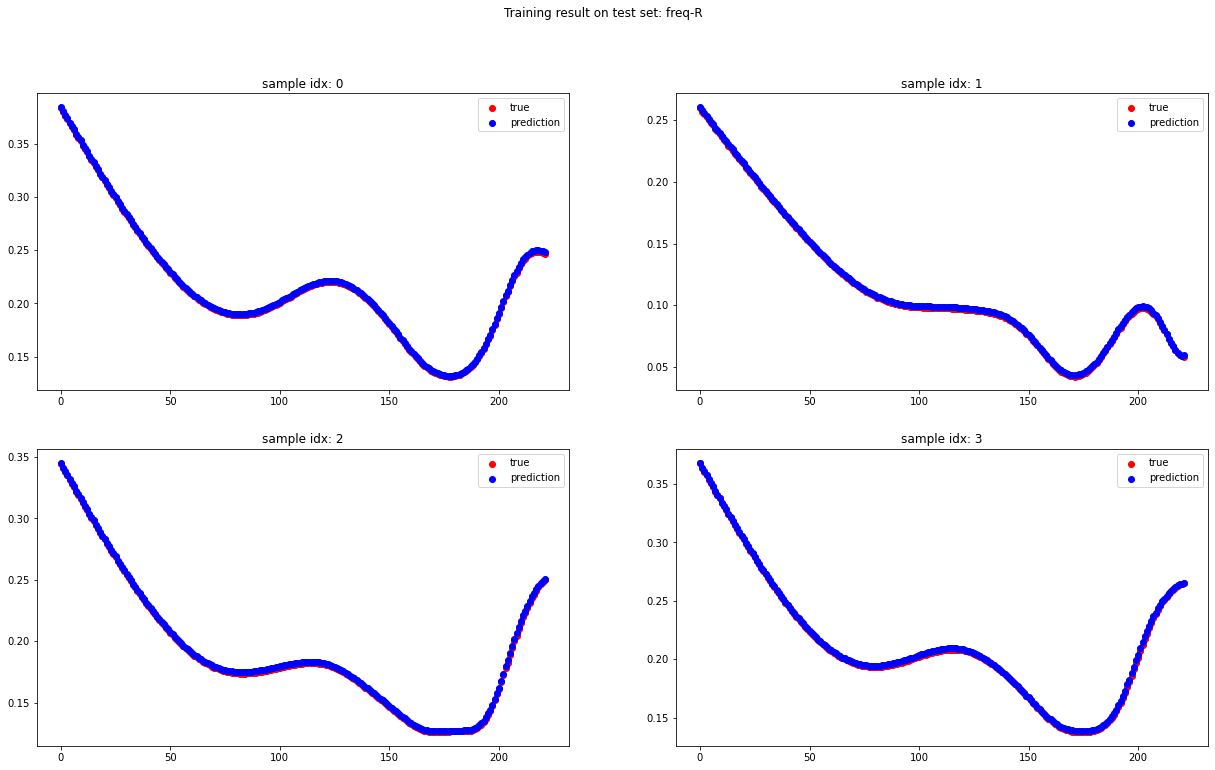

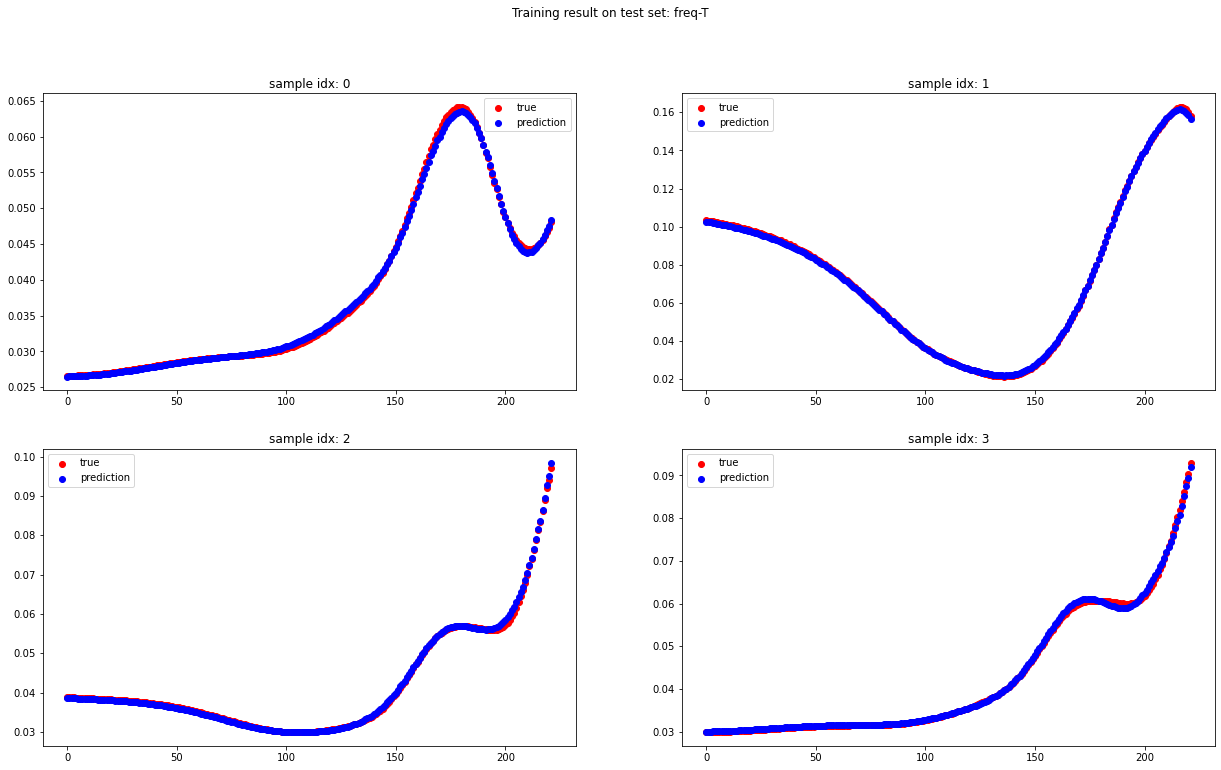

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 123. 160.  75.]
 [145. 122. 160.  75.]
 [146. 120. 160.  75.]
 [145. 121. 160.  75.]
 [145. 123. 160.  75.]
 [147. 121. 160.  75.]
 [145. 120. 160.  75.]
 [146. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


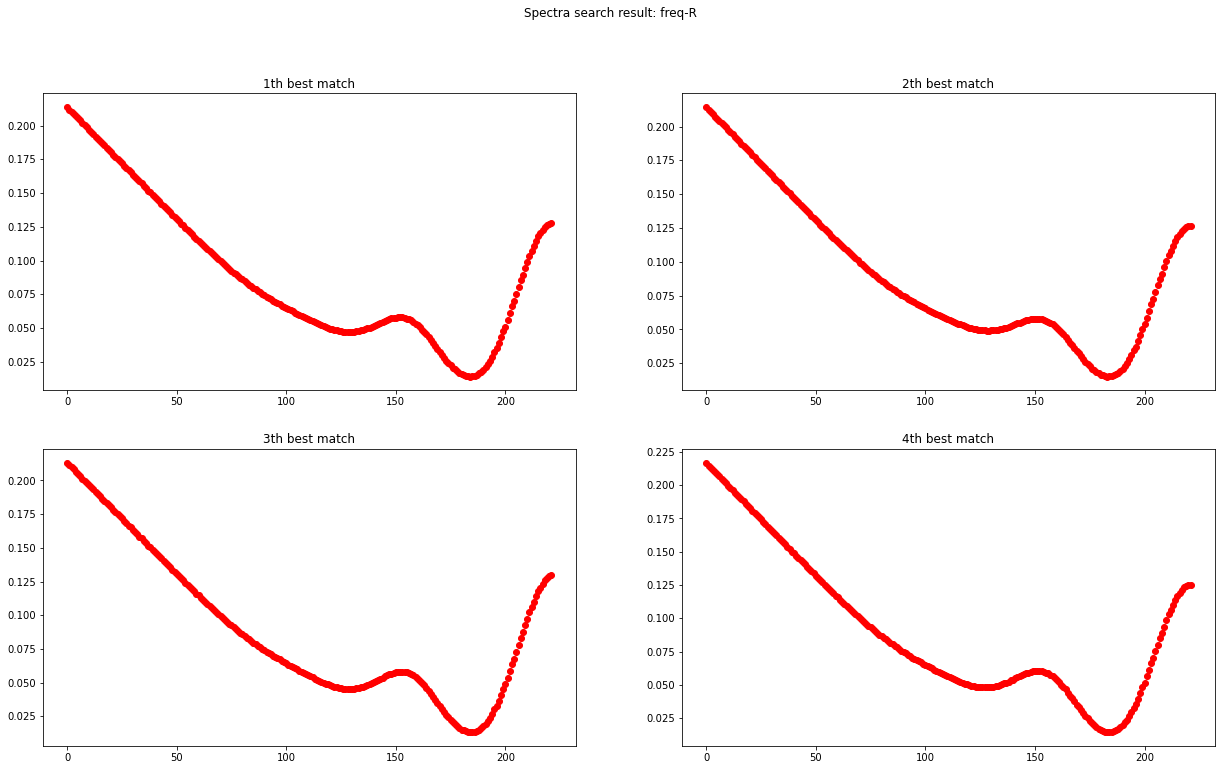

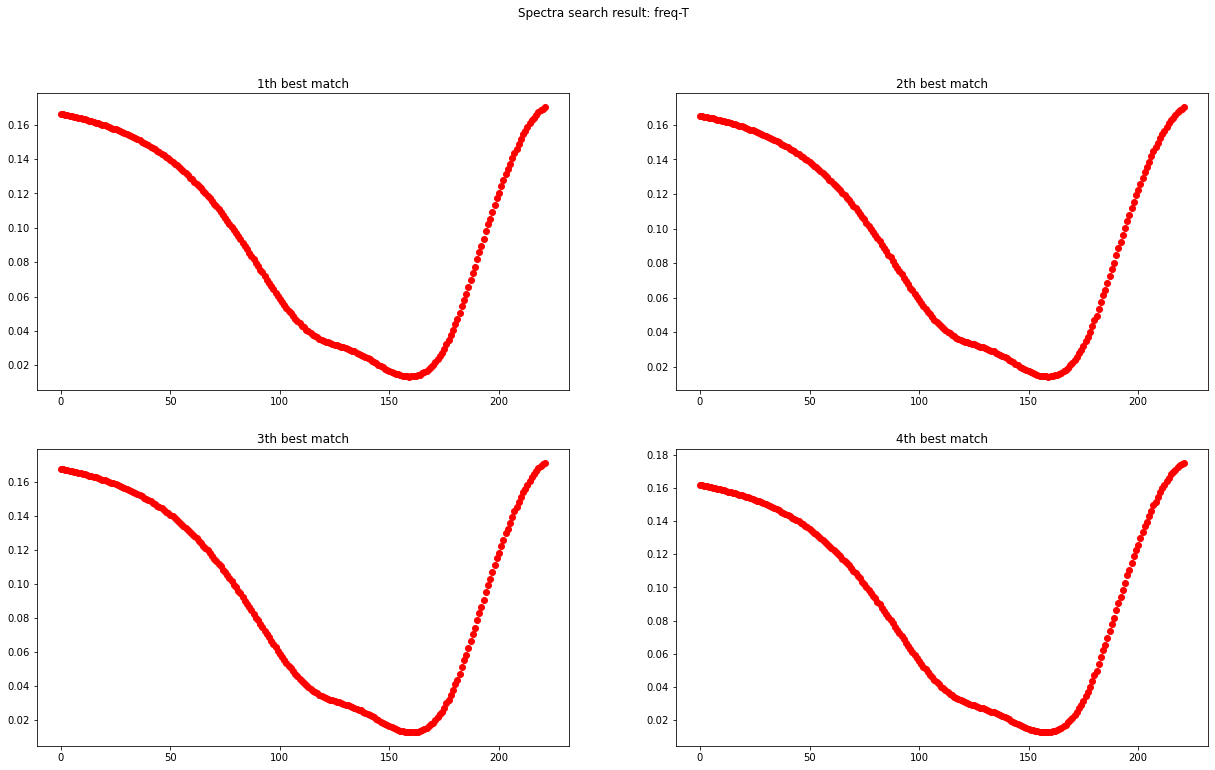

*** Reruning RCWA on picked params
params_dict.shape: (1015, 4)
R_dict.shape: (1015, 222)
T_dict.shape: (1015, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
---------

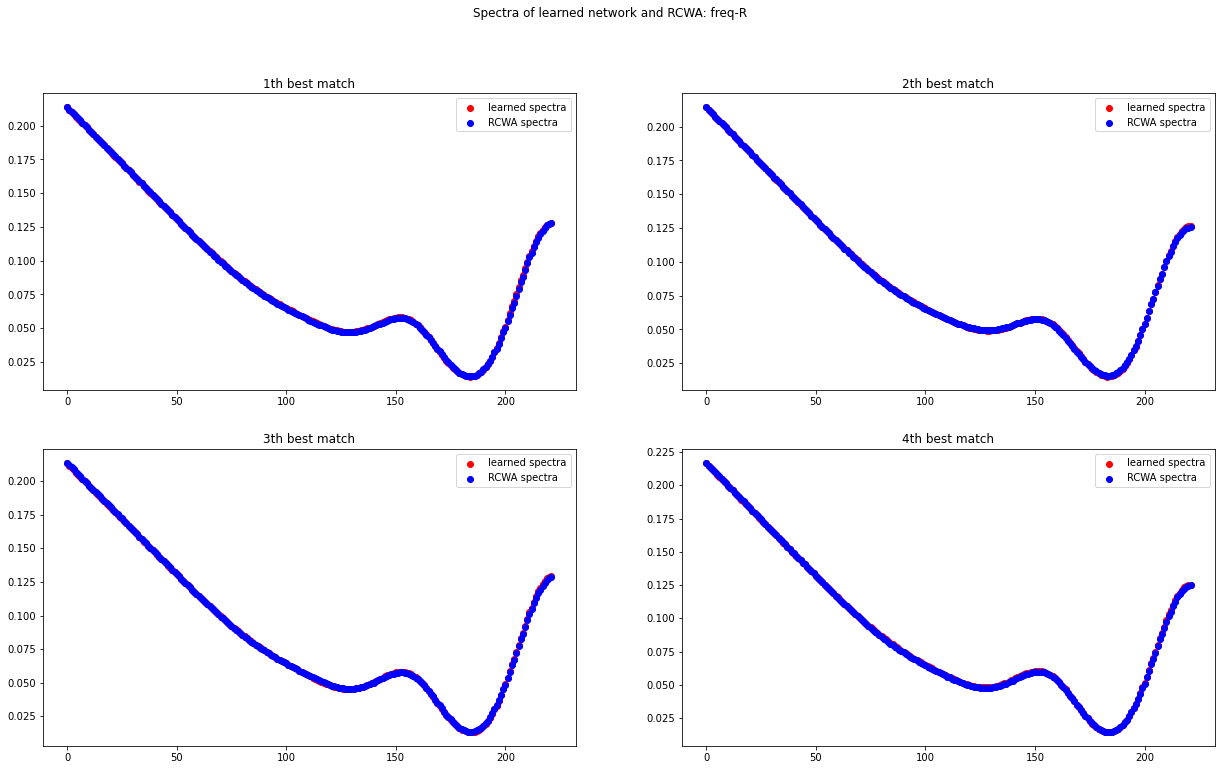

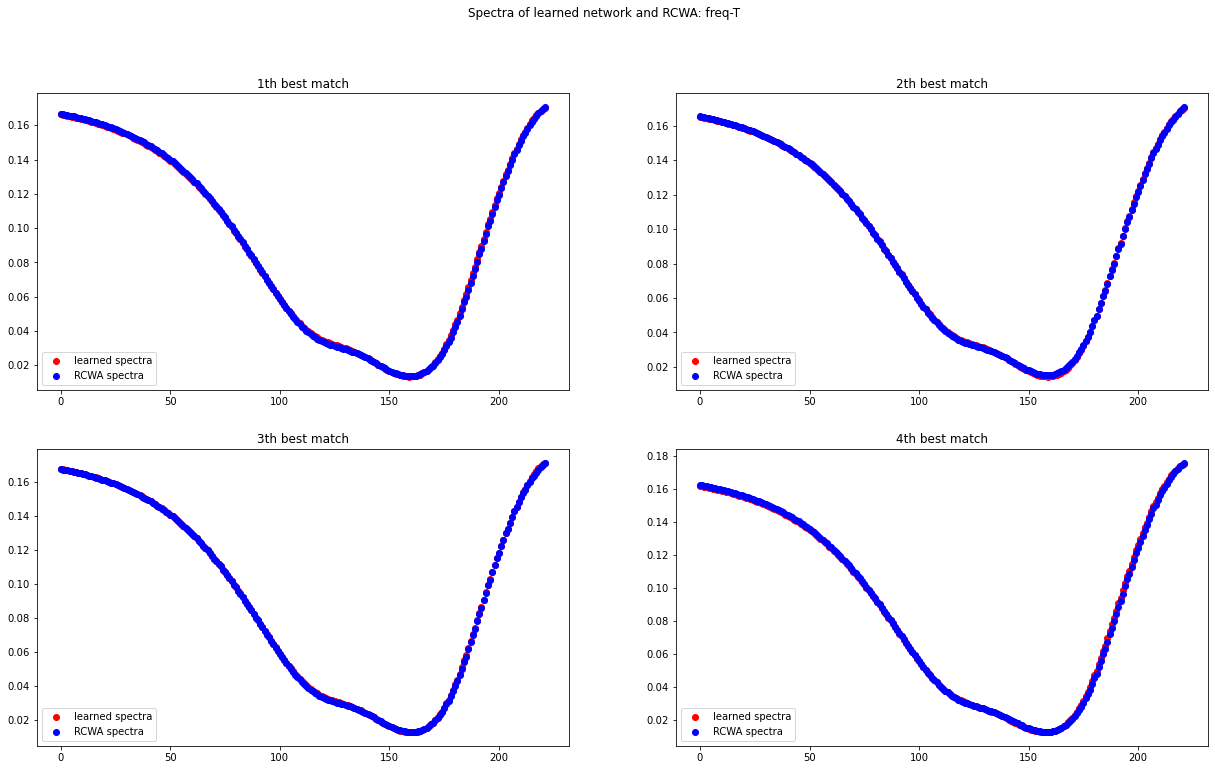

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1215
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [101.  81.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [130. 112.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [130. 150.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [103.  77.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [53. 81.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 64. 100.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [106.  89.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [116. 148.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [121.  50.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [72. 82.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 85. 105.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [104. 117.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [134. 113.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 64. 132.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 83. 100.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [111.  60.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 75. 137.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [69. 94.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [119. 116.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [135. 108.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 52. 119.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [103. 108.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 4.827483457973605e-05
### TEST LOSS  0.00023352291732168707
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.737683269222783e-05
### TEST LOSS  3.849537470638384e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.245665383697638e-06
### TEST LOSS  5.134712984344285e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 6.1267172140205805e-06
### TEST LOSS  3.9171261768818733e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.2155039866118932e-05
### TEST LOSS  1.1894280090162188e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 5.63458853306471e-06
### TEST LOSS  4.24030975553155e-06
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.142366009623819e-06
### TEST LOSS  1.1735852527444398e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.6214695915293375e-06
### TEST LOSS  9.610229677778797e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.1586162462332897e-06
### TEST LOSS  8.392219234864521e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.2130625676058745e-06
### TEST LOSS  2.8534268494695425e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.6574638167428933e-06
### TEST LOSS  1.7295322466356754e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0131662616357402e-06
### TEST LOSS  6.711737258133087e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.381235721436803e-07
### TEST LOSS  7.168247921790202e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 6.646396441409606e-07
### TEST LOSS  7.412715460400489e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.192476650026378e-07
### TEST LOSS  3.1615876507298946e-05
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.387200013005397e-06
### TEST LOSS  1.2312182057509123e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 2.5736087294064323e-06
### TEST LOSS  8.352691144122409e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.0316766013103126e-06
### TEST LOSS  1.6103873457196689e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.819340706691385e-07
### TEST LOSS  5.249137033340383e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.605862563891317e-07
### TEST LOSS  5.222430140269066e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.576037335934977e-07
### TEST LOSS  6.750728986341863e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.224499317672518e-07
### TEST LOSS  5.959059532606739e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.5827414707169875e-06
### TEST LOSS  7.485057716095119e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.2293570799168775e-06
### TEST LOSS  5.85130070057379e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 2.2733163809108683e-06
### TEST LOSS  7.760279818045857e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.050726756389333e-06
### TEST LOSS  9.340737930965827e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.1250037432462165e-06
### TEST LOSS  4.4603455918197714e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 8.074498329838647e-07
### TEST LOSS  7.23500016575647e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.213415153720955e-07
### TEST LOSS  7.614430555086552e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.6233905360222e-07
### TEST LOSS  4.0352414855174415e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.5952937563722357e-07
### TEST LOSS  8.222469228999935e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.221593057393016e-07
### TEST LOSS  1.1691013511201737e-06
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.371669275921848e-07
### TEST LOSS  5.705607547593229e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.799645373686366e-07
### TEST LOSS  1.216199746666366e-06
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.885045141375517e-07
### TEST LOSS  3.737973860265093e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.6734442544323584e-07
### TEST LOSS  4.121685411686677e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.2486680039859375e-07
### TEST LOSS  3.968600864075262e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.9765461879935096e-07
### TEST LOSS  3.0353374457167534e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.010220981176053e-07
### TEST LOSS  2.862159213260671e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.723009267035985e-07
### TEST LOSS  3.3302389487002263e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.2143310102565685e-07
### TEST LOSS  3.0902818082267913e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.0969874071533696e-07
### TEST LOSS  4.761146334730208e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.467930308235822e-07
### TEST LOSS  3.049246222537094e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.3459984866223933e-07
### TEST LOSS  5.633036347549741e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.2156550607664043e-07
### TEST LOSS  3.4855777267981277e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.1849943532498426e-07
### TEST LOSS  3.529210331228234e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.6757459064810093e-07
### TEST LOSS  5.42267267627195e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.3544255200473765e-07
### TEST LOSS  3.6320828132231424e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.2061688954097433e-07
### TEST LOSS  3.5061957024290197e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.289271186234447e-07
### TEST LOSS  5.328192975483896e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.861895068075963e-07
### TEST LOSS  2.675089384159659e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.9017575008380317e-07
### TEST LOSS  3.877433055334366e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.097598780375194e-07
### TEST LOSS  3.2946568757396517e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.217948543532704e-07
### TEST LOSS  5.176798786602663e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.412935881903345e-07
### TEST LOSS  4.0593014947070944e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.7248990502100107e-07
### TEST LOSS  4.224626689177201e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.950760934255185e-07
### TEST LOSS  6.942920684219931e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.6398660382477e-07
### TEST LOSS  2.716600584718483e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.1525270264401585e-07
### TEST LOSS  2.602580988614615e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.506317965937701e-07
### TEST LOSS  3.468742718089408e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.0873662474782874e-07
### TEST LOSS  3.910645049424937e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.6397994334336716e-07
### TEST LOSS  4.3197823330094824e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.5278634293300593e-07
### TEST LOSS  2.7401919797548064e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.24776595946641e-07
### TEST LOSS  2.6834199891374354e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.675433168284472e-07
### TEST LOSS  4.761759794890072e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.604673159944326e-07
### TEST LOSS  3.7728512019815467e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.38988961787407e-07
### TEST LOSS  6.213177737448094e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.8113148000325186e-07
### TEST LOSS  3.631641394158099e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.284973873282717e-07
### TEST LOSS  2.5873779095850055e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.0537458659231833e-07
### TEST LOSS  6.33963963991846e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.018370210530507e-07
### TEST LOSS  5.177468551664788e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.5418592775854375e-07
### TEST LOSS  2.466289707196043e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.356417493136853e-07
### TEST LOSS  2.6871641155498524e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.426395839773186e-07
### TEST LOSS  3.2118642940603376e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.4629305482662726e-07
### TEST LOSS  3.289113827146426e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.501346395069868e-07
### TEST LOSS  5.335799821631027e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.3218864353906846e-07
### TEST LOSS  3.2221222873455476e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.582266009680135e-07
### TEST LOSS  3.7492161571830555e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.010165783814082e-07
### TEST LOSS  3.513862368795105e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.6702563560362783e-07
### TEST LOSS  6.687714122371721e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.516669789924645e-07
### TEST LOSS  3.1113242471292324e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.761776080999807e-07
### TEST LOSS  2.8913166784748585e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.285254682184226e-07
### TEST LOSS  3.287092654677269e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.4724021126130035e-07
### TEST LOSS  4.710339507446885e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.2983967519230404e-07
### TEST LOSS  2.737471431289937e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.169011530724874e-07
### TEST LOSS  2.421784122481385e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.586894765096587e-07
### TEST LOSS  5.884185710376761e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.1398873968457314e-07
### TEST LOSS  3.117710141515617e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.256160545913504e-07
### TEST LOSS  3.1295617400485896e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.978983582711209e-07
### TEST LOSS  4.230457582372382e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.2577557333030916e-07
### TEST LOSS  2.491454011988026e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.3653092328270743e-07
### TEST LOSS  4.3237442295513145e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.7091326983437525e-06
### TEST LOSS  3.1015484206651114e-05
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.558130345911844e-06
### TEST LOSS  1.004988385937778e-06
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.379395944313485e-06
### TEST LOSS  2.8663589546340518e-06
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 6.671840989204363e-07
### TEST LOSS  3.7898501665566936e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.3359419935931545e-07
### TEST LOSS  3.1398157393356853e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.061695580228437e-07
### TEST LOSS  2.513794388086784e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.7553806993489363e-07
### TEST LOSS  4.1750442691361396e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.068235947247326e-07
### TEST LOSS  3.189514808055767e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.2285779213706344e-07
### TEST LOSS  3.060606305002454e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.863823945262909e-07
### TEST LOSS  2.7504911770392937e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.429579821743811e-07
### TEST LOSS  2.7310314982586487e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.1416697292033374e-07
### TEST LOSS  3.210023404981736e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.0051404099878464e-07
### TEST LOSS  2.8511743197979837e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.257924128334893e-07
### TEST LOSS  2.865569511737033e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.5876406183705625e-07
### TEST LOSS  2.3901910289599696e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.879158541209866e-07
### TEST LOSS  2.356271693315648e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.619268638255418e-07
### TEST LOSS  3.3069394446197533e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.2536163942550685e-07
### TEST LOSS  1.9766322697921026e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.0752764232209214e-07
### TEST LOSS  3.698396136243039e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.067656020951041e-07
### TEST LOSS  3.7829908562439654e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.3158663459212334e-07
### TEST LOSS  2.456920363532558e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.4253588091124814e-07
### TEST LOSS  9.007372281494578e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.2005449516692516e-07
### TEST LOSS  4.012779060614871e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.2775334242503336e-07
### TEST LOSS  2.3069430567016083e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.045657749068391e-07
### TEST LOSS  5.109192724567516e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.005143248562215e-07
### TEST LOSS  2.692669520336877e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.986231236655085e-07
### TEST LOSS  2.6166349031379806e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.337678586969799e-07
### TEST LOSS  2.2419091818081048e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.150799790585158e-07
### TEST LOSS  2.2360291788907872e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.9892082929959007e-07
### TEST LOSS  2.50150636672611e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.387219033644774e-07
### TEST LOSS  4.169229710944484e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.5222870154936495e-07
### TEST LOSS  4.223812317449253e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.809587328835822e-07
### TEST LOSS  2.751678052666313e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.953238190211137e-07
### TEST LOSS  3.6770190167532603e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.118384300894433e-07
### TEST LOSS  3.4871105320259007e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.1936228942947716e-07
### TEST LOSS  2.9948240117056756e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.2295390565347755e-07
### TEST LOSS  4.826747559299724e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.986674680192119e-07
### TEST LOSS  3.863409050920477e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.952256847723298e-07
### TEST LOSS  2.2210539148210572e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.9340964922067043e-07
### TEST LOSS  2.135911994640226e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.802413380918168e-07
### TEST LOSS  2.893711738531573e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.06428232883616e-07
### TEST LOSS  2.1097979111130514e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.9267209711074926e-07
### TEST LOSS  2.3206712359967098e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.077312213131598e-07
### TEST LOSS  2.3318621195381924e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.801563360295463e-07
### TEST LOSS  2.5180361973298204e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.8404290562519565e-07
### TEST LOSS  3.0347063940146317e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.9224424596474196e-07
### TEST LOSS  2.8510898175682087e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.05735025373018e-07
### TEST LOSS  2.5624853686909584e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.030030701714036e-07
### TEST LOSS  4.124550933307833e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.9978994184448535e-07
### TEST LOSS  3.3935810288192826e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.085202775328829e-07
### TEST LOSS  3.937616309270341e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.6752053332679587e-07
### TEST LOSS  3.0702394918822203e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.143334246352965e-07
### TEST LOSS  2.844092430103429e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.203674301251643e-07
### TEST LOSS  3.0577869985767107e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.003876023079002e-07
### TEST LOSS  2.0522248546153845e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.142818107466419e-07
### TEST LOSS  3.8511085838428315e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.0043455958455895e-07
### TEST LOSS  3.7700504893372883e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.8746219489173683e-07
### TEST LOSS  2.7808545379876276e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.052197013327878e-07
### TEST LOSS  3.451061452982398e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.6948885454090776e-07
### TEST LOSS  2.0538581530241858e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.9849538715369696e-07
### TEST LOSS  2.6537118009472533e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.0038420514459964e-07
### TEST LOSS  4.0876093078766547e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.119892043865602e-07
### TEST LOSS  3.687378116530071e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.731133945004366e-07
### TEST LOSS  3.0861875487923836e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.890836135073864e-07
### TEST LOSS  2.3029830973236562e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.777883095713143e-07
### TEST LOSS  1.74741740609438e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.738104315322798e-07
### TEST LOSS  7.652708943265009e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.25894315897437e-07
### TEST LOSS  2.2497141197905684e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.3939579902236404e-07
### TEST LOSS  2.1893735292547048e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.090801672038598e-07
### TEST LOSS  2.5274247144280753e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.7870716179634825e-07
### TEST LOSS  2.59205413343759e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.8389764552275806e-07
### TEST LOSS  1.8732022810079223e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.08389081654579e-07
### TEST LOSS  3.577426968460809e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.170071261559281e-07
### TEST LOSS  1.9803897544079518e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.793215482106115e-07
### TEST LOSS  3.126514050228779e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.956656178978326e-07
### TEST LOSS  3.68839173939992e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.6206619544988056e-07
### TEST LOSS  2.328699516259516e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.6754684655576063e-07
### TEST LOSS  1.8991476891690247e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.01533536040807e-07
### TEST LOSS  2.1393568853287242e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.94034686555043e-07
### TEST LOSS  2.1175224006990327e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.685304495549016e-07
### TEST LOSS  2.8130779427508397e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.1436060450901173e-07
### TEST LOSS  3.9325290775818037e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.6669444308851683e-07
### TEST LOSS  4.917027503755602e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.712316469887155e-07
### TEST LOSS  4.978864482334182e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.1050902736527963e-07
### TEST LOSS  2.2760420093666318e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.648003290161624e-07
### TEST LOSS  3.887642612043189e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.8936583717843134e-07
### TEST LOSS  2.3656904010007757e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.998887588707434e-07
### TEST LOSS  2.4479609581512224e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 3.0250151830177446e-07
### TEST LOSS  2.7549699074083226e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.900784372175817e-07
### TEST LOSS  3.2595637234958544e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.38460152167994e-07
### TEST LOSS  2.483660644633059e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.6013977661637373e-07
### TEST LOSS  2.8706853296817397e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.9420518726269694e-07
### TEST LOSS  3.703348559276109e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.807328802403646e-07
### TEST LOSS  2.427907131014332e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.660080933679748e-07
### TEST LOSS  2.1667168943239582e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.6251361907158105e-07
### TEST LOSS  3.7443930379690995e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.7980215630531413e-07
### TEST LOSS  2.026407411461294e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.4972230336964743e-07
### TEST LOSS  2.3047534706452815e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.8268640258617287e-07
### TEST LOSS  3.2644206944616216e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.9060223938209586e-07
### TEST LOSS  1.9680460190173968e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.7238148356327526e-07
### TEST LOSS  2.978739822286738e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.7858044542653236e-07
### TEST LOSS  3.259647612415057e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.773663731906466e-07
### TEST LOSS  2.0763918079661666e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.578830677086552e-07
### TEST LOSS  3.0888939985934965e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.7549331103022053e-07
### TEST LOSS  3.005319341223424e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.10898938285109e-07
### TEST LOSS  3.370233963251897e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.584638742621243e-07
### TEST LOSS  1.9660305982047008e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.541823653117298e-07
### TEST LOSS  2.5386715887371363e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.5538840377862936e-07
### TEST LOSS  2.045502563120001e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.5035915419193076e-07
### TEST LOSS  2.376186194241152e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.79083543271946e-07
### TEST LOSS  2.644804968248967e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.125328054530527e-07
### TEST LOSS  2.886772652968112e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.712699789461682e-07
### TEST LOSS  2.1313994125193858e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.703321703386257e-07
### TEST LOSS  2.3894388334610994e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.813892618341611e-07
### TEST LOSS  2.0699136963517766e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.553340031033526e-07
### TEST LOSS  2.557767761333564e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.618667517605162e-07
### TEST LOSS  2.0654964765454727e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.706594023553265e-07
### TEST LOSS  4.639076020171878e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.771103759136805e-07
### TEST LOSS  2.035039952225385e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.6325027168703156e-07
### TEST LOSS  2.0759011482895354e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.718026413344396e-07
### TEST LOSS  5.520158735730786e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.831386823654162e-07
### TEST LOSS  1.7015129871149264e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.7129006501413943e-07
### TEST LOSS  2.586434787513338e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.356663585661383e-07
### TEST LOSS  2.281138223811228e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.671359459345049e-07
### TEST LOSS  2.0209701290241355e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.0547028298899e-07
### TEST LOSS  7.094323953089387e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.854370132232827e-07
### TEST LOSS  3.348296143270234e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.5547660621748913e-07
### TEST LOSS  2.0058809537347675e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.412864610612748e-07
### TEST LOSS  2.3421381680882883e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.5123606916128476e-07
### TEST LOSS  2.793920611123356e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.422651859301429e-07
### TEST LOSS  2.0186209924663432e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.557950939926451e-07
### TEST LOSS  3.5673170074053477e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.7328030874655586e-07
### TEST LOSS  2.102129135556951e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.245802972583172e-07
### TEST LOSS  2.6778953772583535e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.0970105926700046e-07
### TEST LOSS  2.3277079650908585e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.5458537087626923e-07
### TEST LOSS  1.9289098711277276e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.894529034930831e-07
### TEST LOSS  3.127276455104852e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.3615781504457776e-07
### TEST LOSS  1.9994890533924168e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.5670822927708646e-07
### TEST LOSS  1.8420399110135278e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.5318977066766596e-07
### TEST LOSS  2.194144756410759e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.590324371934736e-07
### TEST LOSS  1.649258417788396e-07
** loss_train 2.590324371934736e-07
** loss_test 1.649258417788396e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


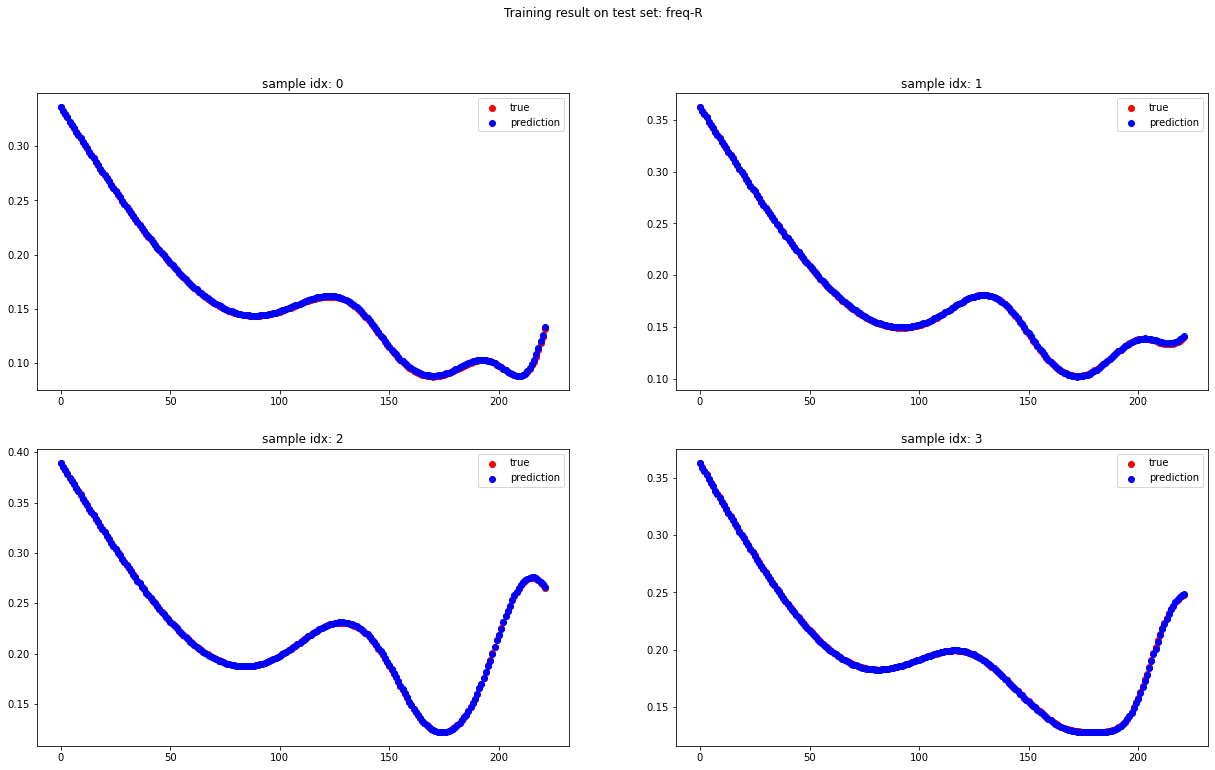

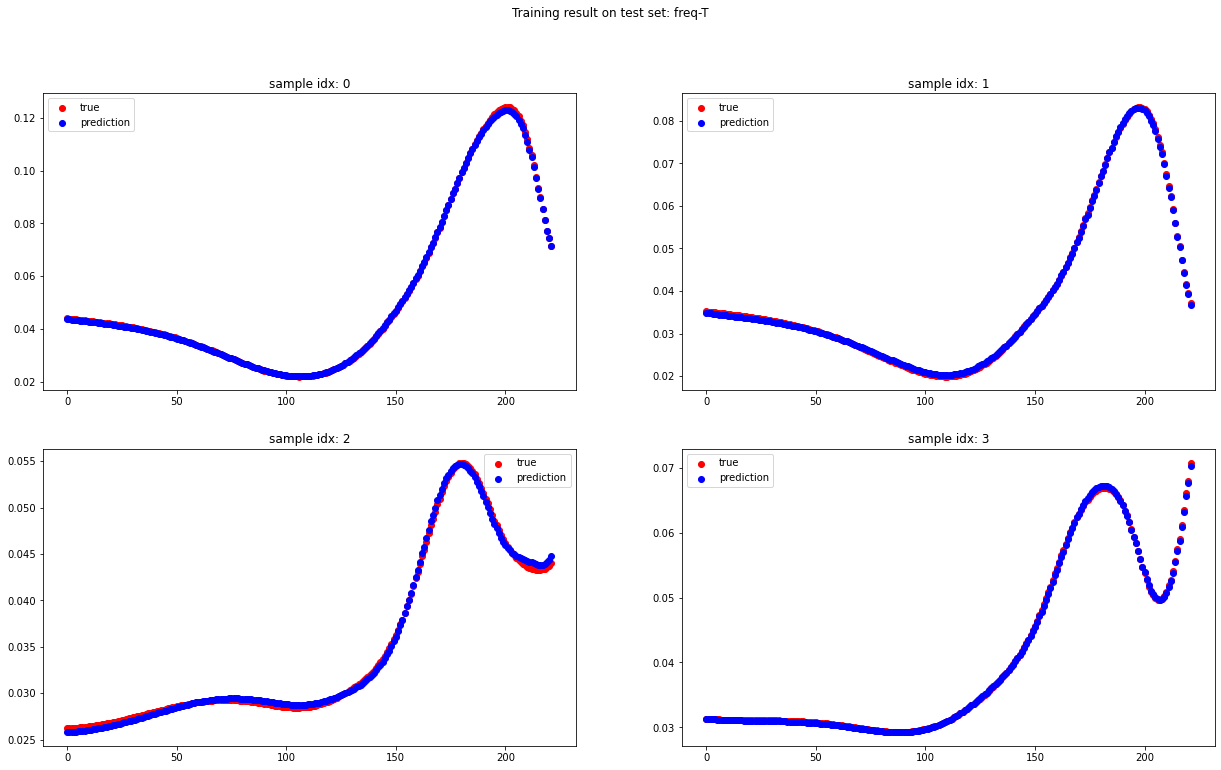

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 122. 160.  75.]
 [145. 123. 160.  75.]
 [145. 121. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]
 [145. 120. 160.  75.]
 [146. 119. 160.  75.]
 [144. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


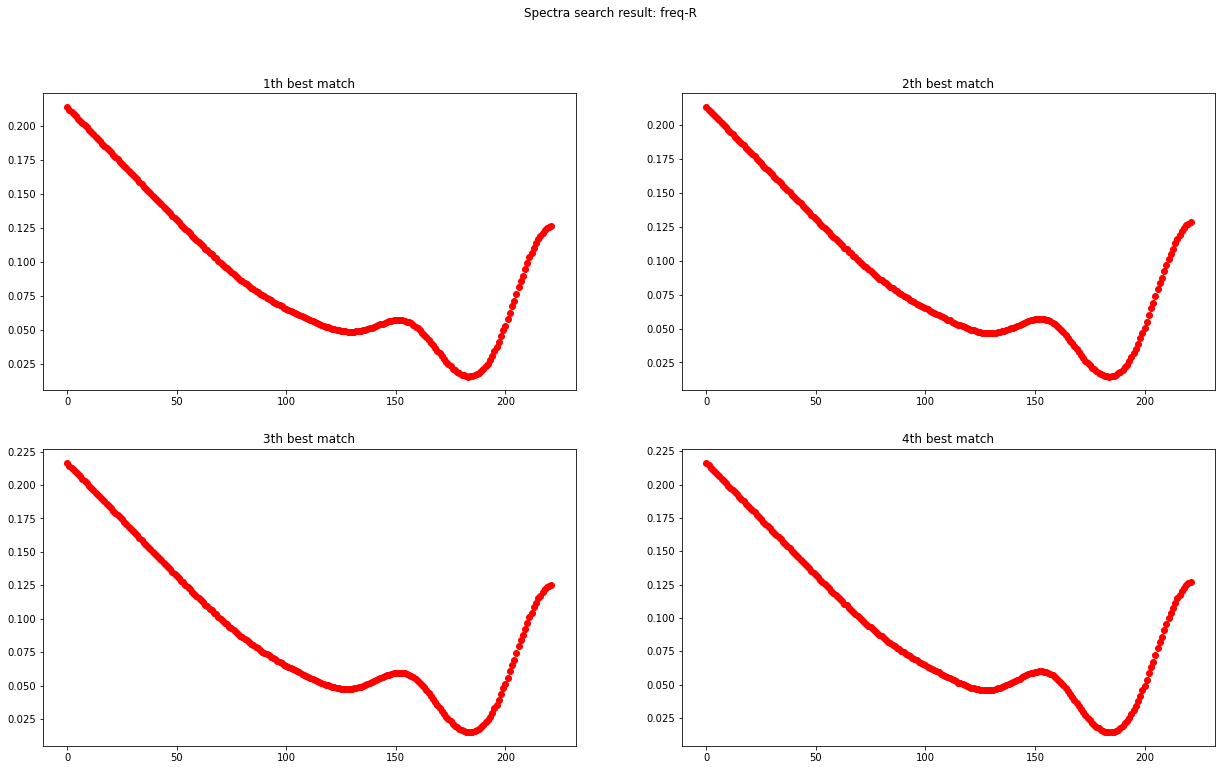

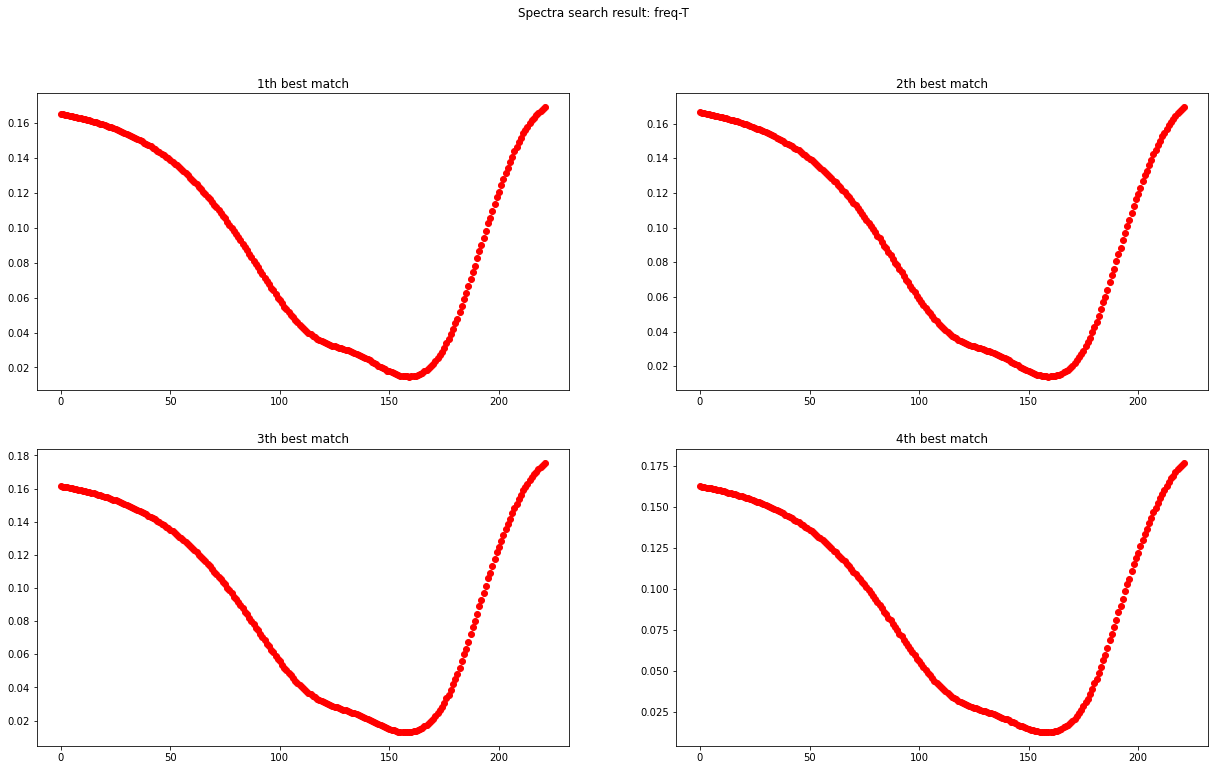

*** Reruning RCWA on picked params
params_dict.shape: (1215, 4)
R_dict.shape: (1215, 222)
T_dict.shape: (1215, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
---------

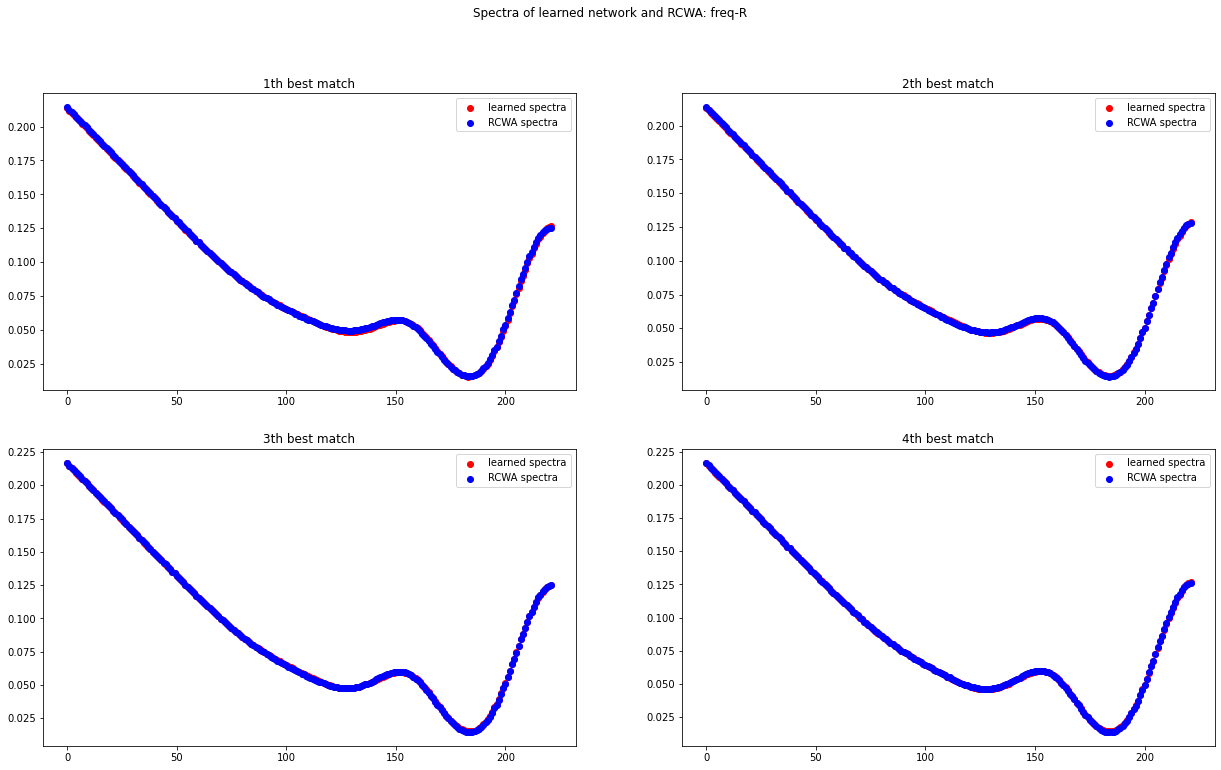

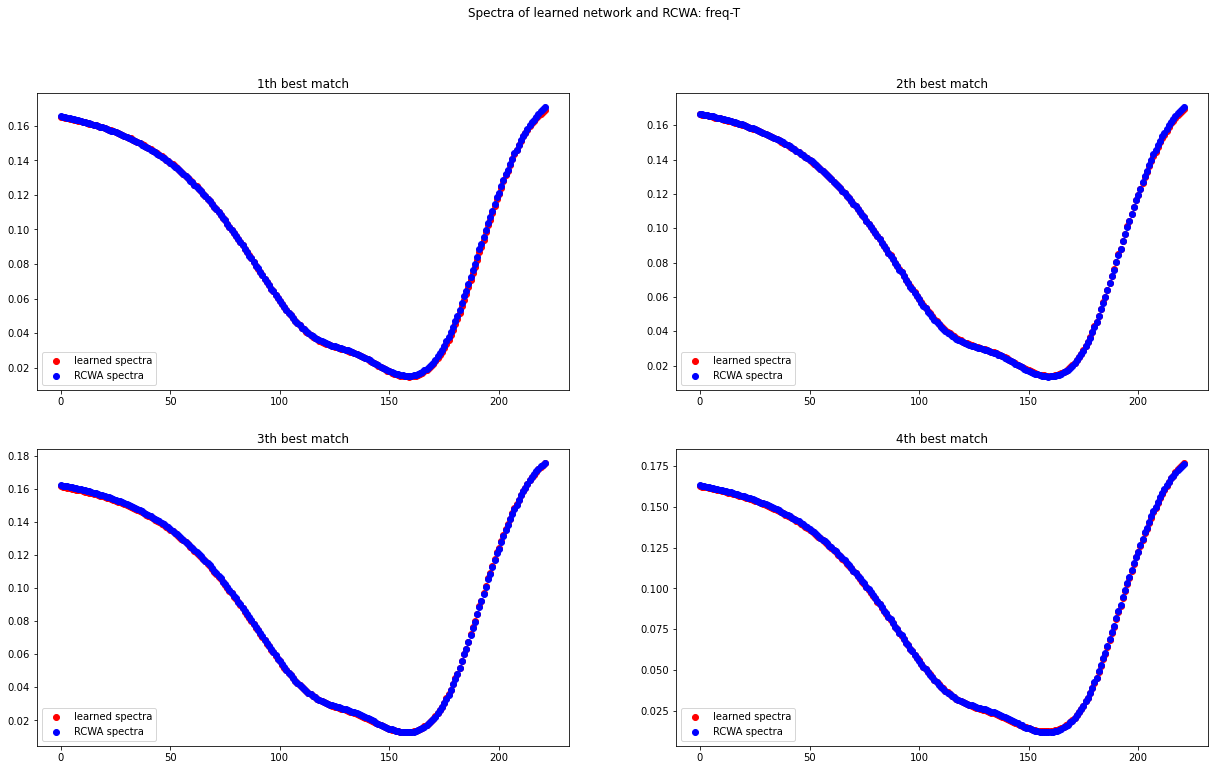

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1416
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [148. 104.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [68. 57.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [100.  66.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [127.  97.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [140.  74.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 79. 140.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [78. 61.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [55. 70.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 83. 101.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [115.  79.]
Calculation Pro

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [129. 108.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [82. 54.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [116. 106.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 80. 137.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 78. 118.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [106. 119.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [57. 69.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [74. 70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [142. 139.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [136.  85.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [69. 81.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 65. 147.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.913955820651462e-05
### TEST LOSS  0.00010724476537275636
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 9.640597581838714e-06
### TEST LOSS  2.684964484119105e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 9.926519446704759e-06
### TEST LOSS  2.828526352128723e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.736499779217232e-06
### TEST LOSS  2.273215588130287e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.6136181854889136e-06
### TEST LOSS  2.5958741089611563e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 6.448011094924806e-06
### TEST LOSS  1.5793293311038393e-05
----------------------------------------------------------------------
*

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.4972826926129056e-06
### TEST LOSS  1.0897062684927568e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.3593672684772987e-06
### TEST LOSS  1.3855781446636684e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.2835147717391167e-06
### TEST LOSS  1.5883383846151198e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.0407495102663297e-06
### TEST LOSS  6.074671690922432e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.2424020830531481e-06
### TEST LOSS  9.221921004609612e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0680327473947405e-06
### TEST LOSS  2.5894854719478064e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.706706172430478e-06
### TEST LOSS  2.3796290158564015e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.1082530241660986e-06
### TEST LOSS  8.550408691379826e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.0081109017398513e-06
### TEST LOSS  6.406051698801011e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.517571947659824e-06
### TEST LOSS  2.4063915847446795e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.682845482490071e-06
### TEST LOSS  6.867090989585862e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 8.928404934629468e-07
### TEST LOSS  1.2664220062933138e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.390433697240265e-07
### TEST LOSS  1.1768663419140715e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 5.829672326945097e-07
### TEST LOSS  4.5318552369363635e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.980556056209772e-07
### TEST LOSS  5.713169702982089e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.28001668951342e-07
### TEST LOSS  5.32835401982497e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.382521538226924e-07
### TEST LOSS  6.85468514596075e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.76375091715889e-07
### TEST LOSS  5.318164036018722e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.952482074156176e-07
### TEST LOSS  3.81652775806949e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.027565690091012e-07
### TEST LOSS  5.366503098064806e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.418287189037746e-07
### TEST LOSS  4.318704689219224e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.248195309147456e-07
### TEST LOSS  5.83904712863676e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.13896609263512e-07
### TEST LOSS  3.752523463679774e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.019582871215529e-07
### TEST LOSS  3.759555537189127e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.638448837478481e-07
### TEST LOSS  4.5653227557936177e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.065898970570568e-07
### TEST LOSS  3.3466119701715385e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.50044404701488e-07
### TEST LOSS  6.333423437416225e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.526816831215649e-07
### TEST LOSS  7.654150444771155e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.329561737318864e-07
### TEST LOSS  5.038886014703663e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.342009575182913e-07
### TEST LOSS  9.74007052305255e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.340207218732484e-07
### TEST LOSS  5.14378604841361e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.115605262565193e-07
### TEST LOSS  3.667494791092064e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.720564688395971e-07
### TEST LOSS  4.089404331931622e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.506914785554441e-07
### TEST LOSS  6.492571794131602e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.228953723878936e-07
### TEST LOSS  8.023687004507255e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.577366880685239e-07
### TEST LOSS  4.4049878443853563e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.937292141128513e-07
### TEST LOSS  4.180784752737633e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.0067037239559713e-07
### TEST LOSS  4.680457795881342e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.46415426959773e-07
### TEST LOSS  7.045514032390863e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.6073754494224995e-07
### TEST LOSS  4.6131941386110237e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.3516258826878516e-07
### TEST LOSS  3.3880697132686194e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.085531923656088e-07
### TEST LOSS  5.095124012396727e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.861940499622795e-07
### TEST LOSS  3.087516563224116e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.006614908020825e-07
### TEST LOSS  5.786053572426847e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.1778621830127414e-07
### TEST LOSS  5.888756104158429e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.9474945926230425e-07
### TEST LOSS  3.453457382689025e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.1129618467713403e-07
### TEST LOSS  5.165326926585707e-07


In [ ]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([129])
tg_value_R = np.array([0.03])
tg_idx_freq_T = np.array([0, 167])
tg_value_T = np.array([0.23, 0.])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 200
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_same][np.newaxis,...], R_dict[idx_same][np.newaxis,...], T_dict[idx_same][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
    # save params_list and update all_params as params_dict (*optional)
    path_params_list = './data/' + path_material_name + '/params_list_' + path_material_name + '.npz'
    print('params_dict[..., 0:2].shape:', params_dict[..., 0:2].shape)
    np.savez(path_params_list, params_list=params_dict[..., 0:2])
    params_all, R_all, T_all = params_dict, R_dict, T_dict
    print('params_dict.shape:', params_dict.shape)
    
            
#     print('*** Reruning RCWA on picked params')
#     rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
#                                            path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    print('** loss_R.shape:', np.linalg.norm(R_pick-R_simu, ord=2, axis=-1).shape)
    print('** loss_R for each:', np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    print('** loss_T for each:', np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    print('** loss_R:', loss_R, '|| loss_T:', loss_T)
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')